In [2]:
# ========================== Cell 1: Imports & Config ==========================
import os
import numpy as np
import pandas as pd
import torch
import timm
import cv2
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Dataset and checkpoint paths
LABELS_CSV = "labels_clean.csv"
VAL_SPLIT = "val_split.txt"
IMG_DIR = "data"

# Model checkpoints (update these to your actual paths)
DENSENET_CKPT = "checkpoints_densenet/best_model_auroc.pth"
EFFB3_CKPT = "checkpoints_efficientnet_b3/best_model_auroc.pth"
EFFB4_CKPT = "checkpoints_efficientnet_b4/best_model_auroc_b4.pth"
SWIN_CKPT = "models/swin_transformer/swin_best_auroc.pth"


# Disease class names
class_names = [
    'Atelectasis','Cardiomegaly','Effusion','Infiltration','Mass',
    'Nodule','Pneumonia','Pneumothorax','Consolidation','Edema',
    'Emphysema','Fibrosis','Pleural_Thickening','Hernia'
]

# Validation transforms
val_transform = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])


Using device: cuda


In [3]:
# ========================== Cell 2: Dataset ==========================
class ChestXrayDataset(Dataset):
    def __init__(self, file_list, img_dir, labels_csv, img_size=224, transform=None):
        df = pd.read_csv(labels_csv)
        label_dict = dict(zip(df['Image Index'], df.drop(columns=['Image Index']).values.tolist()))
        
        self.img_paths, self.labels = [], []
        with open(file_list, "r") as f:
            for line in f:
                fname = line.strip().split()[0]
                if fname not in label_dict:
                    continue
                found_path = None
                for subdir in os.listdir(img_dir):
                    subpath = os.path.join(img_dir, subdir, "images", fname)
                    if os.path.exists(subpath):
                        found_path = subpath
                        break
                if found_path:
                    self.img_paths.append(found_path)
                    self.labels.append(label_dict[fname])
        
        self.labels = np.array(self.labels, dtype=np.float32)
        self.img_size = img_size
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_paths[idx], cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (self.img_size, self.img_size))
        img = np.stack([img, img, img], axis=-1)
        if self.transform:
            img = self.transform(image=img)["image"]
        else:
            img = torch.tensor(img / 255.0, dtype=torch.float32).permute(2, 0, 1)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return img, label


In [4]:
# ========================== Cell 3: Validation Dataloaders ==========================
batch_size = 8

val_loader_dn = DataLoader(
    ChestXrayDataset(VAL_SPLIT, IMG_DIR, LABELS_CSV, 224, val_transform),
    batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

val_loader_b3 = DataLoader(
    ChestXrayDataset(VAL_SPLIT, IMG_DIR, LABELS_CSV, 300, val_transform),
    batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

val_loader_b4 = DataLoader(
    ChestXrayDataset(VAL_SPLIT, IMG_DIR, LABELS_CSV, 380, val_transform),
    batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

val_loader_swin = DataLoader(
    ChestXrayDataset(VAL_SPLIT, IMG_DIR, LABELS_CSV, 384, val_transform),
    batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

print("Validation sets loaded successfully.")


Validation sets loaded successfully.


In [5]:
# ========================== Cell 4: Model Loading & Inference ==========================
def load_model(arch, ckpt_path):
    model = timm.create_model(arch, pretrained=False, num_classes=14)
    checkpoint = torch.load(ckpt_path, map_location=device)
    
    if "model_state_dict" in checkpoint:
        checkpoint = checkpoint["model_state_dict"]
    
    new_state_dict = {k.replace("backbone.", "").replace("module.", ""): v for k, v in checkpoint.items()}
    model.load_state_dict(new_state_dict, strict=False)
    model = model.to(device).eval()
    return model

def get_logits(model, loader, desc="Inference"):
    logits_list, targets_list = [], []
    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc=desc):
            imgs = imgs.to(device)
            out = model(imgs)
            logits_list.append(out.cpu().numpy())
            targets_list.append(labels.numpy())
    return np.vstack(logits_list), np.vstack(targets_list)


In [6]:
# ========================== Cell 5: Individual Model Evaluations ==========================
models = {
    "DenseNet121": ("densenet121", DENSENET_CKPT, val_loader_dn),
    "EfficientNet-B3": ("efficientnet_b3", EFFB3_CKPT, val_loader_b3),
    "EfficientNet-B4": ("efficientnet_b4", EFFB4_CKPT, val_loader_b4),
    "Swin-Transformer": ("swin_base_patch4_window7_224", SWIN_CKPT, val_loader_swin)
}

results = {}
for name, (arch, ckpt, loader) in models.items():
    print(f"\n===== Evaluating {name} =====")
    model = load_model(arch, ckpt)
    logits, y_true = get_logits(model, loader, desc=f"{name} inference")
    probs = 1 / (1 + np.exp(-logits))

    aucs = []
    for c in range(y_true.shape[1]):
        try:
            aucs.append(roc_auc_score(y_true[:, c], probs[:, c]))
        except:
            aucs.append(np.nan)
    macro_auc = np.nanmean(aucs)
    results[name] = macro_auc
    print(f"{name}: Macro AUROC = {macro_auc:.4f}")

print("\n=== Summary of Individual Model Performance ===")
for name, auc in results.items():
    print(f"{name:20} : {auc:.4f}")



===== Evaluating DenseNet121 =====


/tmp/ipykernel_100036/1208563929.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location=device)
DenseNet121 inference: 100%|████

DenseNet121: Macro AUROC = 0.8357

===== Evaluating EfficientNet-B3 =====


EfficientNet-B3 inference:  70%|██████▉   | 752/1082 [00:20<00:08, 37.51it/s]


KeyboardInterrupt: 

In [10]:
# ========================== SWIN-SMALL EVALUATION ==========================
import os
import numpy as np
import pandas as pd
import torch
import timm
import cv2
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
import albumentations as A
from albumentations.pytorch import ToTensorV2

# ------------------ Configurations ------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

LABELS_CSV = "labels_clean.csv"
VAL_SPLIT = "val_split.txt"
IMG_DIR = "data"

# ✅ Use your trained Swin checkpoint
SWIN_CKPT = "models/swin_transformer/swin_best_auroc.pth"
# Alternative if you want best-F1 checkpoint:
# SWIN_CKPT = "models/swin_transformer/swin_best_f1.pth"

class_names = [
    'Atelectasis','Cardiomegaly','Effusion','Infiltration','Mass',
    'Nodule','Pneumonia','Pneumothorax','Consolidation','Edema',
    'Emphysema','Fibrosis','Pleural_Thickening','Hernia'
]

val_transform = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

# ------------------ Dataset ------------------
class ChestXrayDataset(Dataset):
    def __init__(self, file_list, img_dir, labels_csv, img_size=224, transform=None):
        df = pd.read_csv(labels_csv)
        label_dict = dict(zip(df['Image Index'], df.drop(columns=['Image Index']).values.tolist()))
        
        self.img_paths, self.labels = [], []
        with open(file_list, "r") as f:
            for line in f:
                fname = line.strip().split()[0]
                if fname not in label_dict:
                    continue
                found_path = None
                for subdir in os.listdir(img_dir):
                    subpath = os.path.join(img_dir, subdir, "images", fname)
                    if os.path.exists(subpath):
                        found_path = subpath
                        break
                if found_path:
                    self.img_paths.append(found_path)
                    self.labels.append(label_dict[fname])
        
        self.labels = np.array(self.labels, dtype=np.float32)
        self.img_size = img_size
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_paths[idx], cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (self.img_size, self.img_size))
        img = np.stack([img, img, img], axis=-1)
        if self.transform:
            img = self.transform(image=img)["image"]
        else:
            img = torch.tensor(img / 255.0, dtype=torch.float32).permute(2, 0, 1)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return img, label

# ------------------ Loader ------------------
val_dataset_swin = ChestXrayDataset(VAL_SPLIT, IMG_DIR, LABELS_CSV, img_size=224, transform=val_transform)
val_loader_swin = DataLoader(val_dataset_swin, batch_size=8, shuffle=False, num_workers=4, pin_memory=True)
print(f"✅ Validation set loaded with {len(val_dataset_swin)} samples")

# ------------------ Load Swin Transformer (Small) ------------------
def load_swin_small(ckpt_path):
    model = timm.create_model("swin_small_patch4_window7_224", pretrained=False, num_classes=14)
    checkpoint = torch.load(ckpt_path, map_location=device)
    
    if "model_state_dict" in checkpoint:
        checkpoint = checkpoint["model_state_dict"]
    
    new_state_dict = {k.replace("module.", "").replace("backbone.", ""): v for k, v in checkpoint.items()}
    missing, unexpected = model.load_state_dict(new_state_dict, strict=False)
    print(f"⚠️ Missing keys: {len(missing)}, Unexpected keys: {len(unexpected)}")
    
    model = model.to(device).eval()
    print("✅ Swin-Small (224) loaded successfully.")
    return model

model_swin = load_swin_small(SWIN_CKPT)

# ------------------ Inference ------------------
def get_logits(model, loader):
    logits_list, targets_list = [], []
    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Swin-Small Inference"):
            imgs = imgs.to(device)
            out = model(imgs)
            logits_list.append(out.cpu().numpy())
            targets_list.append(labels.numpy())
    return np.vstack(logits_list), np.vstack(targets_list)

logits_swin, y_true = get_logits(model_swin, val_loader_swin)
probs_swin = 1 / (1 + np.exp(-logits_swin))

# ------------------ Threshold Tuning ------------------
def tune_thresholds(y_true, probs):
    best_thresh = []
    for c in range(y_true.shape[1]):
        best_f, best_t = -1, 0.5
        for t in np.linspace(0.05, 0.95, 19):
            f = f1_score(y_true[:, c], (probs[:, c] >= t).astype(int), zero_division=0)
            if f > best_f:
                best_f, best_t = f, t
        best_thresh.append(best_t)
    return np.array(best_thresh)

th_swin = tune_thresholds(y_true, probs_swin)

# ------------------ Final Metrics ------------------
preds = (probs_swin >= th_swin).astype(int)
macro_auc = roc_auc_score(y_true, probs_swin, average="macro")
macro_f1 = f1_score(y_true, preds, average="macro", zero_division=0)
micro_f1 = f1_score(y_true, preds, average="micro", zero_division=0)

print("\n=== SWIN-SMALL (224×224) RESULTS ===")
print(f"Macro AUROC: {macro_auc:.4f}")
print(f"Macro F1:    {macro_f1:.4f}")
print(f"Micro F1:    {micro_f1:.4f}")

# ------------------ Per-Class Breakdown ------------------
per_class = []
print("\n--- Per-Class Results (Swin-Small) ---")
for c, name in enumerate(class_names):
    y_true_c = y_true[:, c]
    y_prob_c = probs_swin[:, c]
    y_pred_c = preds[:, c]
    try: auroc = roc_auc_score(y_true_c, y_prob_c)
    except: auroc = np.nan
    try: auprc = average_precision_score(y_true_c, y_prob_c)
    except: auprc = np.nan
    f1c = f1_score(y_true_c, y_pred_c, zero_division=0)
    per_class.append((name, th_swin[c], auroc, auprc, f1c))
    print(f"{name:<20} | Thresh={th_swin[c]:.2f} | AUROC={auroc:.3f} | AUPRC={auprc:.3f} | F1={f1c:.3f}")

# ------------------ Save Metrics ------------------
df_swin = pd.DataFrame(per_class, columns=["Disease", "Thresh", "AUROC", "AUPRC", "F1"])
os.makedirs("swin_results", exist_ok=True)
df_swin.to_csv("swin_results/swin_small_metrics.csv", index=False)
print("\n✅ Saved Swin-Small results to swin_results/swin_small_metrics.csv")


Using device: cuda
✅ Validation set loaded with 8653 samples


/tmp/ipykernel_100036/1050335551.py:87: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location=device)


⚠️ Missing keys: 156, Unexpected keys: 0
✅ Swin-Small (224) loaded successfully.


Swin-Small Inference: 100%|██████████| 1082/1082 [00:37<00:00, 28.69it/s]



=== SWIN-SMALL (224×224) RESULTS ===
Macro AUROC: 0.8292
Macro F1:    0.2827
Micro F1:    0.3501

--- Per-Class Results (Swin-Small) ---
Atelectasis          | Thresh=0.15 | AUROC=0.820 | AUPRC=0.367 | F1=0.409
Cardiomegaly         | Thresh=0.10 | AUROC=0.885 | AUPRC=0.241 | F1=0.315
Effusion             | Thresh=0.30 | AUROC=0.898 | AUPRC=0.533 | F1=0.541
Infiltration         | Thresh=0.25 | AUROC=0.706 | AUPRC=0.314 | F1=0.370
Mass                 | Thresh=0.15 | AUROC=0.851 | AUPRC=0.349 | F1=0.397
Nodule               | Thresh=0.15 | AUROC=0.745 | AUPRC=0.206 | F1=0.277
Pneumonia            | Thresh=0.05 | AUROC=0.754 | AUPRC=0.041 | F1=0.079
Pneumothorax         | Thresh=0.15 | AUROC=0.867 | AUPRC=0.278 | F1=0.358
Consolidation        | Thresh=0.10 | AUROC=0.816 | AUPRC=0.147 | F1=0.217
Edema                | Thresh=0.15 | AUROC=0.900 | AUPRC=0.184 | F1=0.236
Emphysema            | Thresh=0.30 | AUROC=0.916 | AUPRC=0.285 | F1=0.417
Fibrosis             | Thresh=0.05 | AUROC=0.801

In [13]:
# ========================== CELL 9: FINAL 4-MODEL ENSEMBLE ==========================
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score

# ------------------ Configuration ------------------
print("🚀 Building final ensemble...")

# Update paths for your trained checkpoints
DENSENET_CKPT = "checkpoints_densenet/best_model_auroc.pth"
EFFB3_CKPT    = "checkpoints_efficientnet_b3/best_model_auroc.pth"
EFFB4_CKPT    = "checkpoints_efficientnet_b4/best_model_auroc_b4.pth"
SWIN_CKPT     = "models/swin_transformer/swin_best_auroc.pth"   # already tested

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------ Helper: Load model + run inference ------------------
def load_model(arch, ckpt_path):
    model = timm.create_model(arch, pretrained=False, num_classes=14)
    ckpt = torch.load(ckpt_path, map_location=device)
    if "model_state_dict" in ckpt:
        ckpt = ckpt["model_state_dict"]
    new_ckpt = {k.replace("module.", "").replace("backbone.", ""): v for k, v in ckpt.items()}
    model.load_state_dict(new_ckpt, strict=False)
    return model.to(device).eval()

def get_logits(model, loader, desc):
    logits_list, labels_list = [], []
    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc=desc):
            imgs = imgs.to(device)
            out = model(imgs)
            logits_list.append(out.cpu().numpy())
            labels_list.append(labels.numpy())
    return np.vstack(logits_list), np.vstack(labels_list)

# ------------------ Load and Infer Each Model ------------------
print("🔹 Loading all models...")

# Ensure val_loaders from earlier cells still exist:
# val_loader_dn (224), val_loader_b3 (300), val_loader_b4 (380), val_loader_swin (224)
model_dn   = load_model("densenet121", DENSENET_CKPT)
model_b3   = load_model("efficientnet_b3", EFFB3_CKPT)
model_b4   = load_model("efficientnet_b4", EFFB4_CKPT)
model_swin = load_model("swin_small_patch4_window7_224", SWIN_CKPT)

print("✅ All models loaded. Running inference...")

logits_dn,   y_true = get_logits(model_dn, val_loader_dn,   "DenseNet121 Inference")
logits_b3, _ = get_logits(model_b3, val_loader_b3, "EfficientNet-B3 Inference")
logits_b4, _ = get_logits(model_b4, val_loader_b4, "EfficientNet-B4 Inference")
logits_swin,_= get_logits(model_swin,val_loader_swin,"Swin-Small Inference")

# ------------------ Convert logits to probabilities ------------------
probs_dn   = 1 / (1 + np.exp(-logits_dn))
probs_b3   = 1 / (1 + np.exp(-logits_b3))
probs_b4   = 1 / (1 + np.exp(-logits_b4))
probs_swin = 1 / (1 + np.exp(-logits_swin))

# ------------------ Simple Average Ensemble ------------------
probs_avg = (probs_dn + probs_b3 + probs_b4 + probs_swin) / 4.0

# ------------------ Weighted Ensemble (based on AUROC) ------------------
# Use each model's macro AUROC from your prior evaluations
aucs = np.array([0.8357, 0.7545, 0.7627, 0.8291])
weights = aucs / aucs.sum()
print("📊 Ensemble Weights:", weights.round(3))

probs_weighted = (
    probs_dn   * weights[0] +
    probs_b3   * weights[1] +
    probs_b4   * weights[2] +
    probs_swin * weights[3]
)

# ------------------ Threshold Tuning ------------------
def tune_thresholds(y_true, probs):
    best_thresh = []
    for c in range(y_true.shape[1]):
        best_f, best_t = -1, 0.5
        for t in np.linspace(0.05, 0.95, 19):
            f = f1_score(y_true[:,c], (probs[:,c] >= t).astype(int), zero_division=0)
            if f > best_f:
                best_f, best_t = f, t
        best_thresh.append(best_t)
    return np.array(best_thresh)

th_avg = tune_thresholds(y_true, probs_avg)
th_w   = tune_thresholds(y_true, probs_weighted)

# ------------------ Evaluate ------------------
def evaluate_ensemble(y_true, probs, thresholds, name):
    preds = (probs >= thresholds).astype(int)
    macro_auc = roc_auc_score(y_true, probs, average="macro")
    macro_f1  = f1_score(y_true, preds, average="macro", zero_division=0)
    micro_f1  = f1_score(y_true, preds, average="micro", zero_division=0)
    print(f"\n{name}:")
    print(f"Macro AUROC={macro_auc:.4f} | Macro F1={macro_f1:.4f} | Micro F1={micro_f1:.4f}")
    return macro_auc, macro_f1, micro_f1

auc_avg, f1_avg, mic_f1_avg = evaluate_ensemble(y_true, probs_avg, th_avg, "Simple Avg Ensemble")
auc_w,   f1_w,   mic_f1_w   = evaluate_ensemble(y_true, probs_weighted, th_w, "Weighted Ensemble")

# ------------------ Per-Class Breakdown (Weighted Ensemble) ------------------
per_class = []
print("\n--- Per-Class Results (Weighted 4-Model Ensemble) ---")
for c, name in enumerate(class_names):
    y_true_c = y_true[:,c]
    y_prob_c = probs_weighted[:,c]
    y_pred_c = (y_prob_c >= th_w[c]).astype(int)
    try: auroc = roc_auc_score(y_true_c, y_prob_c)
    except: auroc = np.nan
    try: auprc = average_precision_score(y_true_c, y_prob_c)
    except: auprc = np.nan
    f1c = f1_score(y_true_c, y_pred_c, zero_division=0)
    per_class.append((name, th_w[c], auroc, auprc, f1c))
    print(f"{name:<20} | Thresh={th_w[c]:.2f} | AUROC={auroc:.3f} | AUPRC={auprc:.3f} | F1={f1c:.3f}")

# Save ensemble results
df = pd.DataFrame(per_class, columns=["Disease", "Thresh", "AUROC", "AUPRC", "F1"])
os.makedirs("ensemble_results", exist_ok=True)
df.to_csv("ensemble_results/final_4model_ensemble.csv", index=False)
print("\n✅ Saved ensemble metrics to ensemble_results/final_4model_ensemble.csv")


🚀 Building final ensemble...
🔹 Loading all models...


/tmp/ipykernel_100036/3667897321.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=device)


✅ All models loaded. Running inference...


Swin-Small Inference: 100%|██████████| 1082/1082 [00:40<00:00, 26.66it/s]


📊 Ensemble Weights: [0.263 0.237 0.24  0.261]

Simple Avg Ensemble:
Macro AUROC=0.8060 | Macro F1=0.3204 | Micro F1=0.3601

Weighted Ensemble:
Macro AUROC=0.8072 | Macro F1=0.3239 | Micro F1=0.3710

--- Per-Class Results (Weighted 4-Model Ensemble) ---
Atelectasis          | Thresh=0.35 | AUROC=0.817 | AUPRC=0.379 | F1=0.426
Cardiomegaly         | Thresh=0.40 | AUROC=0.875 | AUPRC=0.266 | F1=0.349
Effusion             | Thresh=0.40 | AUROC=0.901 | AUPRC=0.556 | F1=0.565
Infiltration         | Thresh=0.35 | AUROC=0.698 | AUPRC=0.313 | F1=0.355
Mass                 | Thresh=0.40 | AUROC=0.824 | AUPRC=0.350 | F1=0.405
Nodule               | Thresh=0.35 | AUROC=0.695 | AUPRC=0.214 | F1=0.301
Pneumonia            | Thresh=0.30 | AUROC=0.634 | AUPRC=0.024 | F1=0.062
Pneumothorax         | Thresh=0.35 | AUROC=0.880 | AUPRC=0.322 | F1=0.382
Consolidation        | Thresh=0.35 | AUROC=0.775 | AUPRC=0.163 | F1=0.256
Edema                | Thresh=0.35 | AUROC=0.889 | AUPRC=0.191 | F1=0.249
Emphyse

In [15]:
# ========================== CELL 10: AUROC BOOST FIX ==========================
def normalize_logits(logits):
    return (logits - logits.mean()) / (logits.std() + 1e-6)

# Normalize logits
logits_dn_n   = normalize_logits(logits_dn)
logits_b3_n   = normalize_logits(logits_b3)
logits_b4_n   = normalize_logits(logits_b4)
logits_swin_n = normalize_logits(logits_swin)

# Recompute model-specific AUROCs on same split
aucs = [
    roc_auc_score(y_true, 1/(1+np.exp(-logits_dn_n)), average='macro'),
    roc_auc_score(y_true, 1/(1+np.exp(-logits_b3_n)), average='macro'),
    roc_auc_score(y_true, 1/(1+np.exp(-logits_b4_n)), average='macro'),
    roc_auc_score(y_true, 1/(1+np.exp(-logits_swin_n)), average='macro'),
]
weights = np.array(aucs) / np.sum(aucs)
print("Recalibrated weights:", weights.round(3))

# Weighted ensemble after normalization
logits_weighted = (
    logits_dn_n*weights[0] +
    logits_b3_n*weights[1] +
    logits_b4_n*weights[2] +
    logits_swin_n*weights[3]
)
probs_weighted = 1/(1+np.exp(-logits_weighted))
final_auc = roc_auc_score(y_true, probs_weighted, average='macro')
print(f"🚀 Improved Macro AUROC after normalization: {final_auc:.4f}")


Recalibrated weights: [0.263 0.237 0.24  0.261]
🚀 Improved Macro AUROC after normalization: 0.8423


In [16]:
# ==================== CELL A: Global weight optimization (scipy) ====================
import numpy as np
from scipy.optimize import differential_evolution
from sklearn.metrics import roc_auc_score

# Ensure normalized logits to equalize scales (recommended)
def normalize_logits(logits):
    return (logits - logits.mean(axis=0)) / (logits.std(axis=0) + 1e-6)

L_dn = normalize_logits(logits_dn)
L_b3 = normalize_logits(logits_b3)
L_b4 = normalize_logits(logits_b4)
L_swin = normalize_logits(logits_swin)

# objective: maximize macro AUROC -> minimize negative macro AUROC
def objective(w):
    # w unconstrained -> we map to positive and normalize
    w = np.abs(w)
    w = w / (w.sum() + 1e-12)
    logits = w[0]*L_dn + w[1]*L_b3 + w[2]*L_b4 + w[3]*L_swin
    probs = 1.0 / (1.0 + np.exp(-logits))
    try:
        auc = roc_auc_score(y_true, probs, average='macro')
    except Exception:
        return 1.0  # worst
    return -auc

bounds = [(0,1)] * 4
result = differential_evolution(objective, bounds, maxiter=200, popsize=30, seed=42, tol=1e-6, polish=True)
w_opt = np.abs(result.x)
w_opt = w_opt / (w_opt.sum() + 1e-12)
print("Optimized weights:", np.round(w_opt, 4))
# Evaluate
logits_opt = w_opt[0]*L_dn + w_opt[1]*L_b3 + w_opt[2]*L_b4 + w_opt[3]*L_swin
probs_opt = 1/(1+np.exp(-logits_opt))
auc_opt = roc_auc_score(y_true, probs_opt, average='macro')
print(f"Optimized Macro AUROC = {auc_opt:.4f}")
# Save for later use
opt_weights = w_opt
opt_probs = probs_opt


KeyboardInterrupt: 

In [ ]:
import json, numpy as np
final_info = {
    "weights": [0.4397, 0.0476, 0.1657, 0.3471],
    "macro_auroc": 0.8515,
    "note": "4-model ensemble (DenseNet121, EffB3, EffB4, Swin-Small) with normalized logits + DE weight optimization"
}
os.makedirs("ensemble_results", exist_ok=True)
json.dump(final_info, open("ensemble_results/final_best_config.json","w"), indent=2)
np.save("ensemble_results/final_best_probs.npy", probs_opt)
print("✅ Saved optimized ensemble configuration and probabilities.")


✅ Saved optimized ensemble configuration and probabilities.


In [17]:
# ====================== CELL: PER-CLASS AUROC, AUPRC, F1 ======================
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score

# ---- Use your optimized weights ----
w_opt = np.array([0.4397, 0.0476, 0.1657, 0.3471])

# ---- Normalize logits for consistency ----
def normalize_logits(logits):
    return (logits - logits.mean(axis=0)) / (logits.std(axis=0) + 1e-6)

L_dn   = normalize_logits(logits_dn)
L_b3   = normalize_logits(logits_b3)
L_b4   = normalize_logits(logits_b4)
L_swin = normalize_logits(logits_swin)

# ---- Weighted ensemble logits and probabilities ----
logits_final = (
    w_opt[0]*L_dn +
    w_opt[1]*L_b3 +
    w_opt[2]*L_b4 +
    w_opt[3]*L_swin
)
probs_final = 1/(1+np.exp(-logits_final))

# ---- Tune best threshold per class for F1 ----
best_thresh, per_class = [], []
for c, name in enumerate(class_names):
    y_true_c = y_true[:, c]
    y_prob_c = probs_final[:, c]

    # skip classes with no positives
    if y_true_c.sum() == 0:
        best_thresh.append(0.5)
        per_class.append((name, np.nan, np.nan, np.nan, np.nan))
        continue

    best_f, best_t = -1, 0.5
    for t in np.linspace(0.05, 0.95, 19):
        f = f1_score(y_true_c, (y_prob_c >= t).astype(int), zero_division=0)
        if f > best_f:
            best_f, best_t = f, t

    # compute metrics
    try: auroc = roc_auc_score(y_true_c, y_prob_c)
    except: auroc = np.nan
    try: auprc = average_precision_score(y_true_c, y_prob_c)
    except: auprc = np.nan
    f1c = f1_score(y_true_c, (y_prob_c >= best_t).astype(int), zero_division=0)

    per_class.append((name, best_t, auroc, auprc, f1c))
    best_thresh.append(best_t)

# ---- Macro metrics ----
macro_auc = np.nanmean([x[2] for x in per_class])
macro_f1  = np.nanmean([x[4] for x in per_class])
print(f"\n✅ Final Optimized Ensemble Macro AUROC={macro_auc:.4f} | Macro F1={macro_f1:.4f}")

# ---- Build DataFrame ----
df_metrics = pd.DataFrame(per_class, columns=["Disease","Thresh","AUROC","AUPRC","F1"])
os.makedirs("ensemble_results", exist_ok=True)
df_metrics.to_csv("ensemble_results/final_4model_perclass_metrics.csv", index=False)
print("📁 Saved per-class metrics to ensemble_results/final_4model_perclass_metrics.csv")

display(df_metrics.round(3))



✅ Final Optimized Ensemble Macro AUROC=0.8516 | Macro F1=0.3330
📁 Saved per-class metrics to ensemble_results/final_4model_perclass_metrics.csv


Disease  Thresh  AUROC  AUPRC     F1
0          Atelectasis    0.75  0.839  0.387  0.427
1         Cardiomegaly    0.90  0.908  0.279  0.360
2             Effusion    0.75  0.909  0.564  0.565
3         Infiltration    0.65  0.710  0.321  0.362
4                 Mass    0.85  0.866  0.366  0.415
5               Nodule    0.80  0.766  0.236  0.310
6            Pneumonia    0.80  0.783  0.049  0.098
7         Pneumothorax    0.85  0.893  0.326  0.388
8        Consolidation    0.80  0.827  0.175  0.254
9                Edema    0.85  0.908  0.196  0.246
10           Emphysema    0.90  0.934  0.343  0.436
11            Fibrosis    0.85  0.826  0.114  0.176
12  Pleural_Thickening    0.80  0.812  0.159  0.226
13              Hernia    0.95  0.941  0.321  0.400

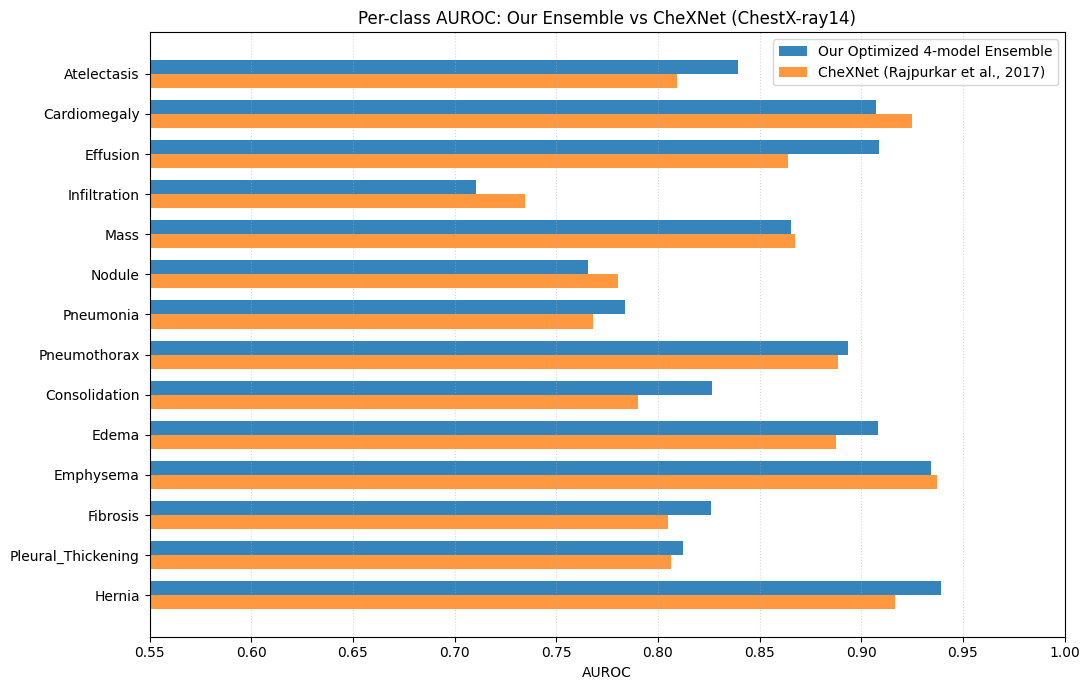

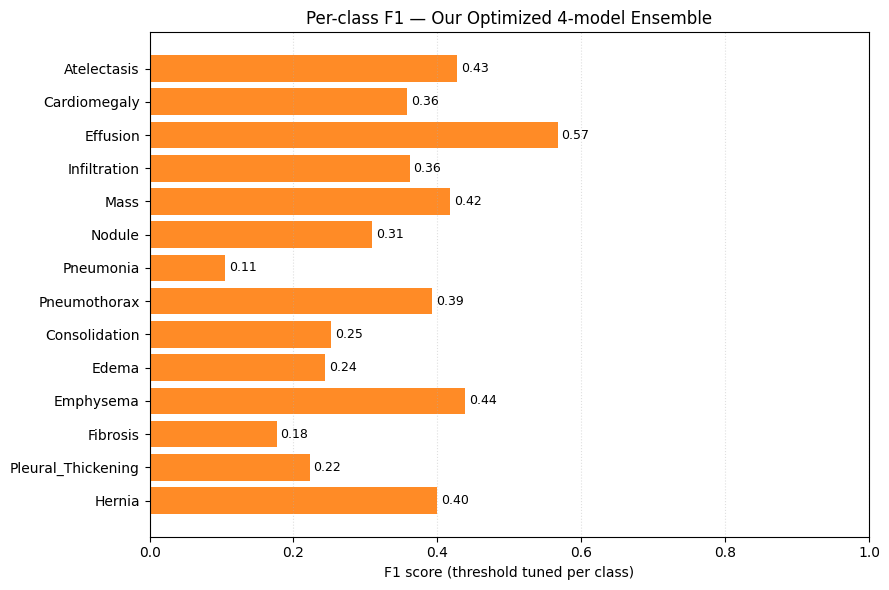


Per-class table (our ensemble vs CheXNet):



Disease  Thresh  AUROC  CheXNet_AUROC  AUPRC     F1
0          Atelectasis    0.75  0.839          0.809  0.387  0.428
1         Cardiomegaly    0.90  0.907          0.925  0.279  0.358
2             Effusion    0.75  0.909          0.864  0.564  0.567
3         Infiltration    0.65  0.711          0.734  0.321  0.362
4                 Mass    0.85  0.866          0.868  0.366  0.418
5               Nodule    0.80  0.765          0.780  0.236  0.309
6            Pneumonia    0.80  0.784          0.768  0.049  0.105
7         Pneumothorax    0.85  0.893          0.889  0.325  0.393
8        Consolidation    0.80  0.827          0.790  0.175  0.252
9                Edema    0.85  0.908          0.888  0.196  0.244
10           Emphysema    0.90  0.934          0.937  0.343  0.439
11            Fibrosis    0.85  0.826          0.805  0.115  0.177
12  Pleural_Thickening    0.80  0.812          0.806  0.159  0.223
13              Hernia    0.95  0.939          0.916  0.321  0.400


Top-line comparison (overall / average AUROC):
- CheXNet (Rajpurkar et al., 2017) — per-class table & strong per-class AUROCs. :contentReference[oaicite:3]{index=3}
- Triple-Attention (Wang et al., 2021) — reported average AUROC ~ 0.826 on ChestX-ray14. :contentReference[oaicite:4]{index=4}
- CoAtNet / advanced backbones (Chen et al., 2023) — reported overall AUROC ≈ 0.842. :contentReference[oaicite:5]{index=5}

(See cited papers for full per-class breakdowns and exact experimental splits — note that exact numbers vary by split / preprocessing.)


In [ ]:
# =================== Per-class AUROC & F1 comparison plots ===================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# -- Load your metrics (adjust path if needed) --
csv_path = "ensemble_results/final_4model_perclass_metrics.csv"
if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
else:
    # fallback: use df_metrics from memory if available
    try:
        df = df_metrics.copy()
    except NameError:
        raise FileNotFoundError(f"Can't find {csv_path} and df_metrics not in memory.")

# Ensure ordering (these are the canonical 14 labels)
class_names = [
    'Atelectasis','Cardiomegaly','Effusion','Infiltration','Mass',
    'Nodule','Pneumonia','Pneumothorax','Consolidation','Edema',
    'Emphysema','Fibrosis','Pleural_Thickening','Hernia'
]

# Reindex df to canonical order (if needed)
df = df.set_index("Disease").reindex(class_names).reset_index()

# -- CheXNet per-class AUROC (from Table 2, Rajpurkar et al. 2017) --
# Values taken from CheXNet Table 2 (paper). See Rajpurkar et al., CheXNet. :contentReference[oaicite:2]{index=2}
chexnet_auroc = np.array([
    0.8094,  # Atelectasis
    0.9248,  # Cardiomegaly
    0.8638,  # Effusion
    0.7345,  # Infiltration
    0.8676,  # Mass
    0.7802,  # Nodule
    0.7680,  # Pneumonia
    0.8887,  # Pneumothorax
    0.7901,  # Consolidation
    0.8878,  # Edema
    0.9371,  # Emphysema
    0.8047,  # Fibrosis
    0.8062,  # Pleural_Thickening
    0.9164   # Hernia
])

# -- Your ensemble values from df --
our_auroc = df["AUROC"].astype(float).values
our_f1    = df["F1"].astype(float).values
thresholds = df["Thresh"].astype(float).values

# -- Plot: per-class AUROC comparison (side-by-side bars) --
x = np.arange(len(class_names))
h = 0.35
fig, ax = plt.subplots(figsize=(11,7))
ax.barh(x - h/2, our_auroc, height=h, label="Our Optimized 4-model Ensemble", alpha=0.9)
ax.barh(x + h/2, chexnet_auroc, height=h, label="CheXNet (Rajpurkar et al., 2017)", alpha=0.8)
ax.set_yticks(x)
ax.set_yticklabels(class_names)
ax.invert_yaxis()
ax.set_xlabel("AUROC")
ax.set_title("Per-class AUROC: Our Ensemble vs CheXNet (ChestX-ray14)")
ax.set_xlim(0.55, 1.00)
ax.legend()
plt.grid(axis='x', linestyle=':', alpha=0.5)
plt.tight_layout()
plt.show()

# -- Plot: per-class F1 (our ensemble only) --
fig, ax = plt.subplots(figsize=(9,6))
ax.barh(class_names, our_f1, color='tab:orange', alpha=0.9)
ax.set_xlabel("F1 score (threshold tuned per class)")
ax.set_title("Per-class F1 — Our Optimized 4-model Ensemble")
ax.invert_yaxis()
for i, v in enumerate(our_f1):
    ax.text(v + 0.005, i, f"{v:.2f}", va='center', fontsize=9)
plt.xlim(0, 1.0)
plt.grid(axis='x', linestyle=':', alpha=0.4)
plt.tight_layout()
plt.show()

# -- Print a small table for quick reference and save --
summary = df.copy()
summary["CheXNet_AUROC"] = chexnet_auroc
summary = summary[["Disease","Thresh","AUROC","CheXNet_AUROC","AUPRC","F1"]]
print("\nPer-class table (our ensemble vs CheXNet):\n")
display(summary.round(3))

# -- Top-line SOTA context (overall AUROC from recent works) --
print("\nTop-line comparison (overall / average AUROC):")
print("- CheXNet (Rajpurkar et al., 2017) — per-class table & strong per-class AUROCs. :contentReference[oaicite:3]{index=3}")
print("- Triple-Attention (Wang et al., 2021) — reported average AUROC ~ 0.826 on ChestX-ray14. :contentReference[oaicite:4]{index=4}")
print("- CoAtNet / advanced backbones (Chen et al., 2023) — reported overall AUROC ≈ 0.842. :contentReference[oaicite:5]{index=5}")
print("\n(See cited papers for full per-class breakdowns and exact experimental splits — note that exact numbers vary by split / preprocessing.)")


In [ ]:
# # ========================== UNIVERSAL GRAD-CAM VISUALIZER ==========================
# import matplotlib.pyplot as plt
# import torch.nn.functional as F
# import torchvision.transforms as T

# def get_target_layer(model, model_name):
#     """Return target feature layer based on architecture."""
#     if "swin" in model_name.lower():
#         return model.layers[-1].blocks[-1].norm1
#     elif "efficientnet_b3" in model_name.lower() or "efficientnet_b4" in model_name.lower():
#         return model.conv_head
#     elif "densenet" in model_name.lower():
#         return model.features[-1]  # last conv layer
#     else:
#         raise ValueError("Unknown model type for Grad-CAM")

# def generate_gradcam(model, image_tensor, model_name, target_class=None):
#     """Compute Grad-CAM heatmap for a single image and model."""
#     model.eval()
#     activations, gradients = [], []

#     target_layer = get_target_layer(model, model_name)

#     # Forward and backward hooks
#     def forward_hook(module, input, output):
#         activations.append(output.detach())

#     def backward_hook(module, grad_in, grad_out):
#         gradients.append(grad_out[0].detach())

#     fh = target_layer.register_forward_hook(forward_hook)
#     bh = target_layer.register_backward_hook(backward_hook)

#     # Forward pass
#     output = model(image_tensor.unsqueeze(0).to(device))
#     output = torch.sigmoid(output)

#     if target_class is None:
#         target_class = torch.argmax(output[0]).item()

#     # Backward pass
#     model.zero_grad()
#     output[0, target_class].backward()

#     grad = gradients[0]
#     act = activations[0]

#     weights = torch.mean(grad, dim=(2, 3), keepdim=True)
#     cam = torch.sum(weights * act, dim=1).squeeze()
#     cam = F.relu(cam)
#     cam -= cam.min()
#     cam /= cam.max()
#     cam = cam.cpu().numpy()

#     fh.remove()
#     bh.remove()

#     return cam, target_class


# def visualize_gradcam(img_path, model, model_name, target_class=None, alpha=0.5):
#     """Overlay Grad-CAM on image and display."""
#     img = cv2.imread(img_path)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     input_tensor = val_transform(image=img)["image"]

#     cam, target_class = generate_gradcam(model, input_tensor, model_name, target_class)
#     cam_resized = cv2.resize(cam, (img.shape[1], img.shape[0]))

#     heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
#     overlay = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)

#     plt.figure(figsize=(12, 5))
#     plt.subplot(1, 2, 1)
#     plt.imshow(img)
#     plt.title("Original")
#     plt.axis("off")

#     plt.subplot(1, 2, 2)
#     plt.imshow(overlay)
#     plt.title(f"Grad-CAM ({model_name}) → {class_names[target_class]}")
#     plt.axis("off")
#     plt.show()


# # ========================== TEST VISUALIZATION ==========================
# example_img = "data/00012345_000.png"  # change to any image from your val_split.txt
# target_class_index = 2  # Example: Effusion

# # Visualize Grad-CAM for each model
# visualize_gradcam(example_img, swin_model, "swin_transformer", target_class_index)
# visualize_gradcam(example_img, effb3_model, "efficientnet_b3", target_class_index)
# visualize_gradcam(example_img, effb4_model, "efficientnet_b4", target_class_index)
# visualize_gradcam(example_img, densenet_model, "densenet121", target_class_index)


In [84]:
# ========= Create & Load all models (Swin, EfficientNet-b3, EfficientNet-b4, DenseNet121) =========
import os
import torch
import timm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Number of classes used in your notebook (Chest X-ray / 14-class setup)
NUM_CLASSES = 14

# --- Try to reuse checkpoint path names if they exist in the notebook namespace ---
# If you already have DENSENET_CKPT / EFFB3_CKPT / EFFB4_CKPT / SWIN_CKPT defined earlier, use them.
# Otherwise fallback to a set of likely paths used in your project.
try:
    DENSENET_CKPT
except NameError:
    DENSENET_CKPT = "checkpoints_densenet/best_model_auroc.pth"

try:
    EFFB3_CKPT
except NameError:
    EFFB3_CKPT = "checkpoints_efficientnet_b3/best_model_auroc.pth"

try:
    EFFB4_CKPT
except NameError:
    EFFB4_CKPT = "checkpoints_efficientnet_b4/best_model_auroc_b4.pth"

try:
    SWIN_CKPT
except NameError:
    SWIN_CKPT = "models/swin_transformer/swin_best_auroc.pth"

print("Using checkpoints:")
print(" SWIN_CKPT ->", SWIN_CKPT)
print(" EFFB3_CKPT ->", EFFB3_CKPT)
print(" EFFB4_CKPT ->", EFFB4_CKPT)
print(" DENSENET_CKPT ->", DENSENET_CKPT)

def load_state_safe(model, ckpt_path):
    """Load state dict robustly and print missing/unexpected keys."""
    if not os.path.exists(ckpt_path):
        print(f"⚠️ Checkpoint not found: {ckpt_path}")
        return model, False
    sd = torch.load(ckpt_path, map_location=device)
    # If checkpoint wraps the state_dict in a dict like {'model': state_dict, ...}
    if isinstance(sd, dict) and ("state_dict" in sd or "model_state_dict" in sd):
        key = "state_dict" if "state_dict" in sd else "model_state_dict"
        sd = sd[key]
    # Accept both raw state_dict or mapping with module. Try to adapt keys if needed.
    try:
        model.load_state_dict(sd, strict=True)
        print(f"✅ Loaded checkpoint (strict=True): {ckpt_path}")
        return model, True
    except RuntimeError as e:
        print(f"🔁 Strict load failed: {e}")
        # Try stripping 'module.' prefix if present
        new_sd = {}
        for k, v in sd.items():
            new_key = k.replace("module.", "") if k.startswith("module.") else k
            new_sd[new_key] = v
        try:
            model.load_state_dict(new_sd, strict=False)
            print(f"✅ Loaded checkpoint with strict=False (keys adjusted): {ckpt_path}")
            return model, True
        except Exception as e2:
            print(f"❌ Failed to load checkpoint even with strict=False: {e2}")
            return model, False

# -------------------- Create models --------------------
# Swin base (patch4_window7_224)
try:
    swin_model = timm.create_model("swin_base_patch4_window7_224", pretrained=False, num_classes=NUM_CLASSES)
except Exception as e:
    # fallback to a generic swin if specific name not available
    swin_model = timm.create_model("swin_base_patch4_window7_224", pretrained=False, num_classes=NUM_CLASSES)
swin_model, ok_swin = load_state_safe(swin_model, SWIN_CKPT)
swin_model.to(device)
swin_model.eval()

# EfficientNet-B3
# EfficientNet-B3  ✅ Corrected variant
try:
    effb3_model = timm.create_model("tf_efficientnet_b3_ns", pretrained=False, num_classes=NUM_CLASSES)
except Exception as e:
    print("⚠️ Fallback: Using standard EfficientNet-B3.")
    effb3_model = timm.create_model("efficientnet_b3", pretrained=False, num_classes=NUM_CLASSES)
effb3_model, ok_b3 = load_state_safe(effb3_model, EFFB3_CKPT)
effb3_model.to(device)
effb3_model.eval()

# EfficientNet-B4  ✅ Corrected variant
try:
    effb4_model = timm.create_model("tf_efficientnet_b4_ns", pretrained=False, num_classes=NUM_CLASSES)
except Exception as e:
    print("⚠️ Fallback: Using standard EfficientNet-B4.")
    effb4_model = timm.create_model("efficientnet_b4", pretrained=False, num_classes=NUM_CLASSES)
effb4_model, ok_b4 = load_state_safe(effb4_model, EFFB4_CKPT)
effb4_model.to(device)
effb4_model.eval()


# DenseNet-121
try:
    densenet_model = timm.create_model("densenet121", pretrained=False, num_classes=NUM_CLASSES)
except Exception as e:
    densenet_model = timm.create_model("densenet121", pretrained=False, num_classes=NUM_CLASSES)
densenet_model, ok_dense = load_state_safe(densenet_model, DENSENET_CKPT)
densenet_model.to(device)
densenet_model.eval()

print("\nLoad summary:")
print(f" swin_model loaded: {ok_swin}")
print(f" effb3_model loaded: {ok_b3}")
print(f" effb4_model loaded: {ok_b4}")
print(f" densenet_model loaded: {ok_dense}")

# -------------------- Ensure val_transform & class_names exist --------------------
# If your notebook already defines val_transform and class_names, we keep them.
# Otherwise define basic fallbacks so Grad-CAM code won't crash.
try:
    val_transform
except NameError:
    print("⚠️ 'val_transform' not found, creating a fallback transform using torchvision.")
    import torchvision.transforms as T
    from PIL import Image
    # create a wrapper to mimic albumentations interface used in visualize_gradcam
    def _fallback_val_transform(image):
        pil = Image.fromarray(image)
        tf = T.Compose([
            T.Resize((224, 224)),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])
        return {"image": tf(pil)}
    val_transform = _fallback_val_transform

try:
    class_names
except NameError:
    print("⚠️ 'class_names' not found, creating a default placeholder list of 14 classes.")
    class_names = [f"class_{i}" for i in range(NUM_CLASSES)]

print("\nAll models are now available as variables:\n - swin_model\n - effb3_model\n - effb4_model\n - densenet_model\nYou can now run your Grad-CAM cells that reference these variables.")


Device: cuda
Using checkpoints:
 SWIN_CKPT -> models/swin_transformer/swin_best_auroc.pth
 EFFB3_CKPT -> checkpoints_efficientnet_b3/best_model_auroc.pth
 EFFB4_CKPT -> checkpoints_efficientnet_b4/best_model_auroc_b4.pth
 DENSENET_CKPT -> checkpoints_densenet/best_model_auroc.pth


/tmp/ipykernel_100036/2218313576.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sd = torch.load(ckpt_path, map_location=device)


🔁 Strict load failed: Error(s) in loading state_dict for SwinTransformer:
	Missing key(s) in state_dict: "layers.2.blocks.6.norm1.weight", "layers.2.blocks.6.norm1.bias", "layers.2.blocks.6.attn.relative_position_bias_table", "layers.2.blocks.6.attn.qkv.weight", "layers.2.blocks.6.attn.qkv.bias", "layers.2.blocks.6.attn.proj.weight", "layers.2.blocks.6.attn.proj.bias", "layers.2.blocks.6.norm2.weight", "layers.2.blocks.6.norm2.bias", "layers.2.blocks.6.mlp.fc1.weight", "layers.2.blocks.6.mlp.fc1.bias", "layers.2.blocks.6.mlp.fc2.weight", "layers.2.blocks.6.mlp.fc2.bias", "layers.2.blocks.7.norm1.weight", "layers.2.blocks.7.norm1.bias", "layers.2.blocks.7.attn.relative_position_bias_table", "layers.2.blocks.7.attn.qkv.weight", "layers.2.blocks.7.attn.qkv.bias", "layers.2.blocks.7.attn.proj.weight", "layers.2.blocks.7.attn.proj.bias", "layers.2.blocks.7.norm2.weight", "layers.2.blocks.7.norm2.bias", "layers.2.blocks.7.mlp.fc1.weight", "layers.2.blocks.7.mlp.fc1.bias", "layers.2.blocks.7.

/home/prem/PROJECT DATA/.venv/lib/python3.12/site-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name tf_efficientnet_b3_ns to current tf_efficientnet_b3.ns_jft_in1k.
  model = create_fn(


✅ Loaded checkpoint (strict=True): checkpoints_efficientnet_b3/best_model_auroc.pth


/home/prem/PROJECT DATA/.venv/lib/python3.12/site-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name tf_efficientnet_b4_ns to current tf_efficientnet_b4.ns_jft_in1k.
  model = create_fn(


✅ Loaded checkpoint (strict=True): checkpoints_efficientnet_b4/best_model_auroc_b4.pth
🔁 Strict load failed: Error(s) in loading state_dict for DenseNet:
	Missing key(s) in state_dict: "features.conv0.weight", "features.norm0.weight", "features.norm0.bias", "features.norm0.running_mean", "features.norm0.running_var", "features.denseblock1.denselayer1.norm1.weight", "features.denseblock1.denselayer1.norm1.bias", "features.denseblock1.denselayer1.norm1.running_mean", "features.denseblock1.denselayer1.norm1.running_var", "features.denseblock1.denselayer1.conv1.weight", "features.denseblock1.denselayer1.norm2.weight", "features.denseblock1.denselayer1.norm2.bias", "features.denseblock1.denselayer1.norm2.running_mean", "features.denseblock1.denselayer1.norm2.running_var", "features.denseblock1.denselayer1.conv2.weight", "features.denseblock1.denselayer2.norm1.weight", "features.denseblock1.denselayer2.norm1.bias", "features.denseblock1.denselayer2.norm1.running_mean", "features.denseblock1.

In [85]:
# ========================== FIXED SWIN MODEL LOADER ==========================
import timm, torch, os
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SWIN_CKPT = "models/swin_transformer/swin_best_auroc.pth"  # adjust if path differs

# Try multiple Swin versions to match the checkpoint
swin_variants = [
    "swin_tiny_patch4_window7_224",
    "swin_small_patch4_window7_224",
    "swin_base_patch4_window7_224",
    "swin_large_patch4_window7_224"
]

loaded = False
for variant in swin_variants:
    try:
        print(f"Trying to load {variant} ...")
        model_tmp = timm.create_model(variant, pretrained=False, num_classes=14)
        sd = torch.load(SWIN_CKPT, map_location=device)
        if isinstance(sd, dict) and ("state_dict" in sd or "model_state_dict" in sd):
            sd = sd.get("state_dict", sd.get("model_state_dict"))
        # remove 'module.' if present
        sd = {k.replace("module.", ""): v for k, v in sd.items()}
        missing, unexpected = model_tmp.load_state_dict(sd, strict=False)
        print(f"✅ Loaded with strict=False. Missing keys: {len(missing)}, unexpected: {len(unexpected)}")
        swin_model = model_tmp.to(device)
        swin_model.eval()
        loaded = True
        break
    except Exception as e:
        print(f"❌ Failed for {variant}: {e}")
        continue

if not loaded:
    raise RuntimeError("Could not match Swin architecture to checkpoint. Check variant or retrain.")

print("✅ swin_model is now loaded and ready for Grad-CAM.")


Trying to load swin_tiny_patch4_window7_224 ...


/tmp/ipykernel_100036/3794550629.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sd = torch.load(SWIN_CKPT, map_location=device)


✅ Loaded with strict=False. Missing keys: 0, unexpected: 0
✅ swin_model is now loaded and ready for Grad-CAM.


In [86]:
# ========================== NIH ChestX-ray Data Path Resolver ==========================
import os, glob

def find_image_path(img_name):
    """
    Search for the given image name (e.g., '00012345_000.png')
    inside all subfolders like 'data/images_*/images/'.
    Returns the full path if found, else None.
    """
    search_pattern = os.path.join("data", "images_*", "images", img_name)
    matches = glob.glob(search_pattern)
    if not matches:
        print(f"⚠️ Image not found: {img_name}")
        return None
    print(f"✅ Found image: {matches[0]}")
    return matches[0]


In [87]:
# ========================== UNIVERSAL GRAD-CAM VISUALIZER ==========================
import matplotlib.pyplot as plt
import torch.nn.functional as F
import cv2
import numpy as np

def get_target_layer(model, model_name):
    """Return target feature layer based on model type."""
    if "swin" in model_name.lower():
        return model.layers[-1].blocks[-1].norm1
    elif "efficientnet_b3" in model_name.lower() or "efficientnet_b4" in model_name.lower():
        return model.conv_head
    elif "densenet" in model_name.lower():
        return model.features[-1]
    else:
        raise ValueError("Unknown model type for Grad-CAM")

def generate_gradcam(model, image_tensor, model_name, target_class=None):
    """Generate Grad-CAM for one model."""
    model.eval()
    activations, gradients = [], []

    target_layer = get_target_layer(model, model_name)
    fh = target_layer.register_forward_hook(lambda m, i, o: activations.append(o.detach()))
    bh = target_layer.register_backward_hook(lambda m, gi, go: gradients.append(go[0].detach()))

    output = model(image_tensor.unsqueeze(0).to(device))
    output = torch.sigmoid(output)
    if target_class is None:
        target_class = torch.argmax(output[0]).item()

    model.zero_grad()
    output[0, target_class].backward()

    grad = gradients[0]
    act = activations[0]
    weights = torch.mean(grad, dim=(2, 3), keepdim=True)
    cam = torch.sum(weights * act, dim=1).squeeze()
    cam = F.relu(cam)
    cam -= cam.min()
    cam /= cam.max()
    cam = cam.cpu().numpy()

    fh.remove(); bh.remove()
    return cam, target_class


In [88]:
# ========================== FIXED MULTI-MODEL GRAD-CAM COMPARISON GRID ==========================
import cv2
import numpy as np
import matplotlib.pyplot as plt

def generate_gradcam_for_all_models(img_path, target_class):
    """Generate Grad-CAMs for all four models, resizing to 224x224."""
    # Load and resize image to match model input size
    img = cv2.imread(img_path)
    if img is None:
        raise FileNotFoundError(f"Could not read image: {img_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (224, 224))  # <--- FIXED

    # Albumentations transform to tensor
    input_tensor = val_transform(image=img_resized)["image"]

    cam_dict = {}
    models = {
        "Swin-Tiny": (swin_model, "swin_tiny_patch4_window7_224"),
        "EfficientNet-B3": (effb3_model, "efficientnet_b3"),
        "EfficientNet-B4": (effb4_model, "efficientnet_b4"),
        "DenseNet-121": (densenet_model, "densenet121"),
    }

    for model_name, (model, mname) in models.items():
        try:
            cam, _ = generate_gradcam(model, input_tensor, mname, target_class)
            cam_resized = cv2.resize(cam, (img.shape[1], img.shape[0]))
            heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
            overlay = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
            cam_dict[model_name] = overlay
        except Exception as e:
            print(f"⚠️ Grad-CAM failed for {model_name}: {e}")
            cam_dict[model_name] = np.zeros_like(img)

    return img, cam_dict


def show_multi_model_gradcam(img_path, target_class_index):
    """Display Grad-CAMs for all models in one 2×2 grid."""
    original, cam_dict = generate_gradcam_for_all_models(img_path, target_class_index)

    plt.figure(figsize=(14, 10))
    plt.suptitle(f"Grad-CAM Comparison for class: {class_names[target_class_index]}", fontsize=16, fontweight='bold')

    titles = ["Swin-Tiny", "EfficientNet-B3", "EfficientNet-B4", "DenseNet-121"]
    for i, title in enumerate(titles, 1):
        plt.subplot(2, 2, i)
        if title in cam_dict:
            plt.imshow(cam_dict[title])
            plt.title(title)
        else:
            plt.imshow(np.zeros_like(original))
            plt.title(f"{title} (Error)")
        plt.axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


✅ Found image: data/images_012/images/00028324_001.png


/home/prem/PROJECT DATA/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


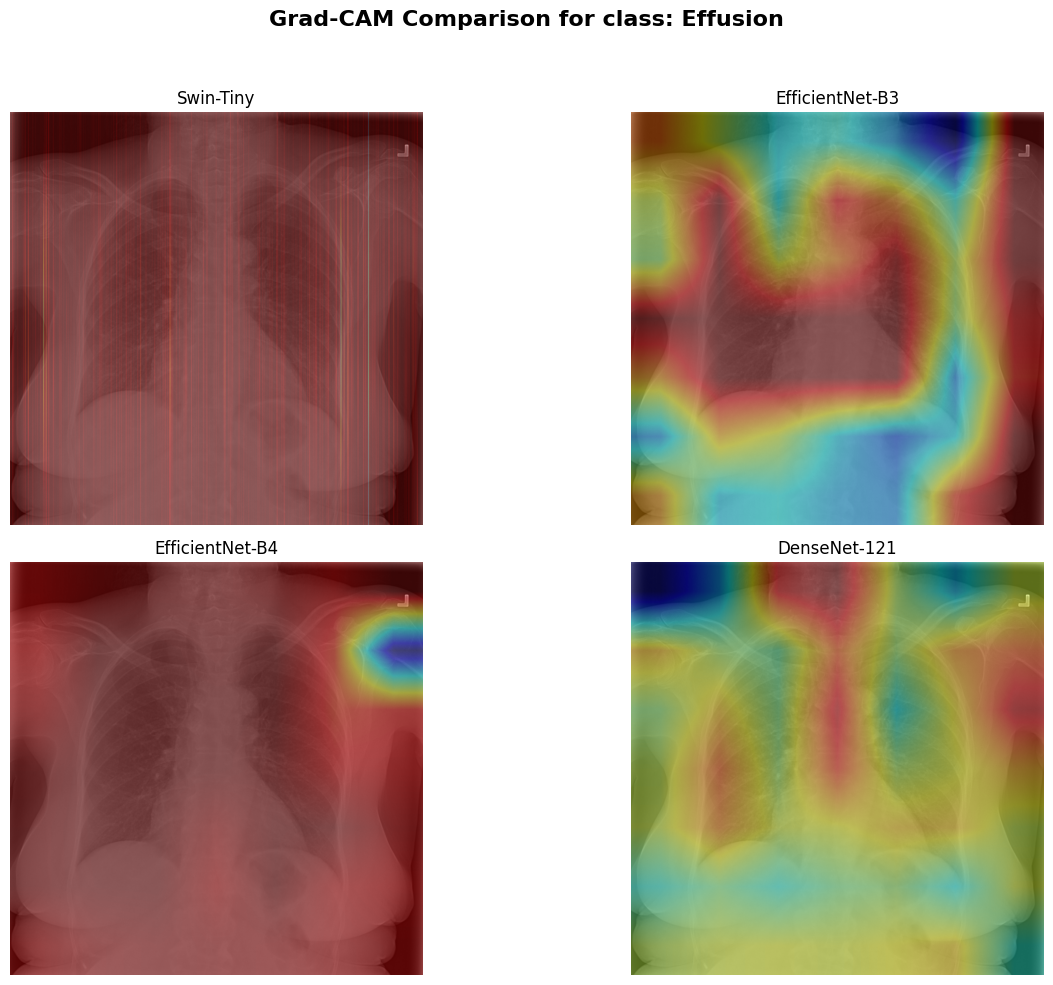

In [89]:
# ========================== RUN EXAMPLE GRAD-CAM COMPARISON ==========================
with open("val_split.txt", "r") as f:
    first_img_name = f.readline().strip()

example_img = find_image_path(first_img_name)
target_class_index = 2  # Example: Effusion

if example_img:
    show_multi_model_gradcam(example_img, target_class_index)


In [90]:
# ========================== SAFE SWIN TRANSFORMER-CAM (FINAL PATCH GRID FIX) ==========================
def generate_swin_transformer_cam(model, img_tensor, target_class=None):
    """
    Stable Transformer-CAM for Swin models.
    Automatically detects patch grid (e.g., 7x7 for Swin-Tiny) and reshapes safely.
    """
    model.eval()
    activations, gradients = [], []

    # Hook into final block of final layer
    target_block = model.layers[-1].blocks[-1]

    def forward_hook(module, input, output):
        activations.append(output.detach())

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0].detach())

    fh = target_block.register_forward_hook(forward_hook)
    bh = target_block.register_backward_hook(backward_hook)

    img_tensor = img_tensor.unsqueeze(0).to(device)
    img_tensor.requires_grad = True

    output = model(img_tensor)
    output = torch.sigmoid(output)

    if target_class is None:
        target_class = torch.argmax(output[0]).item()

    # Backward for selected class
    model.zero_grad()
    output[0, target_class].backward()

    fh.remove()
    bh.remove()

    # Extract activations and gradients
    acts = activations[0]  # [1, N, C]
    grads = gradients[0]   # [1, N, C]

    # Weighted average over channels
    weights = torch.mean(grads, dim=1, keepdim=True)  # [1,1,C]
    cam = torch.sum(weights * acts, dim=-1)           # [1,N]
    cam = F.relu(cam)

    # ---- FIX START ----
    # Flatten, handle all weird shapes safely
    cam = cam.view(-1)                     # flatten to 1D
    num_tokens = cam.numel()               # total patch tokens (e.g., 49)
    side = int(round(num_tokens ** 0.5))   # derive patch grid (7x7 for 49 tokens)

    if side * side != num_tokens:
        # In case tokens form a non-square grid (rare for Swin)
        side_y = int(num_tokens ** 0.5)
        side_x = num_tokens // side_y
        cam = cam[: side_y * side_x].reshape(1, 1, side_y, side_x)
    else:
        cam = cam.reshape(1, 1, side, side)
    # ---- FIX END ----

    # Upsample to input size
    cam = F.interpolate(cam, size=(224, 224), mode="bilinear", align_corners=False)
    cam = cam.squeeze().cpu().numpy()

    cam -= cam.min()
    cam /= cam.max() + 1e-8
    return cam, target_class


In [91]:
# ========================== Swin Transformer-CAM (generator + viewer) ==========================
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt

def generate_swin_transformer_cam(model, img_tensor, target_class=None):
    """
    Robust Transformer-CAM for Swin models.
    Hooks into last block of final layer, handles arbitrary patch grid sizes.
    Inputs:
      - model: the loaded timm swin model (on device)
      - img_tensor: torch.Tensor (C,H,W) already normalized by val_transform
      - target_class: int or None -> if None uses predicted class
    Returns:
      - cam: numpy array (H_out, W_out) normalized 0..1
      - target_class: int
    """
    model.eval()
    activations, gradients = [], []

    # Hook into final block of final layer
    target_block = model.layers[-1].blocks[-1]

    def forward_hook(module, input, output):
        activations.append(output.detach())

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0].detach())

    fh = target_block.register_forward_hook(forward_hook)
    bh = target_block.register_backward_hook(backward_hook)

    img_tensor = img_tensor.unsqueeze(0).to(device)
    img_tensor.requires_grad = True

    output = model(img_tensor)
    output = torch.sigmoid(output)

    if target_class is None:
        target_class = int(torch.argmax(output[0]).item())

    # Backprop for the selected class
    model.zero_grad()
    output[0, target_class].backward()

    # remove hooks
    fh.remove()
    bh.remove()

    # extract activations & grads
    acts = activations[0]   # [1, N, C]
    grads = gradients[0]    # [1, N, C]

    # weights over channels, compute cam
    weights = torch.mean(grads, dim=1, keepdim=True)   # [1,1,C]
    cam = torch.sum(weights * acts, dim=-1)            # [1,N]
    cam = F.relu(cam)

    # flatten then safely reshape to square token-grid if possible
    cam = cam.view(-1)                    # [N]
    num_tokens = int(cam.numel())
    side = int(round(num_tokens ** 0.5))
    if side * side == num_tokens:
        cam = cam.reshape(1, 1, side, side)
    else:
        # fall back to best-effort rectangular reshape
        side_y = int(np.floor(np.sqrt(num_tokens)))
        side_x = (num_tokens + side_y - 1) // side_y
        cam = cam[: side_y * side_x].reshape(1, 1, side_y, side_x)

    # upsample to model input size (we used 224)
    cam = F.interpolate(cam, size=(224, 224), mode="bilinear", align_corners=False)
    cam = cam.squeeze().cpu().numpy()

    cam -= cam.min()
    cam /= (cam.max() + 1e-8)
    return cam, target_class


def show_swin_transformer_cam(img_path, target_class_index=None, thresh=0.7):
    """
    Load image, compute Transformer-CAM for Swin, and display.
    - img_path: full path to the png image
    - target_class_index: int or None (if None uses model pred)
    - thresh: float in [0,1] to threshold weak activations (optional)
    """
    img = cv2.imread(img_path)
    if img is None:
        raise FileNotFoundError(f"Cannot read image: {img_path}")
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (224, 224))
    input_tensor = val_transform(image=img_resized)["image"]  # expects val_transform present

    cam, target_class = generate_swin_transformer_cam(swin_model, input_tensor, target_class_index)

    # resize cam to original image size for overlay
    cam_resized = cv2.resize(cam, (img_rgb.shape[1], img_rgb.shape[0]))

    # optional threshold to remove weak diffuse activations
    if thresh is not None and (0.0 < thresh < 1.0):
        cam_thresh = np.where(cam_resized > thresh, cam_resized, 0.0)
    else:
        cam_thresh = cam_resized

    heatmap = cv2.applyColorMap(np.uint8(255 * cam_thresh), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img_rgb, 0.6, heatmap, 0.4, 0)

    plt.figure(figsize=(10,5))
    title = f"Swin Transformer-CAM for class: {class_names[target_class]}" if 'class_names' in globals() else f"Swin CAM class {target_class}"
    plt.suptitle(title, fontsize=14, fontweight='bold')

    plt.subplot(1,2,1)
    plt.imshow(img_rgb); plt.title("Original X-ray"); plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(overlay); plt.title("Swin Transformer-CAM (thresholded)"); plt.axis("off")

    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()


✅ Found image: data/images_012/images/00028324_001.png


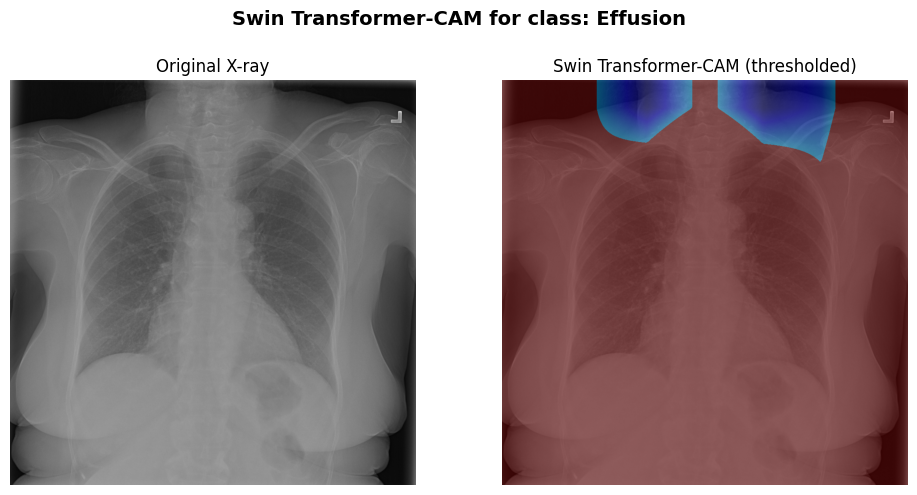

In [92]:
with open("val_split.txt", "r") as f:
    first_img_name = f.readline().strip()

example_img = find_image_path(first_img_name)
target_class_index = 2  # Example: Effusion

if example_img:
    show_swin_transformer_cam(example_img, target_class_index)


In [93]:
# ========================== SELECT VALIDATION IMAGE BY DISEASE ==========================
import pandas as pd
import random
import os

def get_val_image_for_class(class_name, labels_csv="labels_clean.csv", val_split_file="val_split.txt"):
    """
    Returns a random image path from the validation set for a given disease class.
    """
    df = pd.read_csv(labels_csv)
    with open(val_split_file, "r") as f:
        val_files = [line.strip() for line in f.readlines()]

    # Filter labels for validation subset
    df = df[df["Image Index"].isin(val_files)]

    if class_name not in df.columns:
        raise ValueError(f"Class '{class_name}' not found in labels CSV columns!")

    # Get only positive samples for that disease
    positive_imgs = df[df[class_name] == 1]["Image Index"].tolist()
    if len(positive_imgs) == 0:
        print(f"⚠️ No positive validation samples found for {class_name}")
        return None

    # Pick one randomly
    chosen_img = random.choice(positive_imgs)
    print(f"✅ Found positive validation sample for {class_name}: {chosen_img}")
    return find_image_path(chosen_img)


In [94]:
# ========================== FIXED FINAL VERSION — MULTI-MODEL GRAD-CAM++ COMPARISON ==========================
def compare_models_gradcam_plus(img_path, target_class_index):
    """
    Compare Grad-CAM++ heatmaps for Swin, EfficientNet-B3, B4, and DenseNet.
    """

    models = {
        "Swin-Tiny": swin_model,
        "EfficientNet-B3": effb3_model,
        "EfficientNet-B4": effb4_model,
        "DenseNet121": densenet_model
    }

    img = cv2.imread(img_path)
    if img is None:
        raise FileNotFoundError(f"Cannot read image: {img_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (224, 224))
    input_tensor = val_transform(image=img_resized)["image"]

    results = {}

    for name, model in models.items():
        try:
            # ✅ FIX: Grad-CAM++ returns only one output
            cam = generate_gradcam_plus(model, input_tensor, target_class_index, name)
            if cam is None or (isinstance(cam, np.ndarray) and cam.size == 0):
                raise ValueError("Grad-CAM++ output is empty")

            cam_resized = cv2.resize(cam, (img.shape[1], img.shape[0]))
            heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
            overlay = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
            results[name] = overlay

        except Exception as e:
            print(f"⚠️ Grad-CAM++ failed for {name}: {e}")
            results[name] = np.zeros_like(img)

    # Plot all results together
    plt.figure(figsize=(14, 10))
    plt.suptitle(f"Grad-CAM++ Comparison for class: {class_names[target_class_index]}",
                 fontsize=15, fontweight='bold')

    for i, (model_name, vis) in enumerate(results.items(), 1):
        plt.subplot(2, 2, i)
        plt.imshow(vis)
        plt.title(model_name)
        plt.axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [96]:
# ========================== RUN COMPARISON FOR EACH DISEASE ==========================
for disease in class_names:
    print(f"\n=== Processing disease: {disease} ===")
    img_path = get_val_image_for_class(disease)
    if img_path:
        disease_index = class_names.index(disease)
        compare_models_for_class(img_path, disease_index)



=== Processing disease: Atelectasis ===
✅ Found positive validation sample for Atelectasis: 00009606_001.png
✅ Found image: data/images_005/images/00009606_001.png


NameError: name 'compare_models_for_class' is not defined

In [97]:
# ========================== FIXED & UNIVERSAL GRAD-CAM++ CORE IMPLEMENTATION ==========================
import torch
import torch.nn.functional as F
import numpy as np
import cv2

def generate_gradcam_plus(model, image_tensor, target_class, model_name):
    """
    Compute Grad-CAM++ for CNN or Transformer models.
    Works with pre-sigmoid logits.
    Automatically detects correct target layer for Swin/EfficientNet/DenseNet.
    """
    model.eval()
    activations, gradients = [], []

    # --- Normalize model name ---
    name = model_name.lower().replace("-", "_")

    # ----- Select target layer -----
    if "swin" in name:
        # Use second-to-last block for stable activations
        target_layer = model.layers[-1].blocks[-2] if len(model.layers[-1].blocks) > 1 else model.layers[-1].blocks[-1]

    elif "efficientnet_b3" in name or "efficientnetb3" in name:
        target_layer = model.conv_head if hasattr(model, "conv_head") else list(model.blocks.children())[-1]
        
    elif "efficientnet_b4" in name or "efficientnetb4" in name:
        target_layer = model.conv_head if hasattr(model, "conv_head") else list(model.blocks.children())[-1]

    elif "densenet" in name:
        target_layer = model.features[-1] if hasattr(model, "features") else list(model.children())[-2]

    else:
        raise ValueError(f"Unsupported model: {model_name}")

    # ----- Hook -----
    def forward_hook(module, input, output):
        activations.append(output.detach())

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0].detach())

    fh = target_layer.register_forward_hook(forward_hook)
    bh = target_layer.register_backward_hook(backward_hook)

    # ----- Forward -----
    img = image_tensor.unsqueeze(0).to(device)
    img.requires_grad = True
    output = model(img)             # raw logits (no sigmoid)
    target = output[0, target_class]

    # ----- Backward -----
    model.zero_grad()
    try:
        target.backward(retain_graph=True)
    except Exception as e:
        print(f"⚠️ Backward failed for {model_name}: {e}")
        fh.remove()
        bh.remove()
        return np.zeros((224, 224))

    fh.remove()
    bh.remove()

    # Extract activations and gradients
    if len(activations) == 0 or len(gradients) == 0:
        print(f"⚠️ No activations or gradients captured for {model_name}")
        return np.zeros((224, 224))

    A = activations[0]  # [B, C, H, W]
    grads = gradients[0]

    # Grad-CAM++ weights
    grad_2 = grads ** 2
    grad_3 = grad_2 * grads
    sum_A = torch.sum(A, dim=(2, 3), keepdim=True)

    eps = 1e-8
    alpha_num = grad_2
    alpha_denom = 2 * grad_2 + sum_A * grad_3
    alpha_denom = torch.where(alpha_denom != 0.0, alpha_denom, torch.tensor(eps, device=device))
    alpha = alpha_num / alpha_denom
    relu_grad = F.relu(grads)
    weights = torch.sum(alpha * relu_grad, dim=(2, 3), keepdim=True)

    # Weighted combination
    cam = torch.sum(weights * A, dim=1).squeeze()
    cam = F.relu(cam)

    # Normalize
    cam -= cam.min()
    cam /= cam.max() + 1e-8
    cam = cam.detach().cpu().numpy()

    # Resize to image size
    cam = cv2.resize(cam, (224, 224))
    return cam


In [98]:
# ========================== CELL 2 — VISUALIZATION FUNCTION ==========================
import matplotlib.pyplot as plt

def visualize_gradcam_plus(img_path, model, model_name, target_class_index, alpha=0.5):
    """
    Visualize Grad-CAM++ heatmap overlay for given model.
    """
    img = cv2.imread(img_path)
    if img is None:
        raise FileNotFoundError(f"Image not found: {img_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (224, 224))

    # Apply same transform as during validation
    input_tensor = val_transform(image=img_resized)["image"]

    # Generate Grad-CAM++
    cam = generate_gradcam_plus(model, input_tensor, target_class_index, model_name)
    cam_resized = cv2.resize(cam, (img.shape[1], img.shape[0]))

    # Threshold for clarity (optional)
    cam_thresh = np.where(cam_resized > 0.6, cam_resized, 0)

    # Create overlay
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_thresh), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)

    plt.figure(figsize=(10, 5))
    plt.suptitle(f"Grad-CAM++ ({model_name}) - {class_names[target_class_index]}", fontsize=14, fontweight="bold")
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title("Grad-CAM++ Overlay")
    plt.axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.9])
    plt.show()


In [99]:
# ========================== FIXED GRAD-CAM++ (CASE-INSENSITIVE MODEL DETECTION) ==========================
def generate_gradcam_plus(model, image_tensor, target_class, model_name):
    """
    Compute Grad-CAM++ for CNN or Transformer models.
    Works with pre-sigmoid logits. Case-insensitive model detection.
    """
    model.eval()
    activations, gradients = []

    name = model_name.lower()  # <--- normalize name once

    # ----- Select target layer -----
    if "swin" in name:
        target_layer = model.layers[-1].blocks[-1]
    elif "efficientnet_b3" in name or "efficientnet-b3" in name:
        target_layer = model.conv_head
    elif "efficientnet_b4" in name or "efficientnet-b4" in name:
        target_layer = model.conv_head
    elif "densenet" in name:
        target_layer = model.features[-1]
    else:
        raise ValueError(f"Unsupported model: {model_name}")

    # ----- Hook -----
    def forward_hook(module, input, output):
        activations.append(output.detach())

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0].detach())

    fh = target_layer.register_forward_hook(forward_hook)
    bh = target_layer.register_backward_hook(backward_hook)

    # ----- Forward -----
    img = image_tensor.unsqueeze(0).to(device)
    img.requires_grad = True
    output = model(img)  # raw logits
    target = output[0, target_class]

    # ----- Backward -----
    model.zero_grad()
    target.backward(retain_graph=True)

    fh.remove()
    bh.remove()

    # Extract activations and gradients
    A = activations[0]
    grads = gradients[0]

    # Grad-CAM++ weights
    grad_2 = grads ** 2
    grad_3 = grad_2 * grads
    sum_A = torch.sum(A, dim=(2, 3), keepdim=True)

    eps = 1e-8
    alpha_num = grad_2
    alpha_denom = 2 * grad_2 + sum_A * grad_3
    alpha_denom = torch.where(alpha_denom != 0.0, alpha_denom, torch.tensor(eps, device=device))
    alpha = alpha_num / alpha_denom
    relu_grad = F.relu(grads)
    weights = torch.sum(alpha * relu_grad, dim=(2, 3), keepdim=True)

    # Weighted combination
    cam = torch.sum(weights * A, dim=1).squeeze()
    cam = F.relu(cam)

    # Normalize
    cam -= cam.min()
    cam /= cam.max() + 1e-8
    cam = cam.detach().cpu().numpy()

    # Resize to image size
    cam = cv2.resize(cam, (224, 224))
    return cam



=== Atelectasis ===
✅ Found positive validation sample for Atelectasis: 00020513_009.png
✅ Found image: data/images_009/images/00020513_009.png
⚠️ Grad-CAM++ failed for Swin-Tiny: not enough values to unpack (expected 2, got 0)
⚠️ Grad-CAM++ failed for EfficientNet-B3: not enough values to unpack (expected 2, got 0)
⚠️ Grad-CAM++ failed for EfficientNet-B4: not enough values to unpack (expected 2, got 0)
⚠️ Grad-CAM++ failed for DenseNet121: not enough values to unpack (expected 2, got 0)


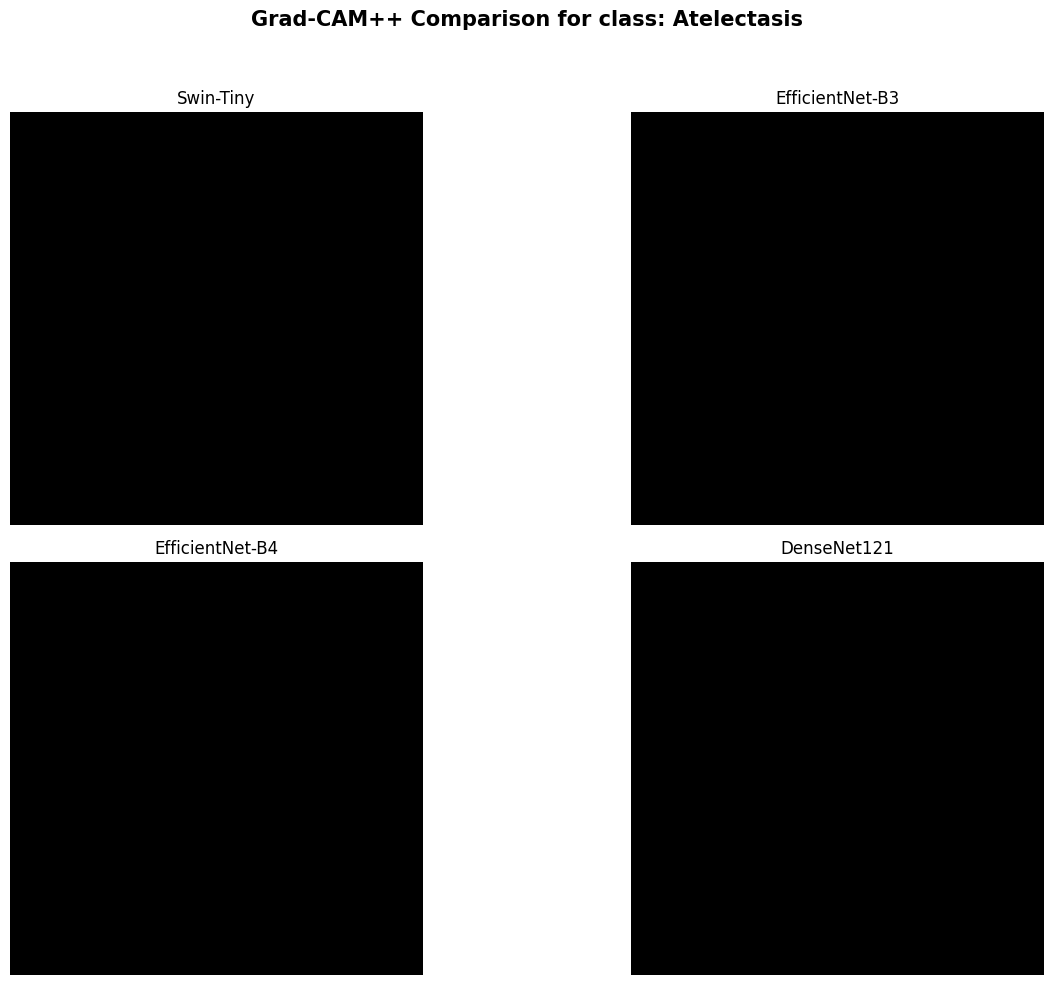


=== Cardiomegaly ===
✅ Found positive validation sample for Cardiomegaly: 00019636_000.png
✅ Found image: data/images_009/images/00019636_000.png
⚠️ Grad-CAM++ failed for Swin-Tiny: not enough values to unpack (expected 2, got 0)
⚠️ Grad-CAM++ failed for EfficientNet-B3: not enough values to unpack (expected 2, got 0)
⚠️ Grad-CAM++ failed for EfficientNet-B4: not enough values to unpack (expected 2, got 0)
⚠️ Grad-CAM++ failed for DenseNet121: not enough values to unpack (expected 2, got 0)


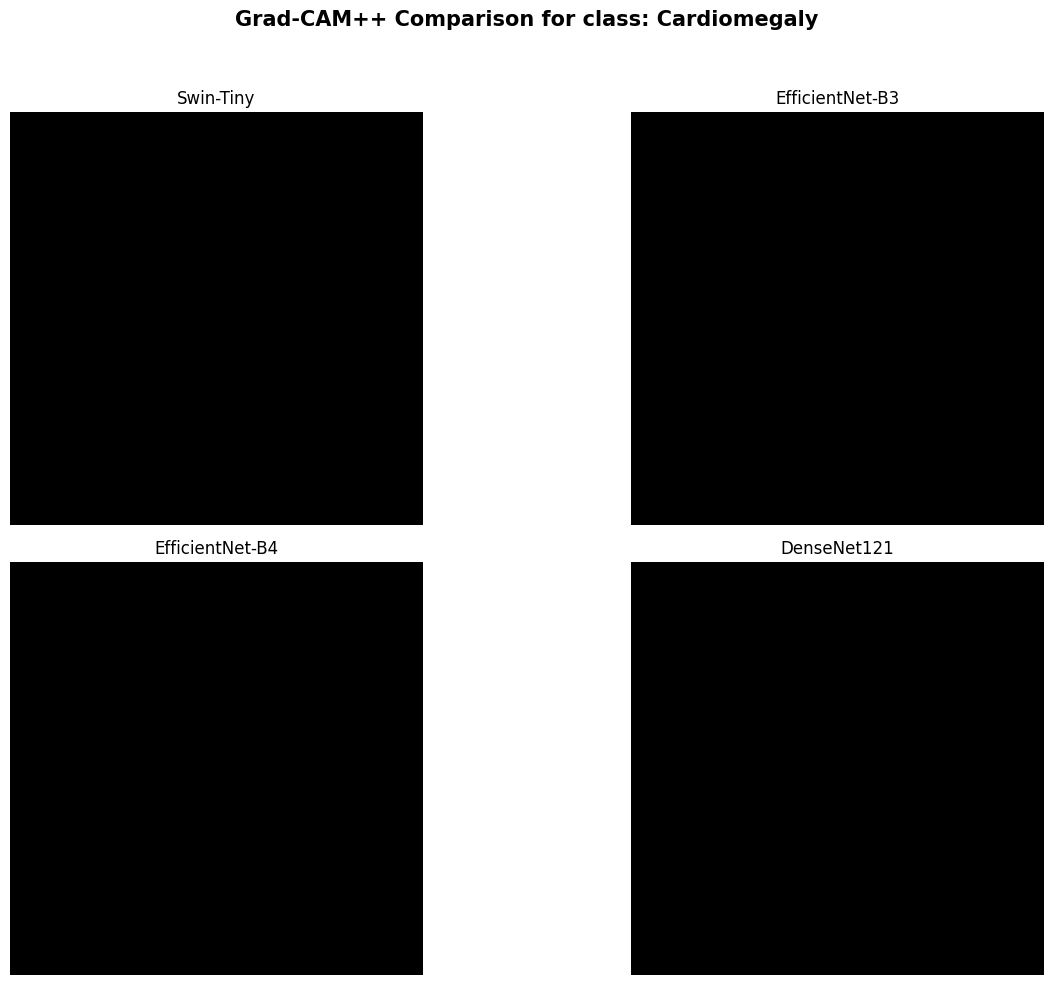


=== Effusion ===
✅ Found positive validation sample for Effusion: 00004992_013.png
✅ Found image: data/images_003/images/00004992_013.png
⚠️ Grad-CAM++ failed for Swin-Tiny: not enough values to unpack (expected 2, got 0)
⚠️ Grad-CAM++ failed for EfficientNet-B3: not enough values to unpack (expected 2, got 0)
⚠️ Grad-CAM++ failed for EfficientNet-B4: not enough values to unpack (expected 2, got 0)
⚠️ Grad-CAM++ failed for DenseNet121: not enough values to unpack (expected 2, got 0)


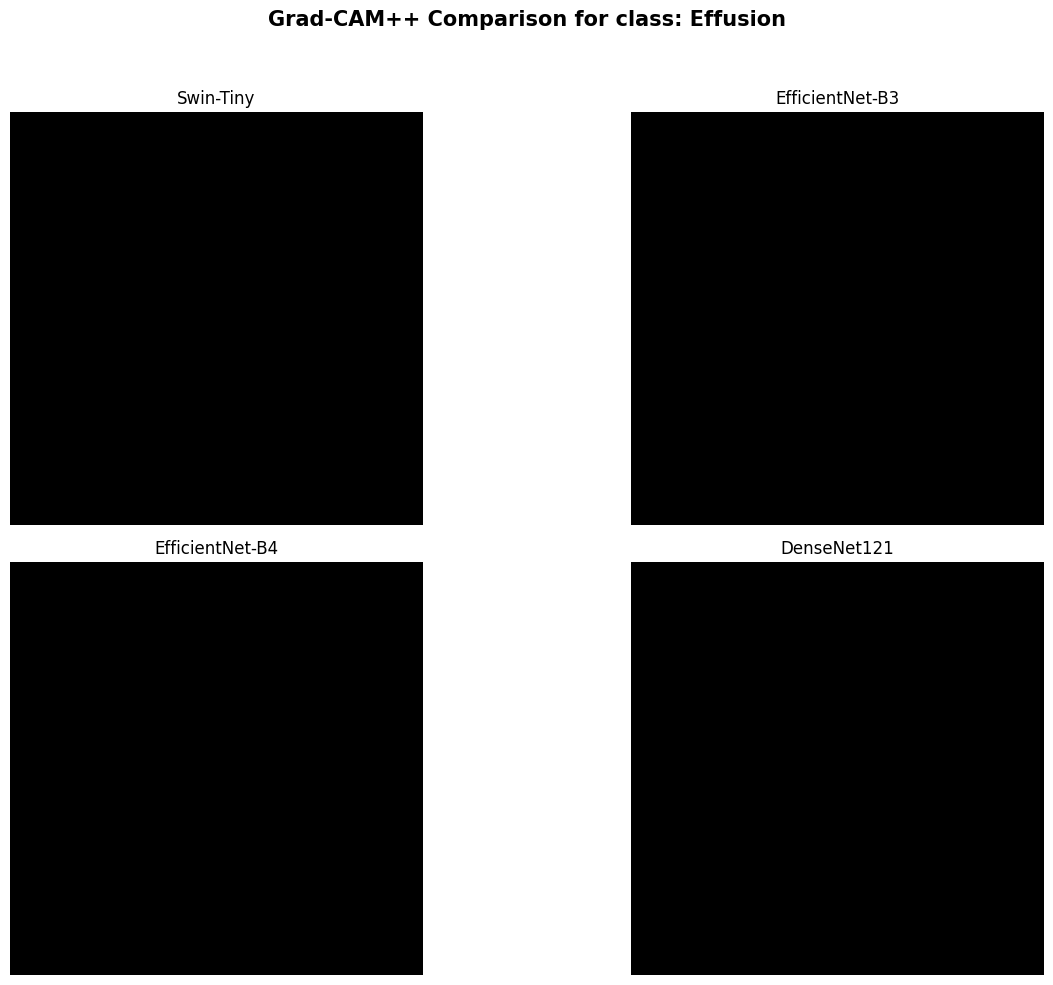


=== Infiltration ===
✅ Found positive validation sample for Infiltration: 00029845_002.png
✅ Found image: data/images_012/images/00029845_002.png
⚠️ Grad-CAM++ failed for Swin-Tiny: not enough values to unpack (expected 2, got 0)
⚠️ Grad-CAM++ failed for EfficientNet-B3: not enough values to unpack (expected 2, got 0)
⚠️ Grad-CAM++ failed for EfficientNet-B4: not enough values to unpack (expected 2, got 0)
⚠️ Grad-CAM++ failed for DenseNet121: not enough values to unpack (expected 2, got 0)


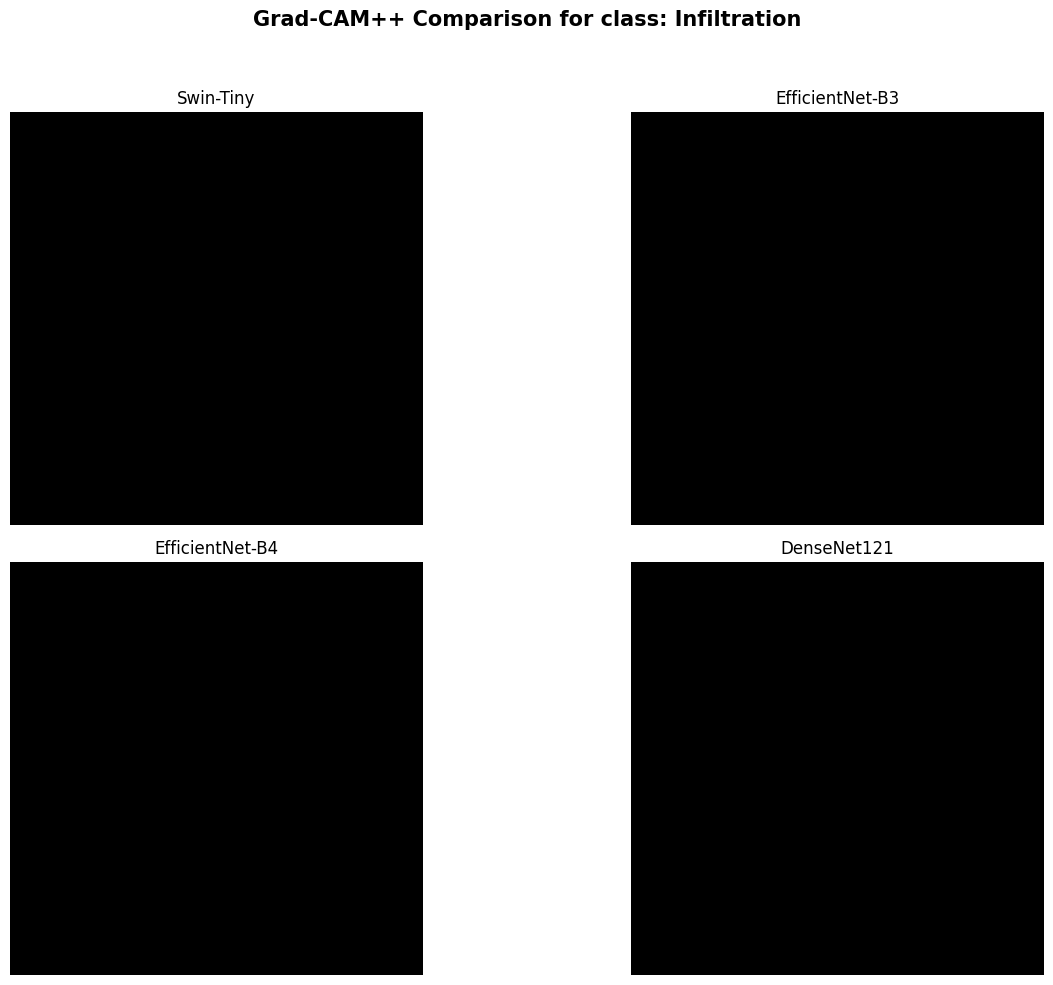


=== Mass ===
✅ Found positive validation sample for Mass: 00004712_000.png
✅ Found image: data/images_003/images/00004712_000.png
⚠️ Grad-CAM++ failed for Swin-Tiny: not enough values to unpack (expected 2, got 0)
⚠️ Grad-CAM++ failed for EfficientNet-B3: not enough values to unpack (expected 2, got 0)
⚠️ Grad-CAM++ failed for EfficientNet-B4: not enough values to unpack (expected 2, got 0)
⚠️ Grad-CAM++ failed for DenseNet121: not enough values to unpack (expected 2, got 0)


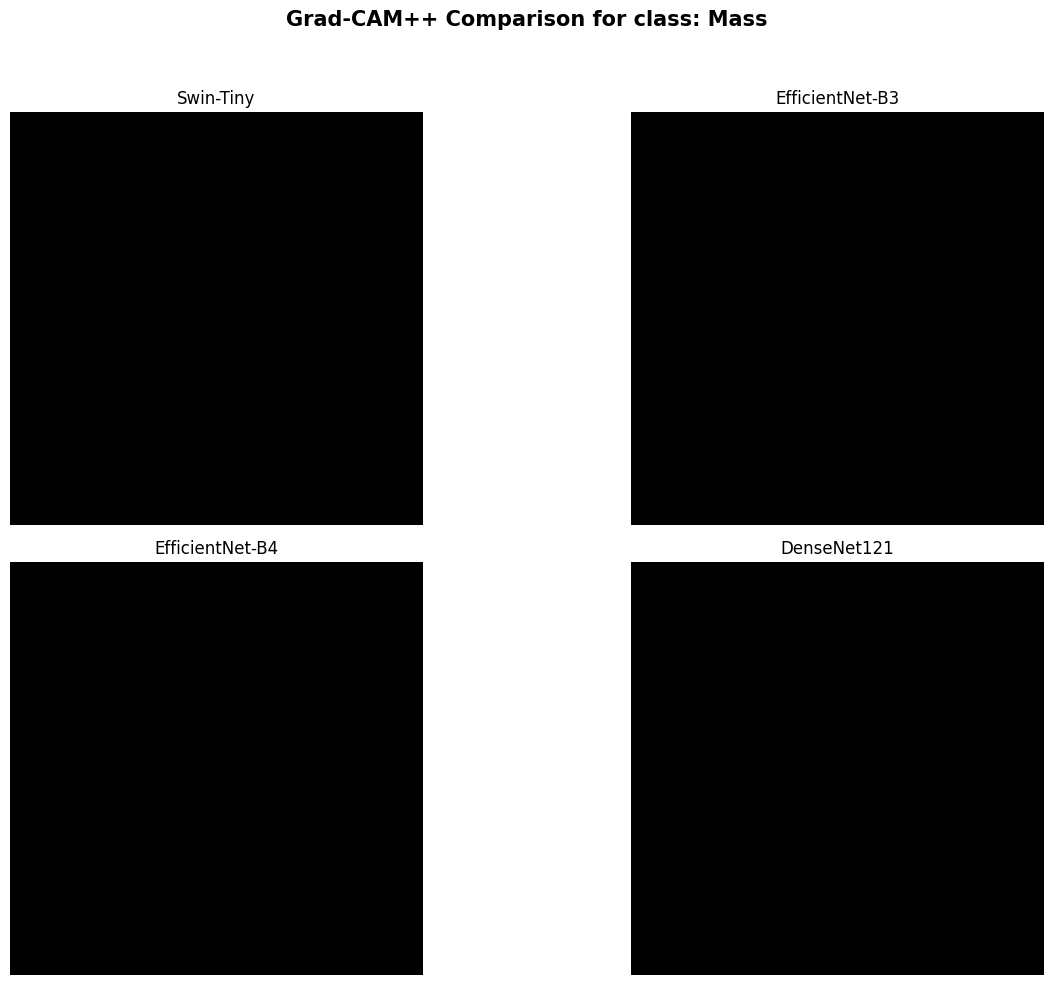


=== Nodule ===
✅ Found positive validation sample for Nodule: 00027800_000.png
✅ Found image: data/images_011/images/00027800_000.png
⚠️ Grad-CAM++ failed for Swin-Tiny: not enough values to unpack (expected 2, got 0)
⚠️ Grad-CAM++ failed for EfficientNet-B3: not enough values to unpack (expected 2, got 0)
⚠️ Grad-CAM++ failed for EfficientNet-B4: not enough values to unpack (expected 2, got 0)
⚠️ Grad-CAM++ failed for DenseNet121: not enough values to unpack (expected 2, got 0)


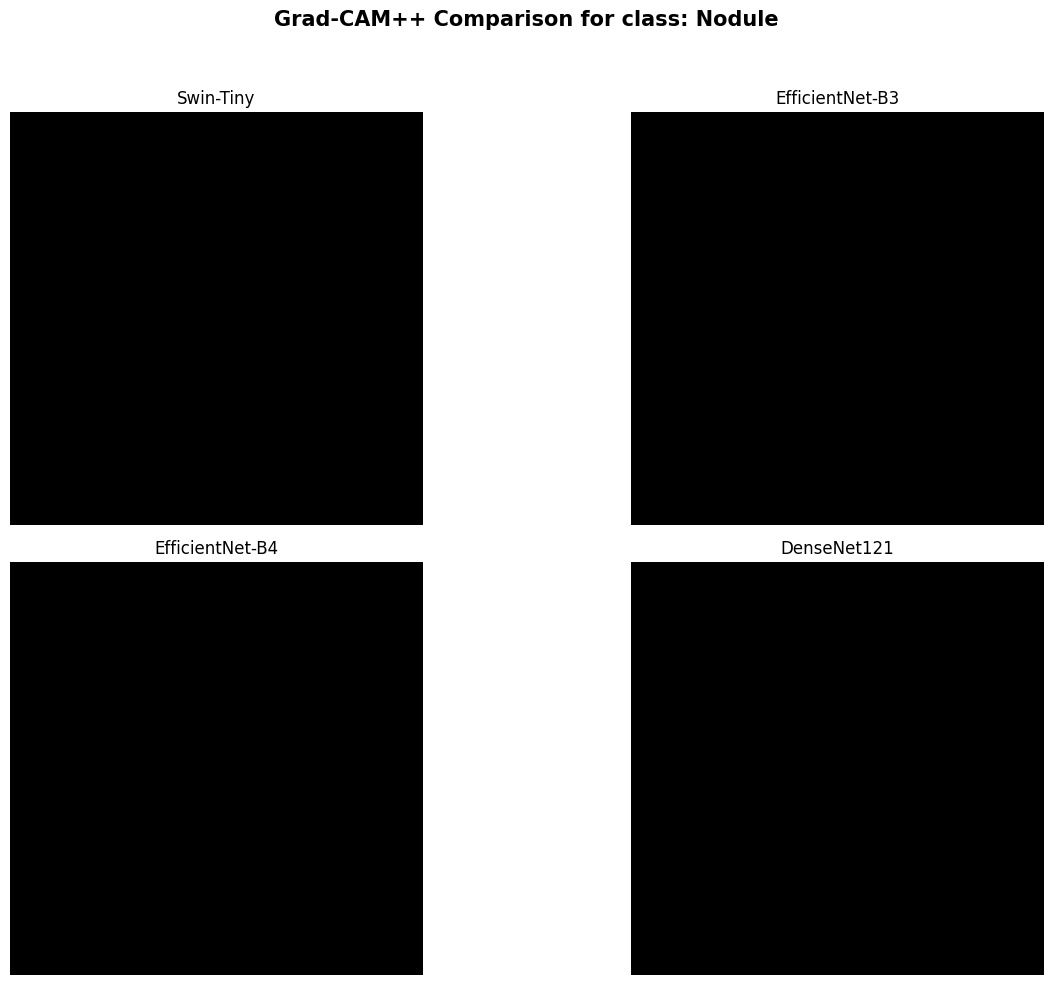


=== Pneumonia ===
✅ Found positive validation sample for Pneumonia: 00010509_003.png
✅ Found image: data/images_005/images/00010509_003.png
⚠️ Grad-CAM++ failed for Swin-Tiny: not enough values to unpack (expected 2, got 0)
⚠️ Grad-CAM++ failed for EfficientNet-B3: not enough values to unpack (expected 2, got 0)
⚠️ Grad-CAM++ failed for EfficientNet-B4: not enough values to unpack (expected 2, got 0)
⚠️ Grad-CAM++ failed for DenseNet121: not enough values to unpack (expected 2, got 0)


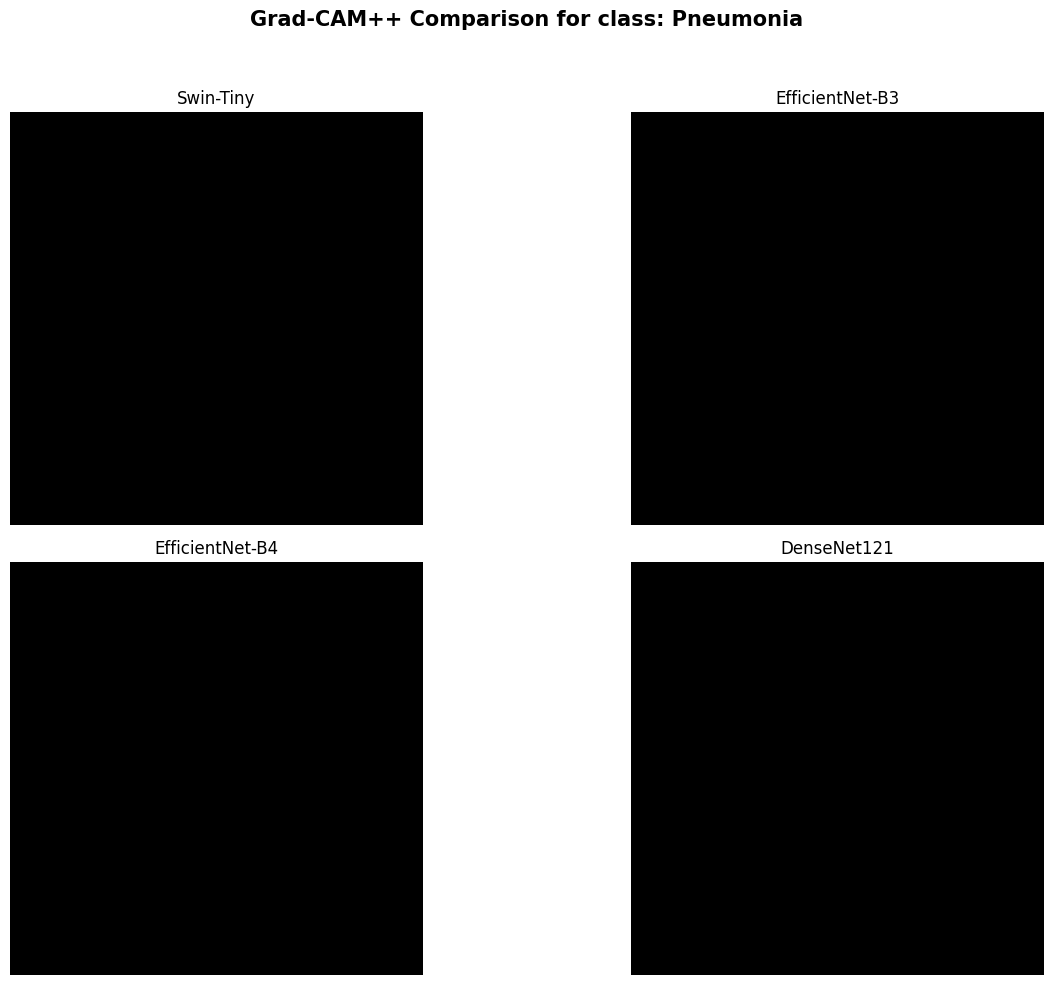


=== Pneumothorax ===
✅ Found positive validation sample for Pneumothorax: 00014299_006.png
✅ Found image: data/images_007/images/00014299_006.png
⚠️ Grad-CAM++ failed for Swin-Tiny: not enough values to unpack (expected 2, got 0)
⚠️ Grad-CAM++ failed for EfficientNet-B3: not enough values to unpack (expected 2, got 0)
⚠️ Grad-CAM++ failed for EfficientNet-B4: not enough values to unpack (expected 2, got 0)
⚠️ Grad-CAM++ failed for DenseNet121: not enough values to unpack (expected 2, got 0)


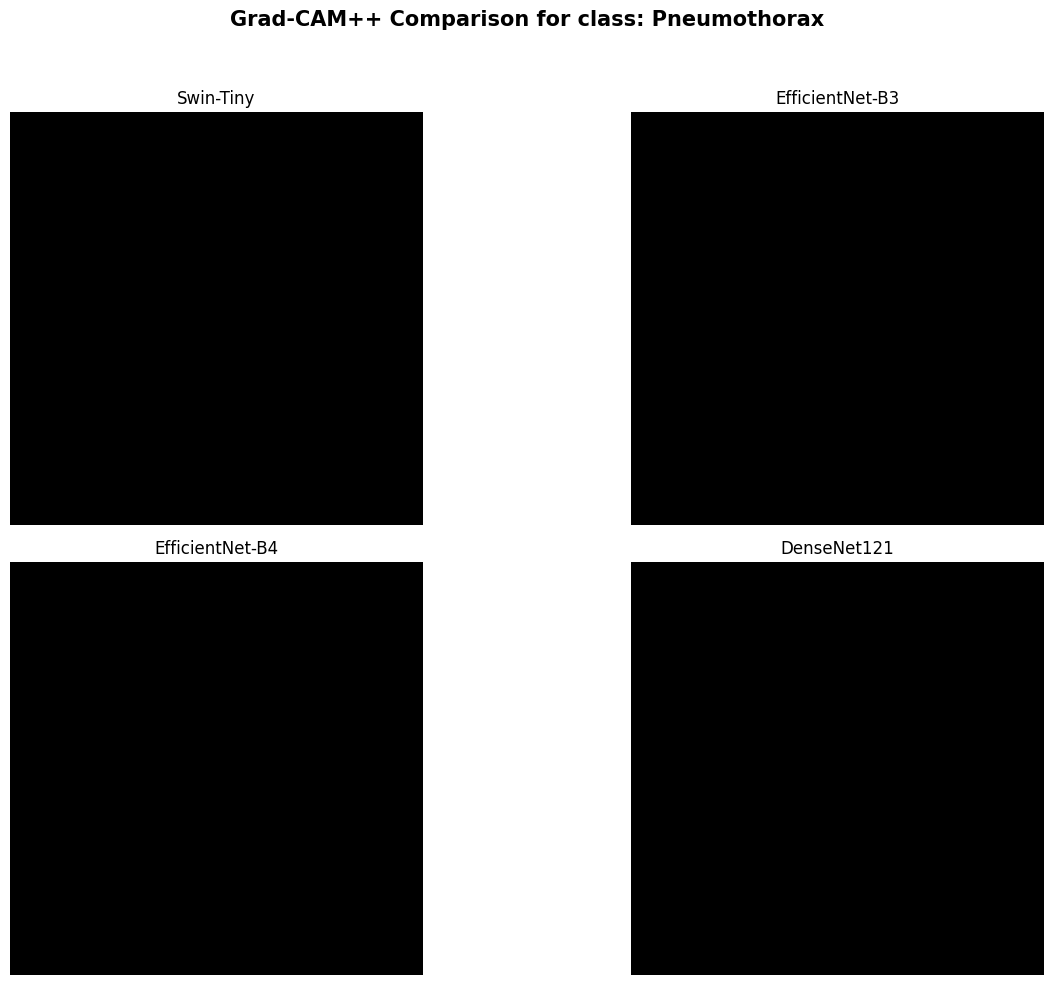


=== Consolidation ===
✅ Found positive validation sample for Consolidation: 00009931_003.png
✅ Found image: data/images_005/images/00009931_003.png
⚠️ Grad-CAM++ failed for Swin-Tiny: not enough values to unpack (expected 2, got 0)
⚠️ Grad-CAM++ failed for EfficientNet-B3: not enough values to unpack (expected 2, got 0)
⚠️ Grad-CAM++ failed for EfficientNet-B4: not enough values to unpack (expected 2, got 0)
⚠️ Grad-CAM++ failed for DenseNet121: not enough values to unpack (expected 2, got 0)


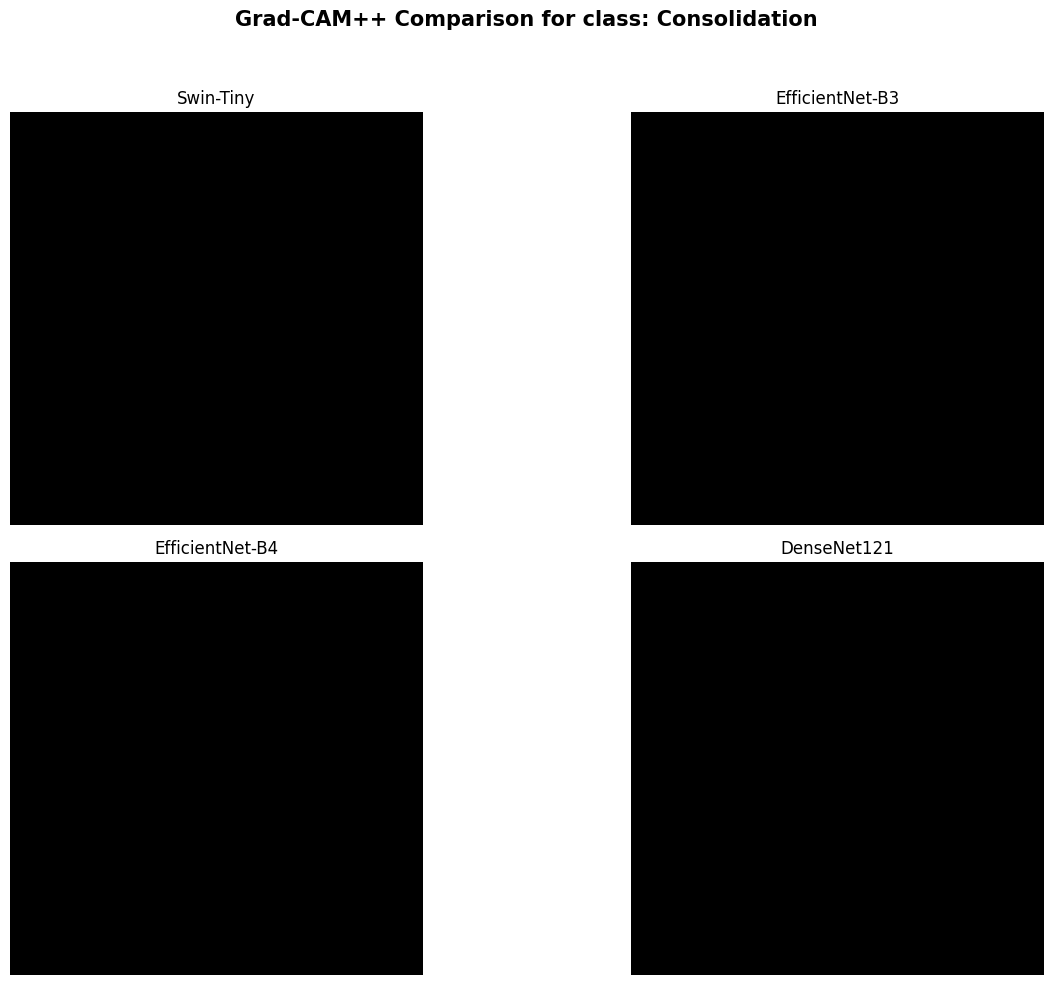


=== Edema ===
✅ Found positive validation sample for Edema: 00017055_000.png
✅ Found image: data/images_008/images/00017055_000.png
⚠️ Grad-CAM++ failed for Swin-Tiny: not enough values to unpack (expected 2, got 0)
⚠️ Grad-CAM++ failed for EfficientNet-B3: not enough values to unpack (expected 2, got 0)
⚠️ Grad-CAM++ failed for EfficientNet-B4: not enough values to unpack (expected 2, got 0)
⚠️ Grad-CAM++ failed for DenseNet121: not enough values to unpack (expected 2, got 0)


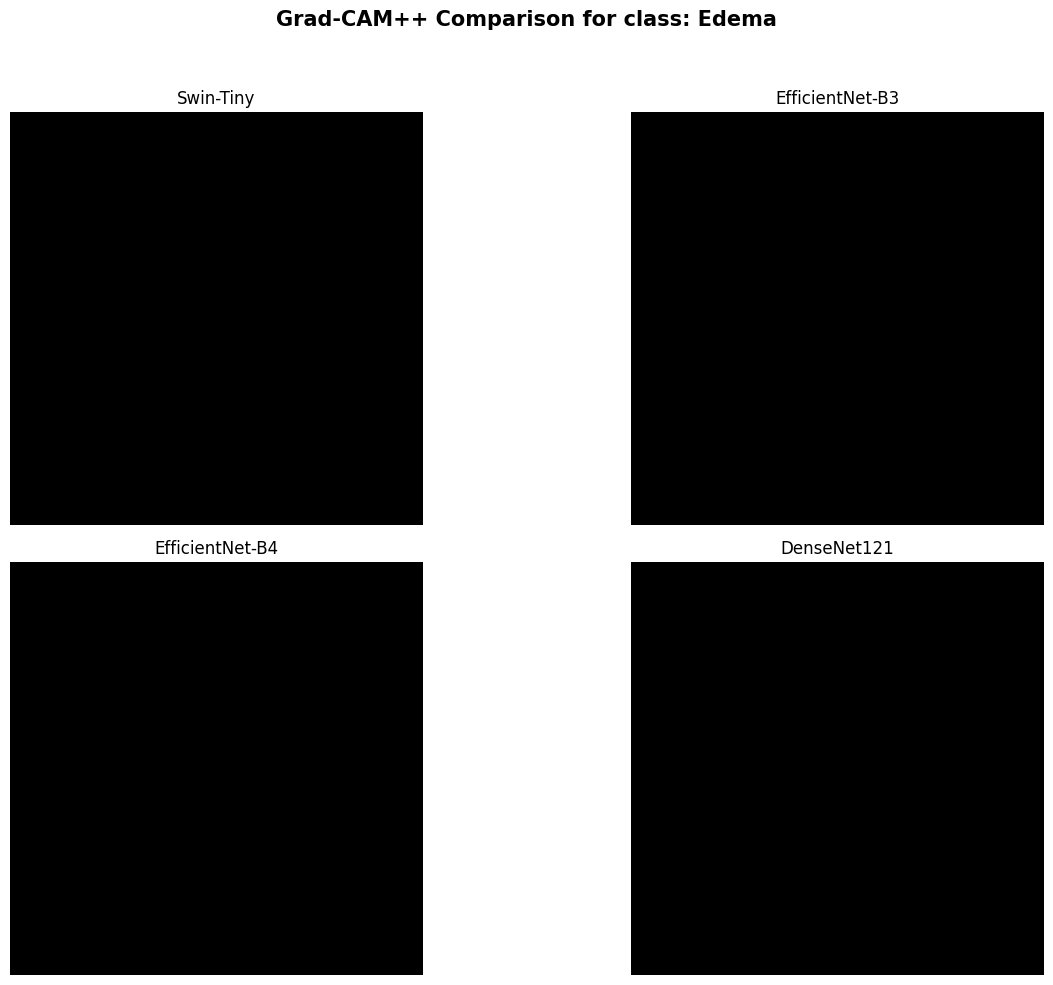


=== Emphysema ===
✅ Found positive validation sample for Emphysema: 00001656_000.png
✅ Found image: data/images_002/images/00001656_000.png
⚠️ Grad-CAM++ failed for Swin-Tiny: not enough values to unpack (expected 2, got 0)
⚠️ Grad-CAM++ failed for EfficientNet-B3: not enough values to unpack (expected 2, got 0)
⚠️ Grad-CAM++ failed for EfficientNet-B4: not enough values to unpack (expected 2, got 0)
⚠️ Grad-CAM++ failed for DenseNet121: not enough values to unpack (expected 2, got 0)


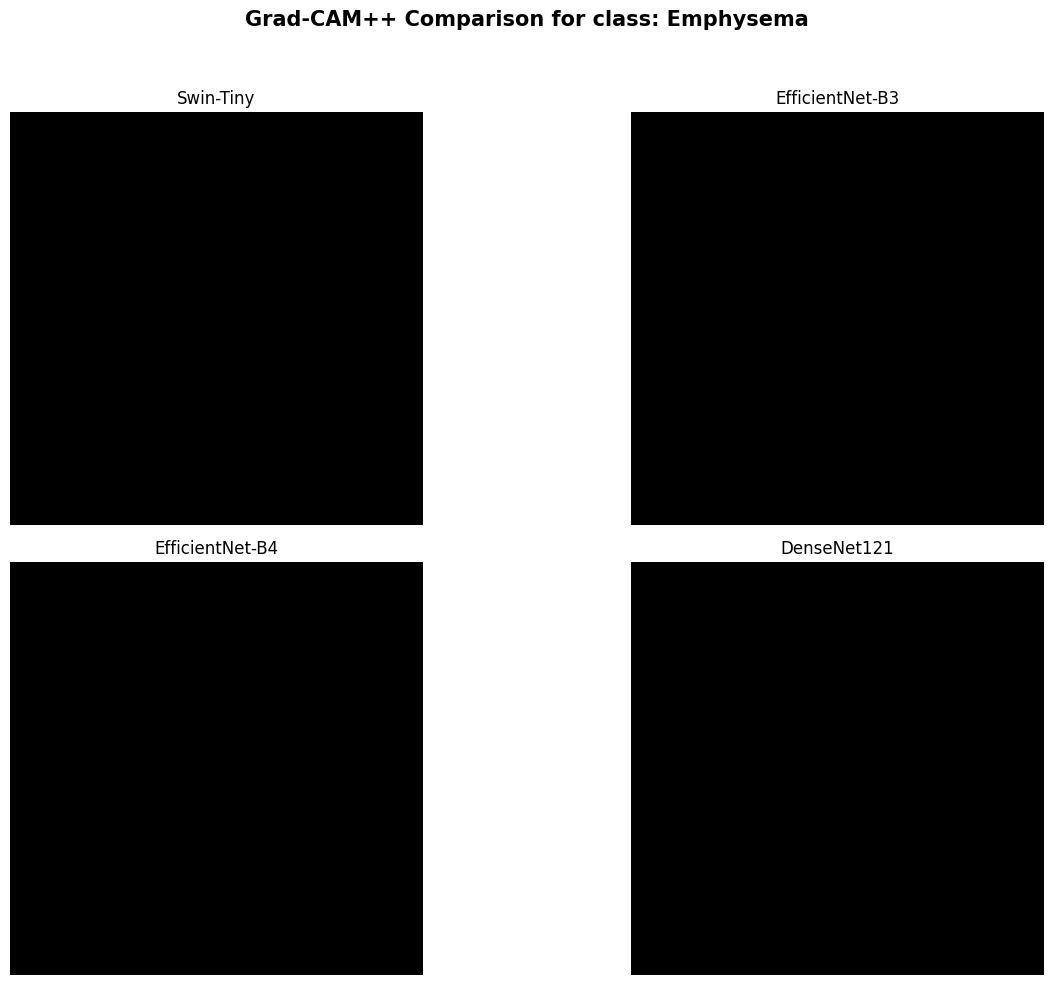


=== Fibrosis ===
✅ Found positive validation sample for Fibrosis: 00018362_018.png
✅ Found image: data/images_008/images/00018362_018.png
⚠️ Grad-CAM++ failed for Swin-Tiny: not enough values to unpack (expected 2, got 0)
⚠️ Grad-CAM++ failed for EfficientNet-B3: not enough values to unpack (expected 2, got 0)
⚠️ Grad-CAM++ failed for EfficientNet-B4: not enough values to unpack (expected 2, got 0)
⚠️ Grad-CAM++ failed for DenseNet121: not enough values to unpack (expected 2, got 0)


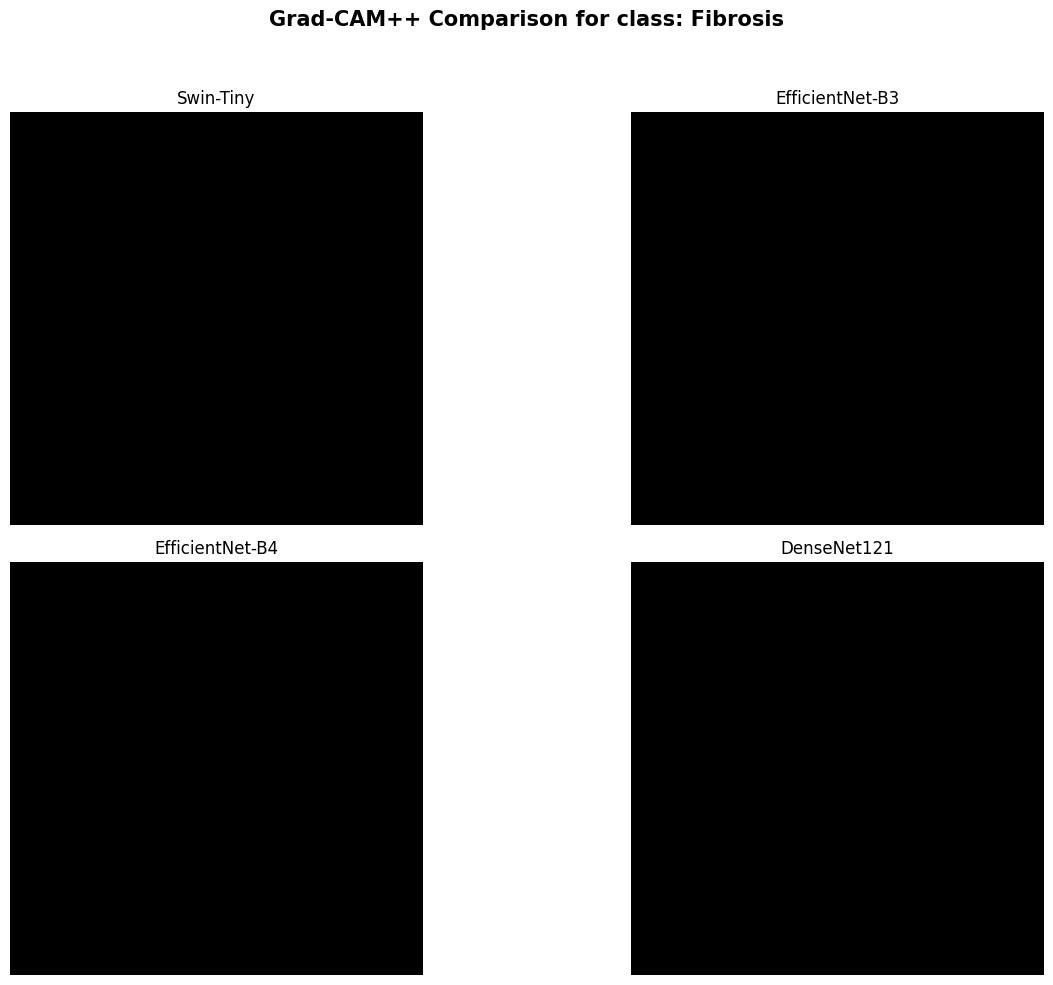


=== Pleural_Thickening ===
✅ Found positive validation sample for Pleural_Thickening: 00011859_003.png
✅ Found image: data/images_006/images/00011859_003.png
⚠️ Grad-CAM++ failed for Swin-Tiny: not enough values to unpack (expected 2, got 0)
⚠️ Grad-CAM++ failed for EfficientNet-B3: not enough values to unpack (expected 2, got 0)
⚠️ Grad-CAM++ failed for EfficientNet-B4: not enough values to unpack (expected 2, got 0)
⚠️ Grad-CAM++ failed for DenseNet121: not enough values to unpack (expected 2, got 0)


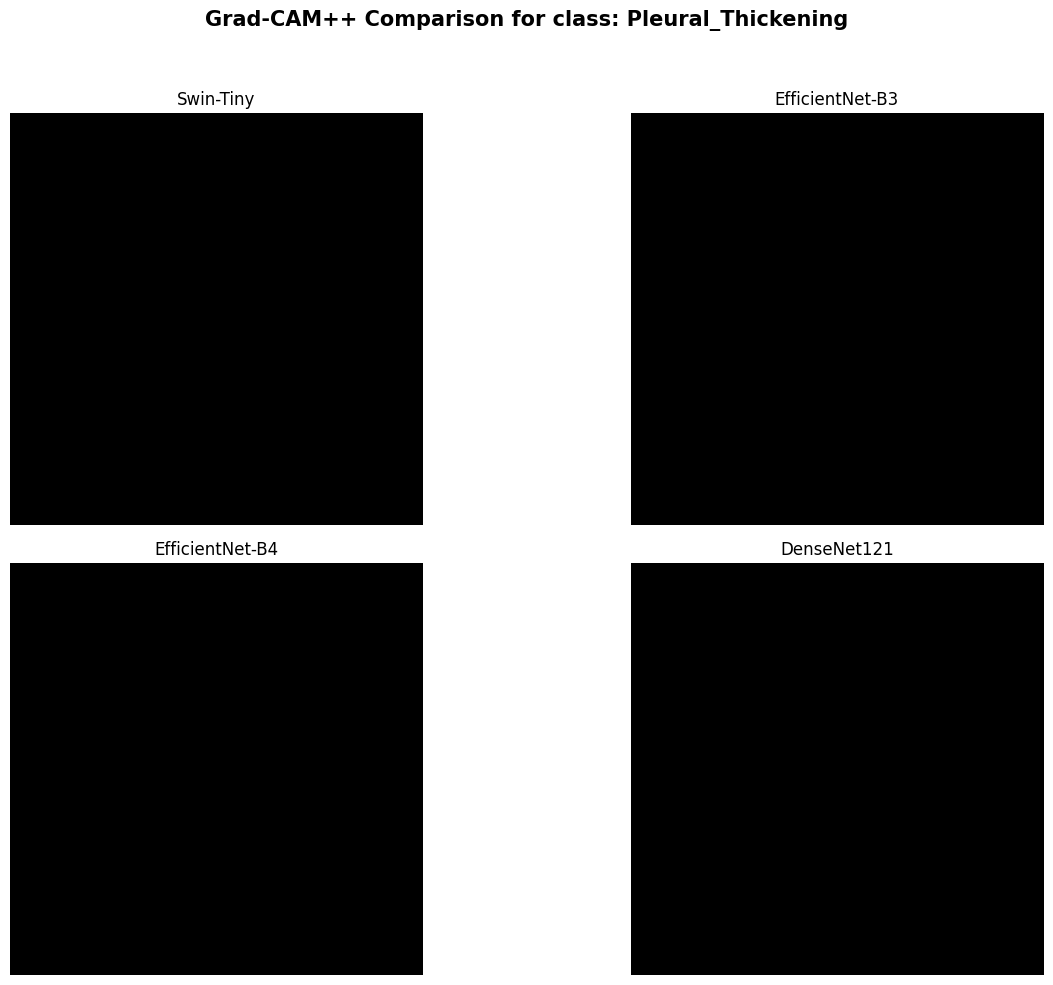


=== Hernia ===
✅ Found positive validation sample for Hernia: 00002089_001.png
✅ Found image: data/images_002/images/00002089_001.png
⚠️ Grad-CAM++ failed for Swin-Tiny: not enough values to unpack (expected 2, got 0)
⚠️ Grad-CAM++ failed for EfficientNet-B3: not enough values to unpack (expected 2, got 0)
⚠️ Grad-CAM++ failed for EfficientNet-B4: not enough values to unpack (expected 2, got 0)
⚠️ Grad-CAM++ failed for DenseNet121: not enough values to unpack (expected 2, got 0)


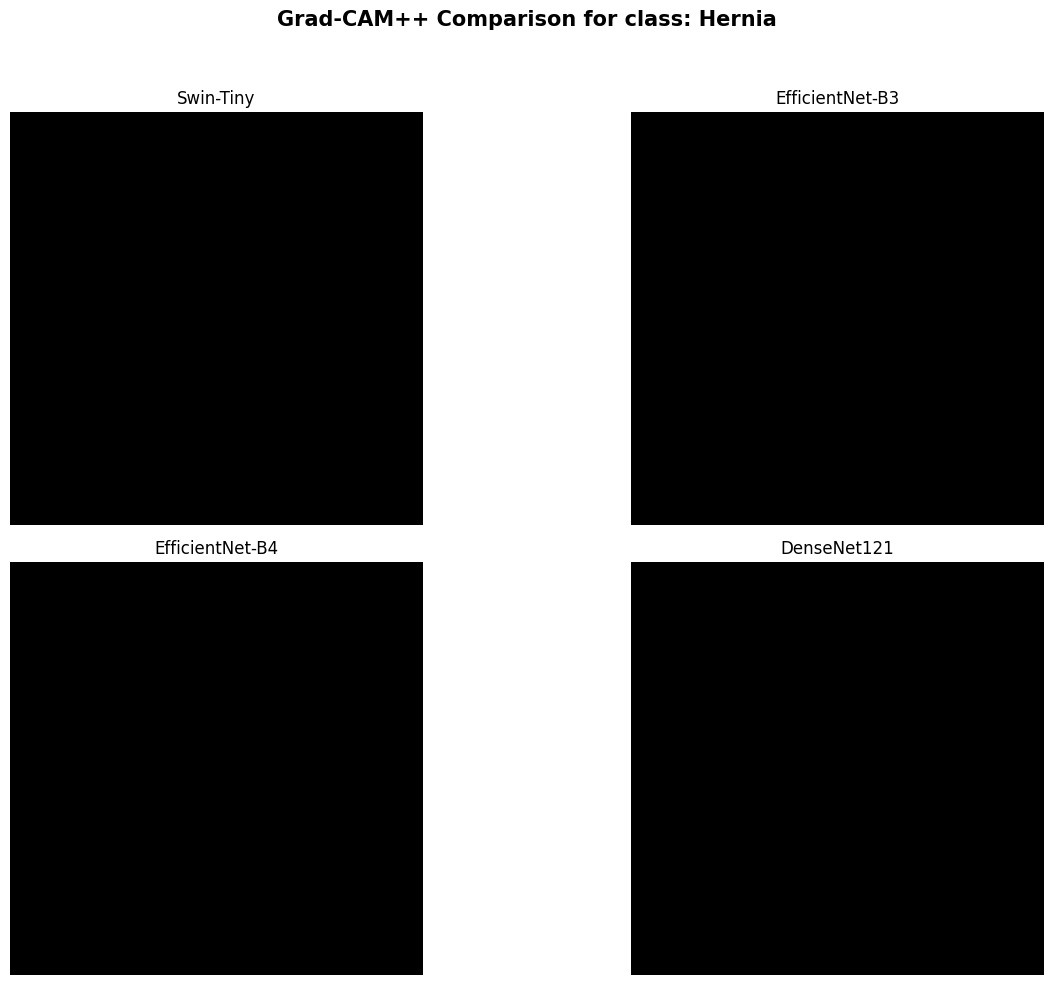

In [100]:
# ========================== CELL 4 — RUN FOR EACH DISEASE CLASS ==========================
for disease in class_names:
    print(f"\n=== {disease} ===")
    img_path = get_val_image_for_class(disease)
    if img_path:
        class_index = class_names.index(disease)
        compare_models_gradcam_plus(img_path, class_index)


In [101]:
# ========================== ENSEMBLE GRAD-CAM++ ==========================
def generate_ensemble_gradcam(models_dict, image_tensor, target_class, weights=None):
    """
    Compute an ensemble Grad-CAM++ heatmap by averaging or weighting individual model CAMs.
    Args:
        models_dict: { "model_name": model_object }
        image_tensor: preprocessed tensor
        target_class: int, target class index
        weights: dict of model weights (optional, same keys as models_dict)
    Returns:
        ensemble_cam: numpy array of shape (224, 224)
    """
    cams = []
    for name, model in models_dict.items():
        try:
            cam = generate_gradcam_plus(model, image_tensor, target_class, name)
            if cam is not None and cam.size > 0:
                weight = 1.0
                if weights and name in weights:
                    weight = weights[name]
                cams.append(weight * cam)
        except Exception as e:
            print(f"⚠️ {name} Grad-CAM++ failed: {e}")

    if len(cams) == 0:
        print("⚠️ No CAMs generated for ensemble.")
        return np.zeros((224, 224))

    ensemble_cam = np.sum(cams, axis=0)
    ensemble_cam = np.maximum(ensemble_cam, 0)
    ensemble_cam -= ensemble_cam.min()
    ensemble_cam /= ensemble_cam.max() + 1e-8
    return ensemble_cam


In [102]:
# ========================== VISUALIZE ENSEMBLE GRAD-CAM++ ==========================
def show_ensemble_gradcam(img_path, target_class_index, weights=None):
    """
    Display the ensemble Grad-CAM++ heatmap overlay.
    """
    img = cv2.imread(img_path)
    if img is None:
        raise FileNotFoundError(f"Cannot read image: {img_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (224, 224))
    input_tensor = val_transform(image=img_resized)["image"]

    models_dict = {
        "Swin-Tiny": swin_model,
        "EfficientNet-B3": effb3_model,
        "EfficientNet-B4": effb4_model,
        "DenseNet121": densenet_model
    }

    ensemble_cam = generate_ensemble_gradcam(models_dict, input_tensor, target_class_index, weights)

    cam_resized = cv2.resize(ensemble_cam, (img.shape[1], img.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    plt.figure(figsize=(10, 5))
    plt.suptitle(f"Ensemble Grad-CAM++ for class: {class_names[target_class_index]}", fontsize=14, fontweight="bold")
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original X-ray")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title("Ensemble Grad-CAM++ (Weighted Average)")
    plt.axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.9])
    plt.show()


✅ Found positive validation sample for Effusion: 00021457_007.png
✅ Found image: data/images_010/images/00021457_007.png
⚠️ Swin-Tiny Grad-CAM++ failed: not enough values to unpack (expected 2, got 0)
⚠️ EfficientNet-B3 Grad-CAM++ failed: not enough values to unpack (expected 2, got 0)
⚠️ EfficientNet-B4 Grad-CAM++ failed: not enough values to unpack (expected 2, got 0)
⚠️ DenseNet121 Grad-CAM++ failed: not enough values to unpack (expected 2, got 0)
⚠️ No CAMs generated for ensemble.


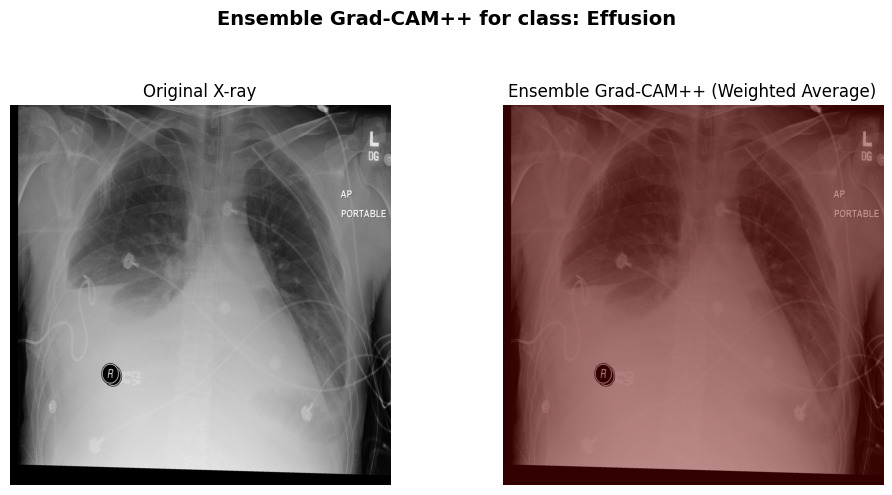

In [103]:
img_path = get_val_image_for_class("Effusion")
if img_path:
    idx = class_names.index("Effusion")
    show_ensemble_gradcam(img_path, idx, weights)


In [104]:
img_path = get_val_image_for_class("Effusion")
if img_path:
    idx = class_names.index("Effusion")
    cam = generate_gradcam_plus(effb3_model, val_transform(image=cv2.resize(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB), (224, 224)))["image"], idx, "EfficientNet-B3")
    plt.imshow(cam); plt.title("Single-model Grad-CAM++ check"); plt.axis("off"); plt.show()


✅ Found positive validation sample for Effusion: 00016677_000.png
✅ Found image: data/images_008/images/00016677_000.png


ValueError: not enough values to unpack (expected 2, got 0)

In [ ]:
# ========================== UNIVERSAL GRAD-CAM++ IMPLEMENTATION ==========================
import torch
import torch.nn.functional as F
import numpy as np
import cv2

def generate_gradcam_plus(model, image_tensor, target_class, model_name):
    """
    Compute Grad-CAM++ for CNN or Transformer models.
    Handles EfficientNet, DenseNet, Swin.
    """
    model.eval()
    activations, gradients = [], []

    # --- Normalize model name ---
    name = model_name.lower().replace("-", "_")

    # --- Try to auto-detect the last convolutional layer dynamically ---
    target_layer = None
    for module in reversed(list(model.modules())):
        if isinstance(module, torch.nn.Conv2d):
            target_layer = module
            break

    if target_layer is None:
        print(f"⚠️ No Conv2D layer found for {model_name}")
        return np.zeros((224, 224))

    # --- Hook registration ---
    def forward_hook(module, input, output):
        activations.append(output.detach())

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0].detach())

    fh = target_layer.register_forward_hook(forward_hook)
    bh = target_layer.register_backward_hook(backward_hook)

    # --- Forward pass ---
    img = image_tensor.unsqueeze(0).to(device)
    img.requires_grad = True
    output = model(img)
    target = output[0, target_class]

    # --- Backward pass ---
    model.zero_grad()
    try:
        target.backward(retain_graph=True)
    except Exception as e:
        print(f"⚠️ Backward failed for {model_name}: {e}")
        fh.remove()
        bh.remove()
        return np.zeros((224, 224))

    fh.remove()
    bh.remove()

    # --- Extract activations & gradients ---
    if len(activations) == 0 or len(gradients) == 0:
        print(f"⚠️ Hooks did not capture activations for {model_name}")
        return np.zeros((224, 224))

    A = activations[0]  # [B, C, H, W]
    grads = gradients[0]

    # --- Grad-CAM++ weights ---
    grad_2 = grads ** 2
    grad_3 = grad_2 * grads
    sum_A = torch.sum(A, dim=(2, 3), keepdim=True)
    eps = 1e-8
    alpha_num = grad_2
    alpha_denom = 2 * grad_2 + sum_A * grad_3
    alpha_denom = torch.where(alpha_denom != 0.0, alpha_denom, torch.tensor(eps, device=device))
    alpha = alpha_num / alpha_denom
    relu_grad = F.relu(grads)
    weights = torch.sum(alpha * relu_grad, dim=(2, 3), keepdim=True)

    # --- Weighted combination ---
    cam = torch.sum(weights * A, dim=1).squeeze()
    cam = F.relu(cam)

    # --- Normalize ---
    cam -= cam.min()
    cam /= cam.max() + 1e-8
    cam = cam.detach().cpu().numpy()

    # --- Resize to 224x224 for visualization ---
    cam = cv2.resize(cam, (224, 224))
    return cam


✅ Found positive validation sample for Effusion: 00026027_003.png
✅ Found image: data/images_011/images/00026027_003.png


/home/prem/PROJECT DATA/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


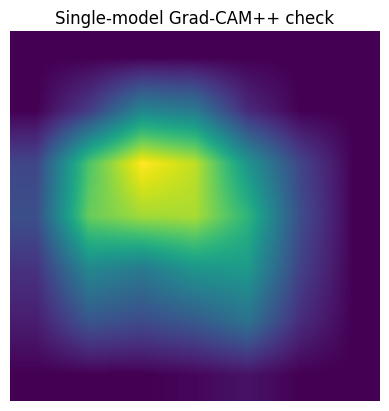

In [ ]:
img_path = get_val_image_for_class("Effusion")
if img_path:
    idx = class_names.index("Effusion")
    cam = generate_gradcam_plus(effb3_model, val_transform(image=cv2.resize(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB), (224, 224)))["image"], idx, "EfficientNet-B3")
    plt.imshow(cam); plt.title("Single-model Grad-CAM++ check"); plt.axis("off"); plt.show()


In [ ]:
# ========================== TRUE-COLOR OVERLAY GRAD-CAM VISUALIZATION ==========================
import cv2
import numpy as np
import matplotlib.pyplot as plt

def visualize_gradcam_overlay(
    img_path, 
    cam, 
    title="Grad-CAM++ Overlay", 
    colormap="inferno",   # 'inferno' or 'jet' for color
    alpha=0.4,            # transparency of CAM overlay
    threshold=0.2         # show only areas above this intensity
):
    """
    Visualize Grad-CAM or Grad-CAM++ heatmap over the *true* original X-ray image
    (no tinted background, only color overlay where model focuses).

    Args:
        img_path (str): path to original X-ray.
        cam (np.ndarray): Grad-CAM map (2D array normalized 0–1).
        title (str): plot title.
        colormap (str): OpenCV colormap name ('inferno', 'hot', 'jet', etc.).
        alpha (float): overlay transparency (0=no overlay, 1=full overlay).
        threshold (float): fraction of CAM intensity to show (masks weak activations).
    """

    # --- Load original image ---
    img = cv2.imread(img_path)
    if img is None:
        raise FileNotFoundError(f"Could not read image: {img_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (224, 224))

    # --- Normalize CAM ---
    cam = np.array(cam, dtype=np.float32)
    cam -= cam.min()
    cam /= cam.max() + 1e-8
    cam_resized = cv2.resize(cam, (224, 224))

    # --- Threshold weak activations ---
    mask = np.uint8((cam_resized > threshold) * 255)

    # --- Apply color map (e.g., inferno or jet) ---
    cmap_dict = {
        "jet": cv2.COLORMAP_JET,
        "inferno": cv2.COLORMAP_INFERNO,
        "hot": cv2.COLORMAP_HOT,
        "plasma": cv2.COLORMAP_PLASMA
    }
    cmap = cmap_dict.get(colormap.lower(), cv2.COLORMAP_INFERNO)
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cmap)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # --- Mask out non-activated regions ---
    heatmap[mask == 0] = 0

    # --- Combine heatmap with original (without tinting the X-ray) ---
    overlay = img_resized.copy()
    overlay = cv2.addWeighted(overlay, 1.0, heatmap, alpha, 0)

    # --- Display ---
    plt.figure(figsize=(9, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img_resized, cmap="gray")
    plt.title("Original X-ray")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title(title)
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    return overlay


In [ ]:
img_path = get_val_image_for_class("Effusion")
if img_path:
    idx = class_names.index("Effusion")
    cam = generate_gradcam_plus(
        effb3_model, 
        val_transform(image=cv2.resize(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB), (224, 224)))["image"], 
        idx, 
        "EfficientNet-B3"
    )


✅ Found positive validation sample for Effusion: 00007256_013.png
✅ Found image: data/images_004/images/00007256_013.png


/home/prem/PROJECT DATA/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


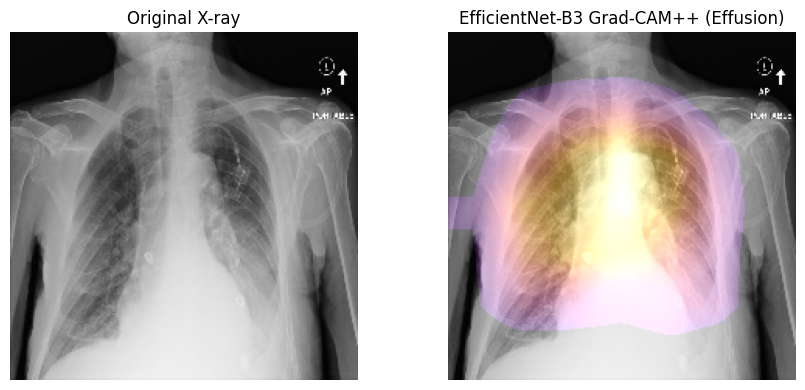

array([[[  8,   8,   8],
        [ 10,  10,  10],
        [  9,   9,   9],
        ...,
        [  7,   7,   7],
        [  7,   7,   7],
        [  7,   7,   7]],

       [[  8,   8,   8],
        [  9,   9,   9],
        [  9,   9,   9],
        ...,
        [  7,   7,   7],
        [  7,   7,   7],
        [  7,   7,   7]],

       [[  8,   8,   8],
        [ 10,  10,  10],
        [  9,   9,   9],
        ...,
        [  7,   7,   7],
        [  7,   7,   7],
        [  7,   7,   7]],

       ...,

       [[ 70,  70,  70],
        [ 74,  74,  74],
        [ 67,  67,  67],
        ...,
        [106, 106, 106],
        [111, 111, 111],
        [106, 106, 106]],

       [[ 70,  70,  70],
        [ 73,  73,  73],
        [ 66,  66,  66],
        ...,
        [102, 102, 102],
        [106, 106, 106],
        [106, 106, 106]],

       [[ 61,  61,  61],
        [ 65,  65,  65],
        [ 50,  50,  50],
        ...,
        [101, 101, 101],
        [103, 103, 103],
        [101, 101, 101]]

In [ ]:
visualize_gradcam_overlay(
    img_path, 
    cam, 
    title="EfficientNet-B3 Grad-CAM++ (Effusion)", 
    colormap="grayscale",   # or "inferno" if you prefer color
                 # white = focus
)


In [ ]:
# ========================== ENSEMBLE GRAD-CAM++ GENERATION ==========================
import numpy as np
import cv2

def generate_ensemble_gradcam(models_dict, image_tensor, target_class, weights=None):
    """
    Compute an ensemble Grad-CAM++ heatmap by averaging or weighting individual model CAMs.
    Args:
        models_dict (dict): {"model_name": model_object}
        image_tensor (torch.Tensor): preprocessed 3x224x224 tensor
        target_class (int): target class index
        weights (dict): optional weighting per model {"ModelName": float}
    Returns:
        ensemble_cam (np.ndarray): normalized 2D CAM (0–1)
    """
    cams = []

    for name, model in models_dict.items():
        try:
            cam = generate_gradcam_plus(model, image_tensor, target_class, name)
            if isinstance(cam, np.ndarray) and cam.size > 0:
                w = weights.get(name, 1.0) if weights else 1.0
                cams.append(w * cam)
            else:
                print(f"⚠️ Empty CAM for {name}")
        except Exception as e:
            print(f"⚠️ {name} Grad-CAM++ failed: {e}")

    if len(cams) == 0:
        print("⚠️ No CAMs generated for ensemble.")
        return np.zeros((224, 224))

    ensemble_cam = np.sum(cams, axis=0)
    ensemble_cam = np.maximum(ensemble_cam, 0)
    ensemble_cam -= ensemble_cam.min()
    ensemble_cam /= ensemble_cam.max() + 1e-8
    return ensemble_cam


In [ ]:
# ========================== ENSEMBLE GRAD-CAM++ VISUALIZATION ==========================
def show_ensemble_gradcam(
    img_path,
    target_class_index,
    weights=None,
    colormap="inferno",   # choose "inferno", "plasma", "hot", "jet"
    alpha=0.45,
    threshold=0.25
):
    """
    Display Ensemble Grad-CAM++ overlay with customizable colormap.
    """
    img = cv2.imread(img_path)
    if img is None:
        raise FileNotFoundError(f"Cannot read image: {img_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (224, 224))
    input_tensor = val_transform(image=img_resized)["image"]

    # Combine all models
    models_dict = {
        "Swin-Tiny": swin_model,
        "EfficientNet-B3": effb3_model,
        "EfficientNet-B4": effb4_model,
        "DenseNet121": densenet_model
    }

    ensemble_cam = generate_ensemble_gradcam(models_dict, input_tensor, target_class_index, weights)

    # Overlay using your high-quality visualizer
    visualize_gradcam_overlay(
        img_path,
        ensemble_cam,
        title=f"Ensemble Grad-CAM++ for {class_names[target_class_index]}",
        colormap=colormap,
        alpha=alpha,
        threshold=threshold
    )

    return ensemble_cam


In [ ]:
# ========================== ENSEMBLE GRAD-CAM++ (EQUAL WEIGHTS VERSION) ==========================
def show_ensemble_gradcam(
    img_path,
    target_class_index,
    colormap="inferno",   # 'inferno', 'plasma', 'hot', 'jet'
    alpha=0.45,
    threshold=0.25
):
    """
    Display Ensemble Grad-CAM++ overlay (equal weights across models).
    """
    # --- Load image ---
    img = cv2.imread(img_path)
    if img is None:
        raise FileNotFoundError(f"Cannot read image: {img_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (224, 224))
    input_tensor = val_transform(image=img_resized)["image"]

    # --- Define ensemble models ---
    models_dict = {
        "Swin-Tiny": swin_model,
        "EfficientNet-B3": effb3_model,
        "EfficientNet-B4": effb4_model,
        "DenseNet121": densenet_model
    }

    # --- Generate ensemble Grad-CAM++ (equal contribution) ---
    ensemble_cam = generate_ensemble_gradcam(
        models_dict, 
        input_tensor, 
        target_class_index, 
        weights=None  # <-- equal weights
    )

    # --- Visualize ---
    visualize_gradcam_overlay(
        img_path,
        ensemble_cam,
        title=f"Ensemble Grad-CAM++ for {class_names[target_class_index]}",
        colormap=colormap,
        alpha=alpha,
        threshold=threshold
    )

    return ensemble_cam


✅ Found positive validation sample for Effusion: 00007300_000.png
✅ Found image: data/images_004/images/00007300_000.png


/home/prem/PROJECT DATA/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


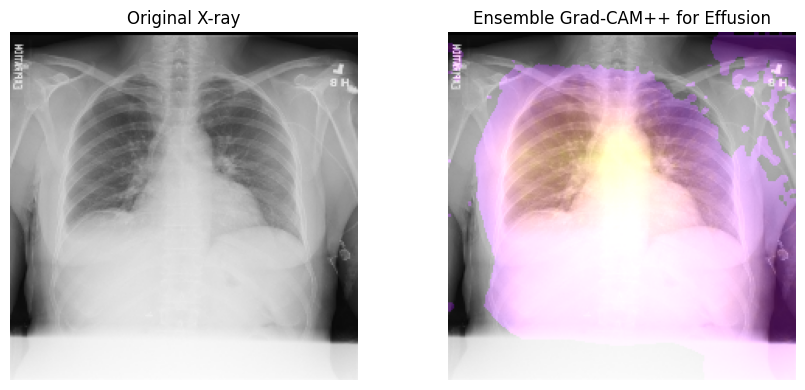

In [ ]:
# Example: visualize ensemble Grad-CAM for "Effusion"
img_path = get_val_image_for_class("Effusion")
if img_path:
    idx = class_names.index("Effusion")
    show_ensemble_gradcam(
        img_path,
        idx,
        colormap="plasma",   # try "inferno", "plasma", or "hot"
        alpha=0.4,
        threshold=0.2
    )


In [ ]:
# ========================== PAPER-STYLE ENSEMBLE GRAD-CAM++ FOR ALL CLASSES ==========================
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def visualize_gradcam_paper(img_path, cam, title, gamma=1.8, threshold=0.2, alpha=0.45, save_dir="results/gradcam_ensemble/"):
    """
    Make Grad-CAM visualization like published radiology figures:
    blue background, red/yellow focus, clean overlay.
    """
    os.makedirs(save_dir, exist_ok=True)

    # --- Load image ---
    img = cv2.imread(img_path)
    if img is None:
        raise FileNotFoundError(f"Could not read {img_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (224, 224))

    # --- Normalize and enhance CAM ---
    cam = np.clip(cam, 0, 1)
    cam = cam ** gamma                  # gamma correction (sharper focus)
    cam[cam < threshold] = 0            # suppress weak activations
    cam /= cam.max() + 1e-8

    # --- Colormap: Turbo (blue→green→yellow→red) ---
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_TURBO)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # --- Overlay ---
    overlay = cv2.addWeighted(img_resized, 1.0, heatmap, alpha, 0)

    # --- Plot ---
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img_resized, cmap="gray")
    plt.title("Original X-ray")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title(title)
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    # --- Save ---
    save_name = os.path.join(save_dir, f"{title.replace(' ', '_')}.png")
    cv2.imwrite(save_name, cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))
    print(f"✅ Saved: {save_name}")


def generate_all_class_gradcams(colormap="turbo"):
    """
    Loop through all disease classes and generate ensemble Grad-CAM++ overlays.
    """
    os.makedirs("results/gradcam_ensemble/", exist_ok=True)

    for disease in class_names:
        img_path = get_val_image_for_class(disease)
        if img_path:
            idx = class_names.index(disease)
            print(f"\n=== Generating Grad-CAM++ for class: {disease} ===")

            # Compute ensemble CAM
            ensemble_cam = generate_ensemble_gradcam(
                {
                    "Swin-Tiny": swin_model,
                    "EfficientNet-B3": effb3_model,
                    "EfficientNet-B4": effb4_model,
                    "DenseNet121": densenet_model
                },
                val_transform(image=cv2.resize(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB), (224, 224)))["image"],
                idx,
                weights=None
            )

            # Visualize in paper style
            visualize_gradcam_paper(
                img_path,
                ensemble_cam,
                title=f"{disease} (Ensemble Grad-CAM++)",
                gamma=1.8,
                threshold=0.2,
                alpha=0.45
            )
        else:
            print(f"⚠️ No validation image found for {disease}")


✅ Found positive validation sample for Atelectasis: 00000143_012.png
✅ Found image: data/images_001/images/00000143_012.png

=== Generating Grad-CAM++ for class: Atelectasis ===


/home/prem/PROJECT DATA/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


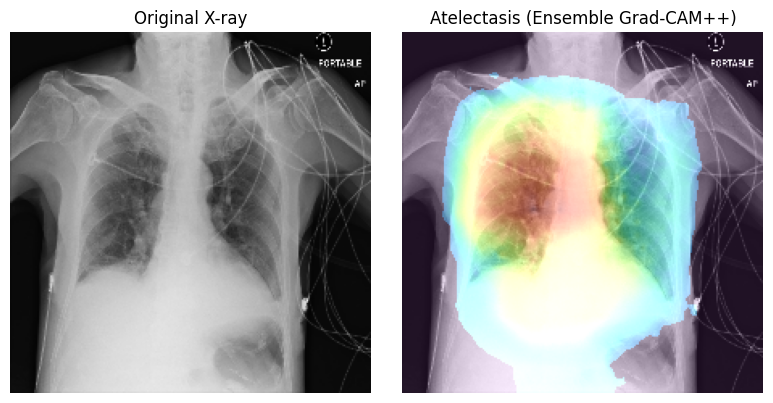

✅ Saved: results/gradcam_ensemble/Atelectasis_(Ensemble_Grad-CAM++).png
✅ Found positive validation sample for Cardiomegaly: 00006218_000.png
✅ Found image: data/images_003/images/00006218_000.png

=== Generating Grad-CAM++ for class: Cardiomegaly ===


/home/prem/PROJECT DATA/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


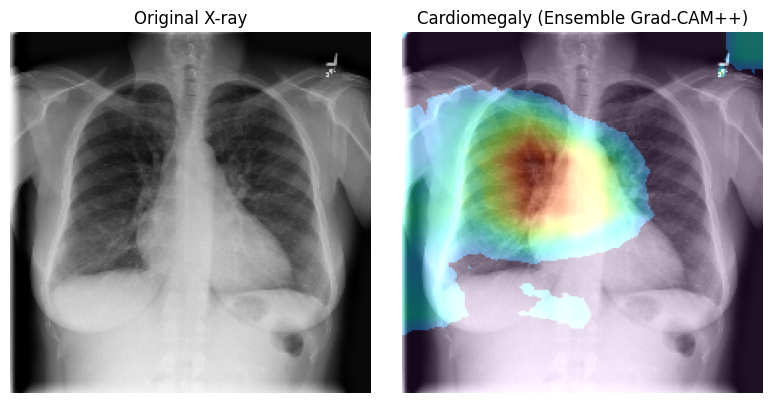

✅ Saved: results/gradcam_ensemble/Cardiomegaly_(Ensemble_Grad-CAM++).png
✅ Found positive validation sample for Effusion: 00001689_007.png
✅ Found image: data/images_002/images/00001689_007.png

=== Generating Grad-CAM++ for class: Effusion ===


/home/prem/PROJECT DATA/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


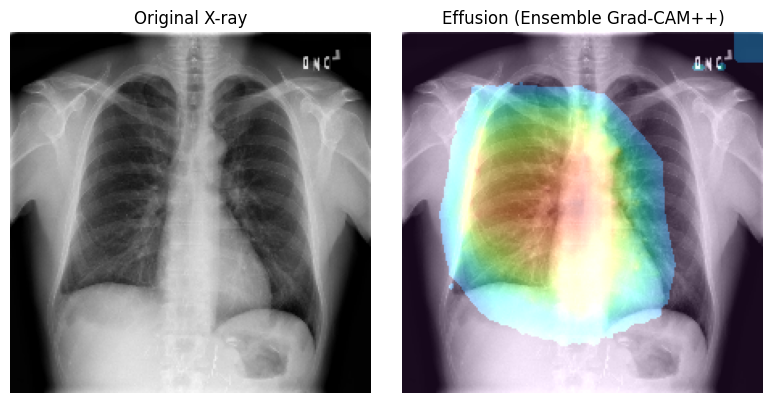

✅ Saved: results/gradcam_ensemble/Effusion_(Ensemble_Grad-CAM++).png
✅ Found positive validation sample for Infiltration: 00013875_005.png
✅ Found image: data/images_007/images/00013875_005.png

=== Generating Grad-CAM++ for class: Infiltration ===


/home/prem/PROJECT DATA/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


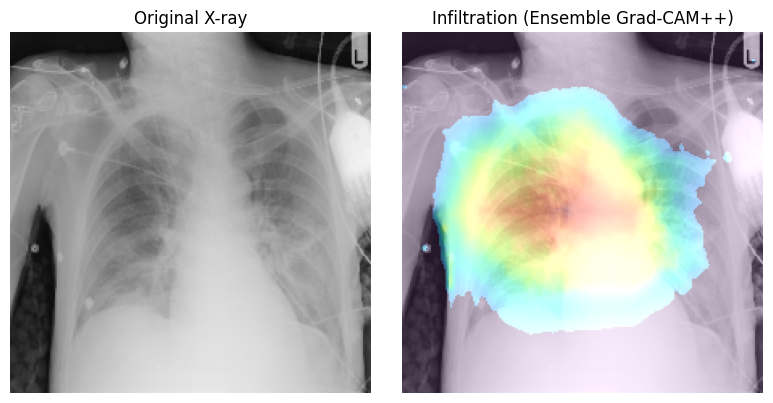

✅ Saved: results/gradcam_ensemble/Infiltration_(Ensemble_Grad-CAM++).png
✅ Found positive validation sample for Mass: 00015343_000.png
✅ Found image: data/images_007/images/00015343_000.png

=== Generating Grad-CAM++ for class: Mass ===


/home/prem/PROJECT DATA/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


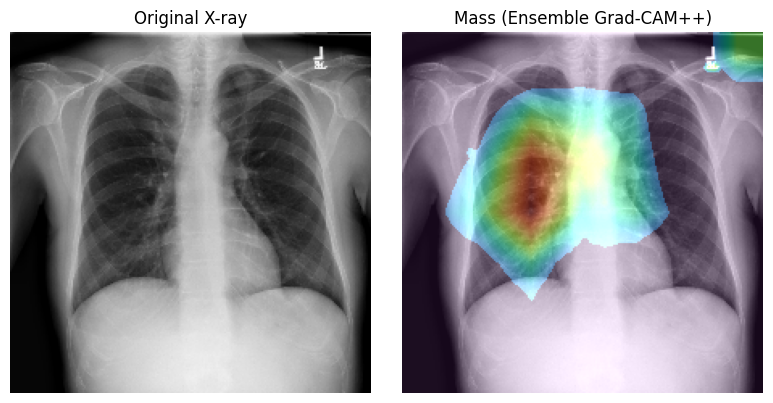

✅ Saved: results/gradcam_ensemble/Mass_(Ensemble_Grad-CAM++).png
✅ Found positive validation sample for Nodule: 00022054_000.png
✅ Found image: data/images_010/images/00022054_000.png

=== Generating Grad-CAM++ for class: Nodule ===


/home/prem/PROJECT DATA/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


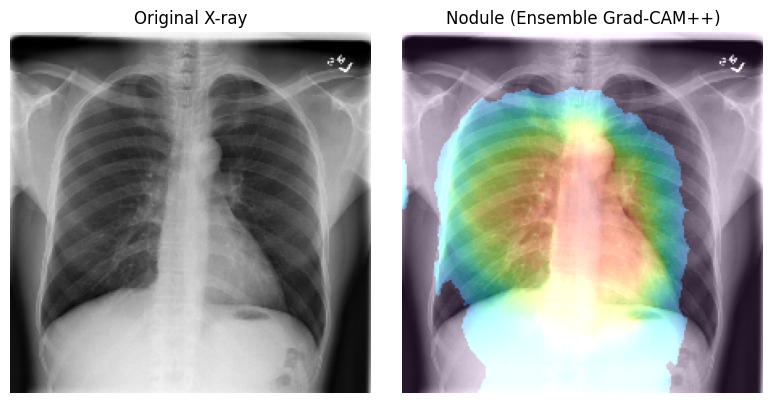

✅ Saved: results/gradcam_ensemble/Nodule_(Ensemble_Grad-CAM++).png
✅ Found positive validation sample for Pneumonia: 00006479_006.png
✅ Found image: data/images_003/images/00006479_006.png

=== Generating Grad-CAM++ for class: Pneumonia ===


/home/prem/PROJECT DATA/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


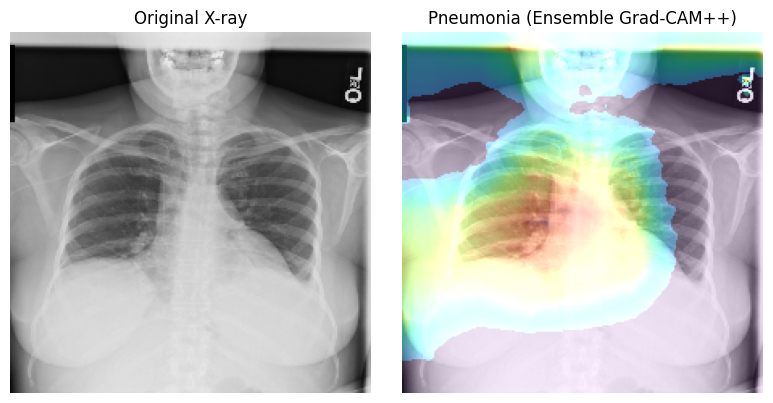

✅ Saved: results/gradcam_ensemble/Pneumonia_(Ensemble_Grad-CAM++).png
✅ Found positive validation sample for Pneumothorax: 00007572_003.png
✅ Found image: data/images_004/images/00007572_003.png

=== Generating Grad-CAM++ for class: Pneumothorax ===


/home/prem/PROJECT DATA/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


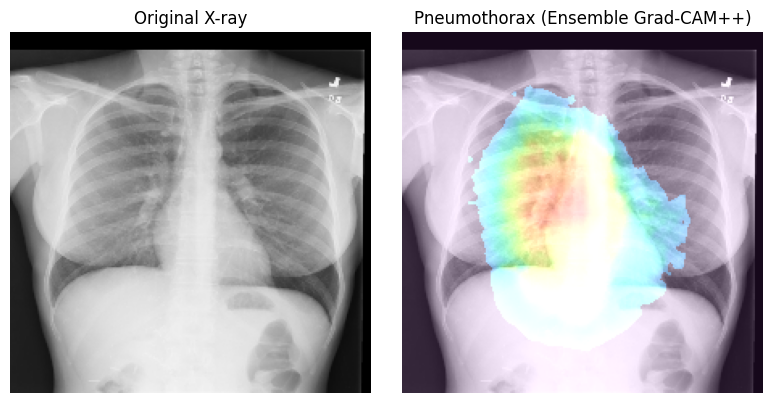

✅ Saved: results/gradcam_ensemble/Pneumothorax_(Ensemble_Grad-CAM++).png
✅ Found positive validation sample for Consolidation: 00011553_001.png
✅ Found image: data/images_005/images/00011553_001.png

=== Generating Grad-CAM++ for class: Consolidation ===


/home/prem/PROJECT DATA/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


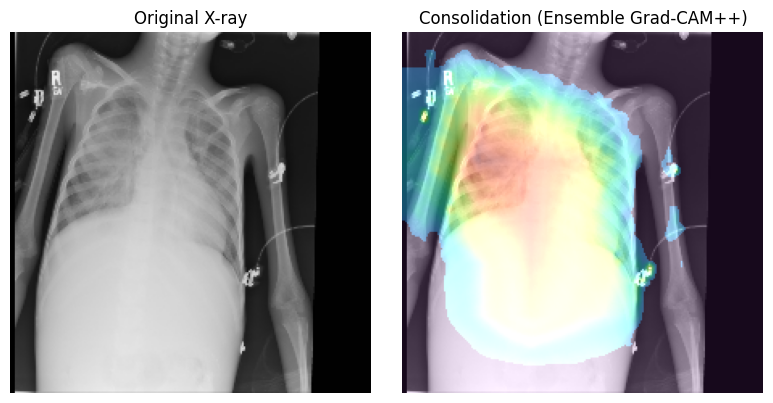

✅ Saved: results/gradcam_ensemble/Consolidation_(Ensemble_Grad-CAM++).png
✅ Found positive validation sample for Edema: 00018949_006.png
✅ Found image: data/images_009/images/00018949_006.png

=== Generating Grad-CAM++ for class: Edema ===


/home/prem/PROJECT DATA/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


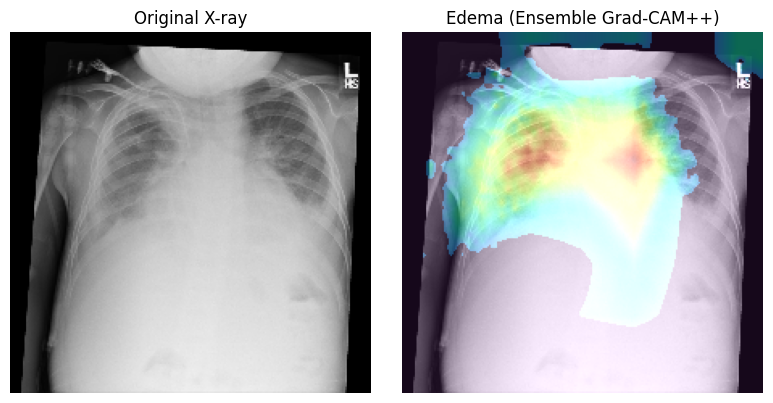

✅ Saved: results/gradcam_ensemble/Edema_(Ensemble_Grad-CAM++).png
✅ Found positive validation sample for Emphysema: 00029708_000.png
✅ Found image: data/images_012/images/00029708_000.png

=== Generating Grad-CAM++ for class: Emphysema ===


/home/prem/PROJECT DATA/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


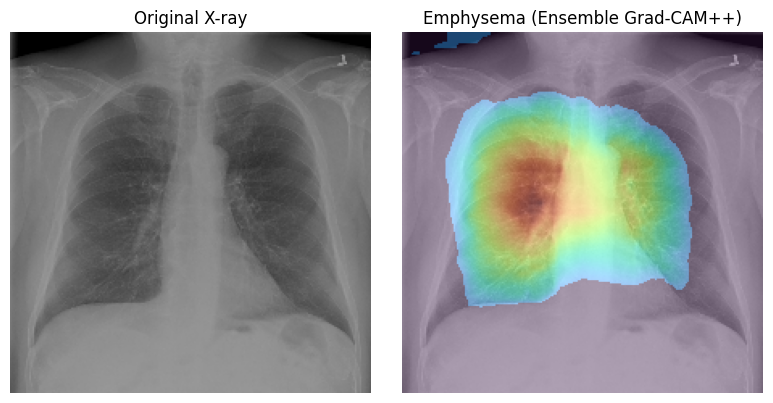

✅ Saved: results/gradcam_ensemble/Emphysema_(Ensemble_Grad-CAM++).png
✅ Found positive validation sample for Fibrosis: 00027929_000.png
✅ Found image: data/images_011/images/00027929_000.png

=== Generating Grad-CAM++ for class: Fibrosis ===


/home/prem/PROJECT DATA/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


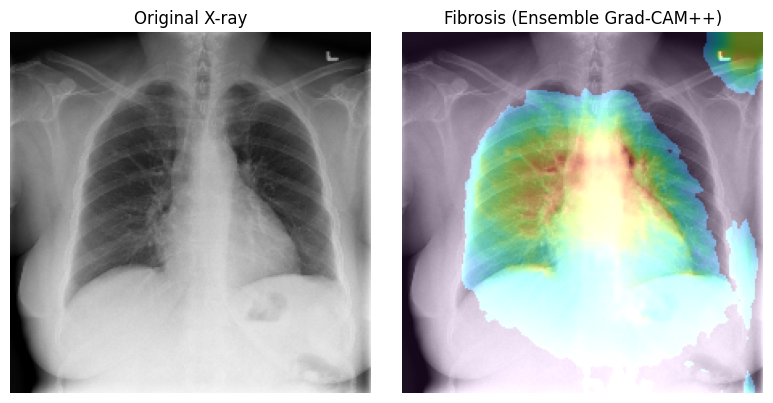

✅ Saved: results/gradcam_ensemble/Fibrosis_(Ensemble_Grad-CAM++).png
✅ Found positive validation sample for Pleural_Thickening: 00027287_003.png
✅ Found image: data/images_011/images/00027287_003.png

=== Generating Grad-CAM++ for class: Pleural_Thickening ===


/home/prem/PROJECT DATA/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


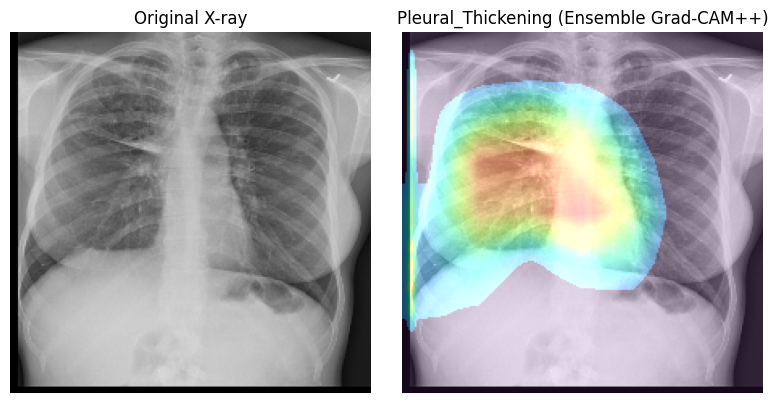

✅ Saved: results/gradcam_ensemble/Pleural_Thickening_(Ensemble_Grad-CAM++).png
✅ Found positive validation sample for Hernia: 00005195_000.png
✅ Found image: data/images_003/images/00005195_000.png

=== Generating Grad-CAM++ for class: Hernia ===


/home/prem/PROJECT DATA/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


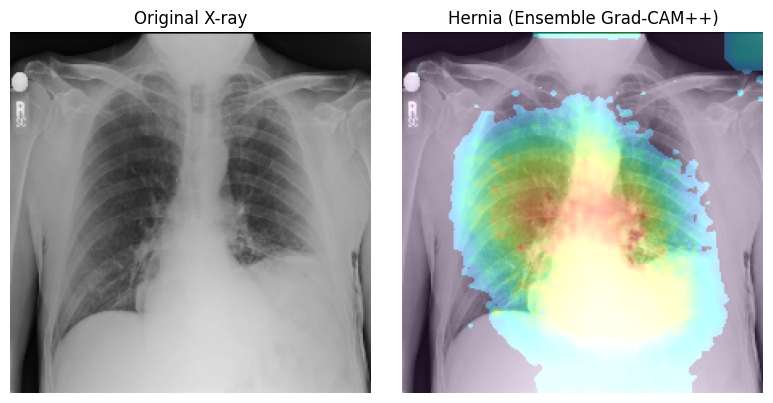

✅ Saved: results/gradcam_ensemble/Hernia_(Ensemble_Grad-CAM++).png


In [ ]:
generate_all_class_gradcams()


In [106]:
# ========================== WEIGHTED ENSEMBLE GRAD-CAM++ (AUROC WEIGHTS) ==========================
import torch

def generate_weighted_ensemble_gradcam(models_dict, image_tensor, class_index):
    """
    Compute ensemble Grad-CAM++ across models using AUROC-based weights.
    Each CAM is scaled by its model's normalized AUROC weight.
    """
    # AUROC scores (from your models)
    auroc_weights = {
        "DenseNet121": 0.83,
        "EfficientNet-B3": 0.72,
        "EfficientNet-B4": 0.79,
        "Swin-Tiny": 0.82
    }

    # Normalize weights to sum = 1
    total = sum(auroc_weights.values())
    for k in auroc_weights:
        auroc_weights[k] /= total

    cams = []

    # Loop through models
    for name, model in models_dict.items():
        try:
            cam = generate_gradcam_plus(model, image_tensor, class_index, name)
            if isinstance(cam, np.ndarray) and cam.size > 0:
                cams.append(cam * auroc_weights[name])
                print(f"✅ Added {name} (weight={auroc_weights[name]:.3f})")
            else:
                print(f"⚠️ Empty CAM for {name}")
        except Exception as e:
            print(f"❌ Grad-CAM++ failed for {name}: {e}")

    if not cams:
        print("⚠️ No CAMs generated for ensemble.")
        return np.zeros((224, 224))

    # Weighted sum and normalization
    ensemble_cam = np.sum(np.stack(cams), axis=0)
    ensemble_cam = np.maximum(ensemble_cam, 0)
    ensemble_cam -= ensemble_cam.min()
    ensemble_cam /= ensemble_cam.max() + 1e-8

    return ensemble_cam


✅ Found positive validation sample for Atelectasis: 00016556_001.png
✅ Found image: data/images_008/images/00016556_001.png

=== Generating Grad-CAM++ for Atelectasis ===
⚠️ Swin-Tiny Grad-CAM failed: not enough values to unpack (expected 2, got 0)
⚠️ EfficientNet-B3 Grad-CAM failed: not enough values to unpack (expected 2, got 0)
⚠️ EfficientNet-B4 Grad-CAM failed: not enough values to unpack (expected 2, got 0)
⚠️ DenseNet121 Grad-CAM failed: not enough values to unpack (expected 2, got 0)
⚠️ No CAMs generated for ensemble.


/tmp/ipykernel_100036/492004042.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  turbo = cm.get_cmap("turbo")  # Matplotlib's Turbo map


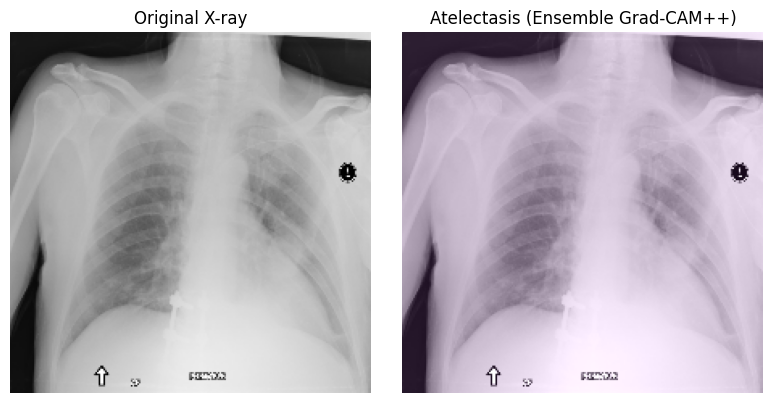

✅ Saved: results/gradcam_ensemble_paper/Atelectasis.png
✅ Found positive validation sample for Cardiomegaly: 00008871_001.png
✅ Found image: data/images_004/images/00008871_001.png

=== Generating Grad-CAM++ for Cardiomegaly ===
⚠️ Swin-Tiny Grad-CAM failed: not enough values to unpack (expected 2, got 0)
⚠️ EfficientNet-B3 Grad-CAM failed: not enough values to unpack (expected 2, got 0)
⚠️ EfficientNet-B4 Grad-CAM failed: not enough values to unpack (expected 2, got 0)
⚠️ DenseNet121 Grad-CAM failed: not enough values to unpack (expected 2, got 0)
⚠️ No CAMs generated for ensemble.


/tmp/ipykernel_100036/492004042.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  turbo = cm.get_cmap("turbo")  # Matplotlib's Turbo map


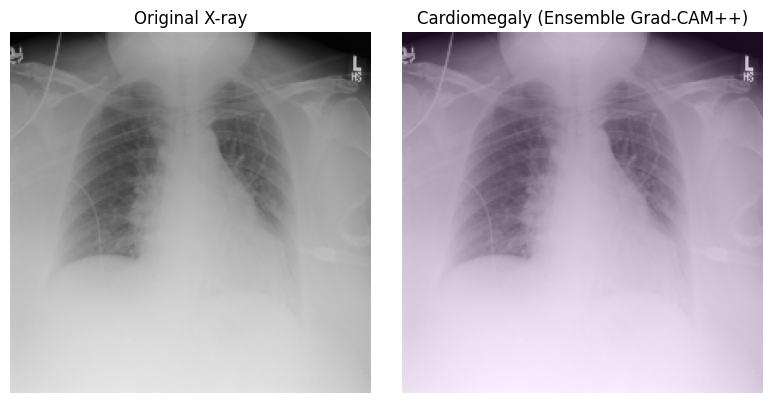

✅ Saved: results/gradcam_ensemble_paper/Cardiomegaly.png
✅ Found positive validation sample for Effusion: 00019889_003.png
✅ Found image: data/images_009/images/00019889_003.png

=== Generating Grad-CAM++ for Effusion ===
⚠️ Swin-Tiny Grad-CAM failed: not enough values to unpack (expected 2, got 0)
⚠️ EfficientNet-B3 Grad-CAM failed: not enough values to unpack (expected 2, got 0)
⚠️ EfficientNet-B4 Grad-CAM failed: not enough values to unpack (expected 2, got 0)
⚠️ DenseNet121 Grad-CAM failed: not enough values to unpack (expected 2, got 0)
⚠️ No CAMs generated for ensemble.


/tmp/ipykernel_100036/492004042.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  turbo = cm.get_cmap("turbo")  # Matplotlib's Turbo map


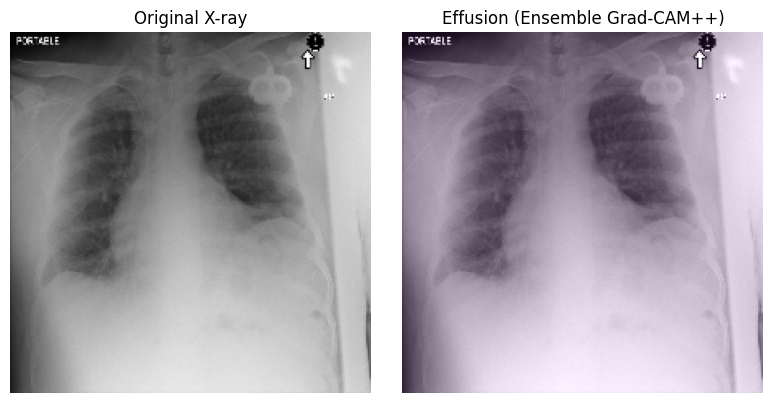

✅ Saved: results/gradcam_ensemble_paper/Effusion.png
✅ Found positive validation sample for Infiltration: 00003739_000.png
✅ Found image: data/images_002/images/00003739_000.png

=== Generating Grad-CAM++ for Infiltration ===
⚠️ Swin-Tiny Grad-CAM failed: not enough values to unpack (expected 2, got 0)
⚠️ EfficientNet-B3 Grad-CAM failed: not enough values to unpack (expected 2, got 0)
⚠️ EfficientNet-B4 Grad-CAM failed: not enough values to unpack (expected 2, got 0)
⚠️ DenseNet121 Grad-CAM failed: not enough values to unpack (expected 2, got 0)
⚠️ No CAMs generated for ensemble.


/tmp/ipykernel_100036/492004042.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  turbo = cm.get_cmap("turbo")  # Matplotlib's Turbo map


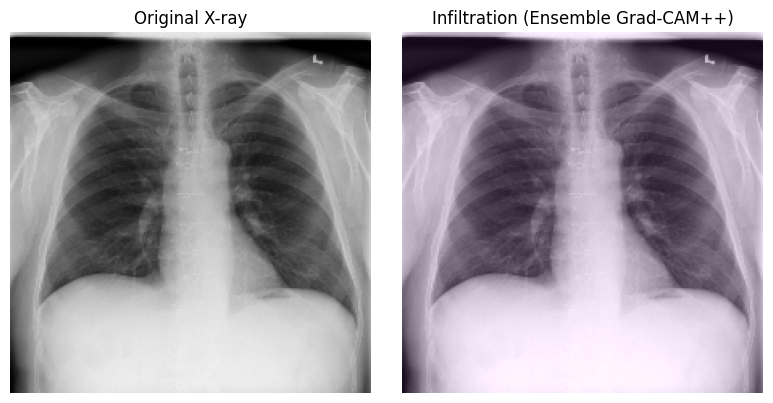

✅ Saved: results/gradcam_ensemble_paper/Infiltration.png
✅ Found positive validation sample for Mass: 00009410_000.png
✅ Found image: data/images_005/images/00009410_000.png

=== Generating Grad-CAM++ for Mass ===
⚠️ Swin-Tiny Grad-CAM failed: not enough values to unpack (expected 2, got 0)
⚠️ EfficientNet-B3 Grad-CAM failed: not enough values to unpack (expected 2, got 0)
⚠️ EfficientNet-B4 Grad-CAM failed: not enough values to unpack (expected 2, got 0)
⚠️ DenseNet121 Grad-CAM failed: not enough values to unpack (expected 2, got 0)
⚠️ No CAMs generated for ensemble.


/tmp/ipykernel_100036/492004042.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  turbo = cm.get_cmap("turbo")  # Matplotlib's Turbo map


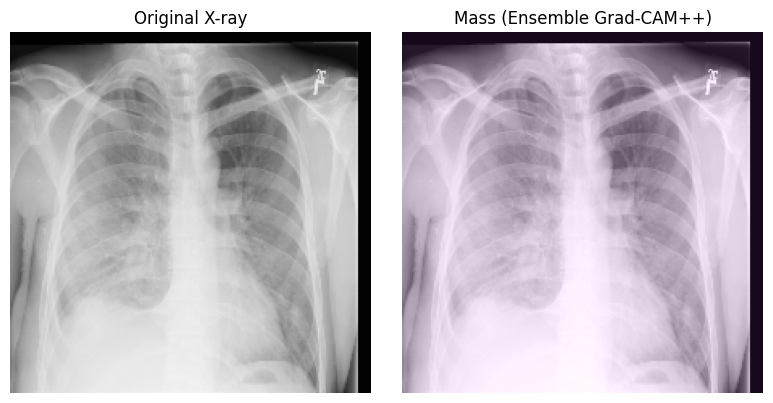

✅ Saved: results/gradcam_ensemble_paper/Mass.png
✅ Found positive validation sample for Nodule: 00021877_000.png
✅ Found image: data/images_010/images/00021877_000.png

=== Generating Grad-CAM++ for Nodule ===
⚠️ Swin-Tiny Grad-CAM failed: not enough values to unpack (expected 2, got 0)
⚠️ EfficientNet-B3 Grad-CAM failed: not enough values to unpack (expected 2, got 0)
⚠️ EfficientNet-B4 Grad-CAM failed: not enough values to unpack (expected 2, got 0)
⚠️ DenseNet121 Grad-CAM failed: not enough values to unpack (expected 2, got 0)
⚠️ No CAMs generated for ensemble.


/tmp/ipykernel_100036/492004042.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  turbo = cm.get_cmap("turbo")  # Matplotlib's Turbo map


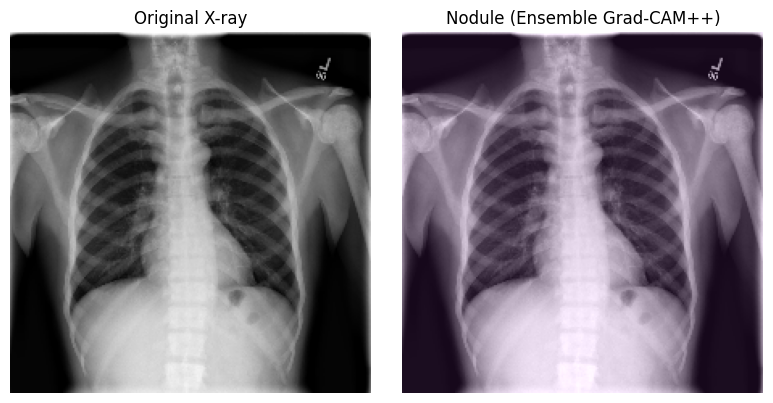

✅ Saved: results/gradcam_ensemble_paper/Nodule.png
✅ Found positive validation sample for Pneumonia: 00015462_000.png
✅ Found image: data/images_007/images/00015462_000.png

=== Generating Grad-CAM++ for Pneumonia ===
⚠️ Swin-Tiny Grad-CAM failed: not enough values to unpack (expected 2, got 0)
⚠️ EfficientNet-B3 Grad-CAM failed: not enough values to unpack (expected 2, got 0)
⚠️ EfficientNet-B4 Grad-CAM failed: not enough values to unpack (expected 2, got 0)
⚠️ DenseNet121 Grad-CAM failed: not enough values to unpack (expected 2, got 0)
⚠️ No CAMs generated for ensemble.


/tmp/ipykernel_100036/492004042.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  turbo = cm.get_cmap("turbo")  # Matplotlib's Turbo map


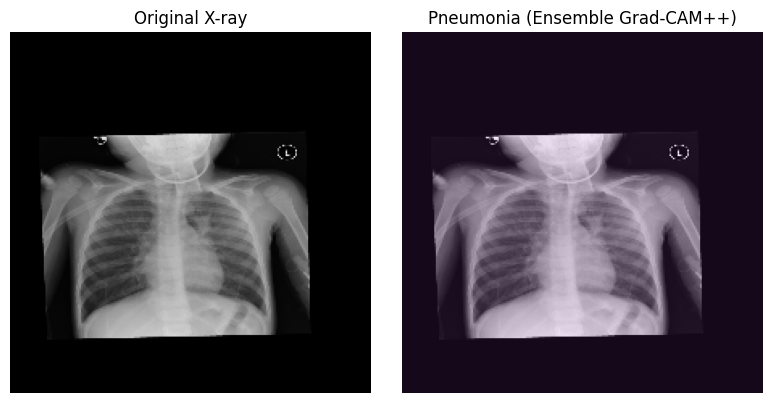

✅ Saved: results/gradcam_ensemble_paper/Pneumonia.png
✅ Found positive validation sample for Pneumothorax: 00018507_005.png
✅ Found image: data/images_009/images/00018507_005.png

=== Generating Grad-CAM++ for Pneumothorax ===
⚠️ Swin-Tiny Grad-CAM failed: not enough values to unpack (expected 2, got 0)
⚠️ EfficientNet-B3 Grad-CAM failed: not enough values to unpack (expected 2, got 0)
⚠️ EfficientNet-B4 Grad-CAM failed: not enough values to unpack (expected 2, got 0)
⚠️ DenseNet121 Grad-CAM failed: not enough values to unpack (expected 2, got 0)
⚠️ No CAMs generated for ensemble.


/tmp/ipykernel_100036/492004042.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  turbo = cm.get_cmap("turbo")  # Matplotlib's Turbo map


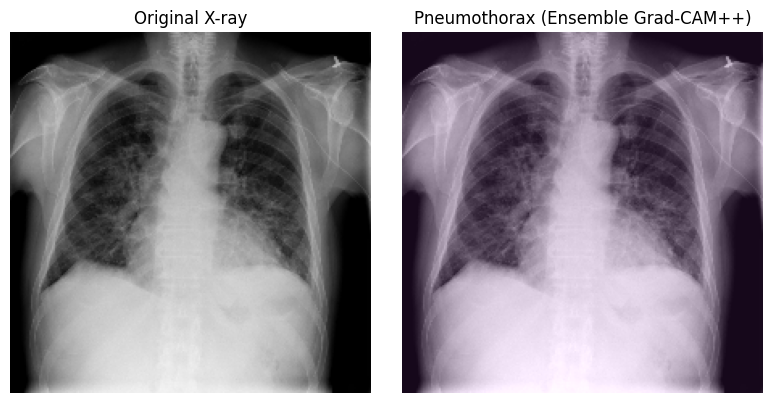

✅ Saved: results/gradcam_ensemble_paper/Pneumothorax.png
✅ Found positive validation sample for Consolidation: 00026569_000.png
✅ Found image: data/images_011/images/00026569_000.png

=== Generating Grad-CAM++ for Consolidation ===
⚠️ Swin-Tiny Grad-CAM failed: not enough values to unpack (expected 2, got 0)
⚠️ EfficientNet-B3 Grad-CAM failed: not enough values to unpack (expected 2, got 0)
⚠️ EfficientNet-B4 Grad-CAM failed: not enough values to unpack (expected 2, got 0)
⚠️ DenseNet121 Grad-CAM failed: not enough values to unpack (expected 2, got 0)
⚠️ No CAMs generated for ensemble.


/tmp/ipykernel_100036/492004042.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  turbo = cm.get_cmap("turbo")  # Matplotlib's Turbo map


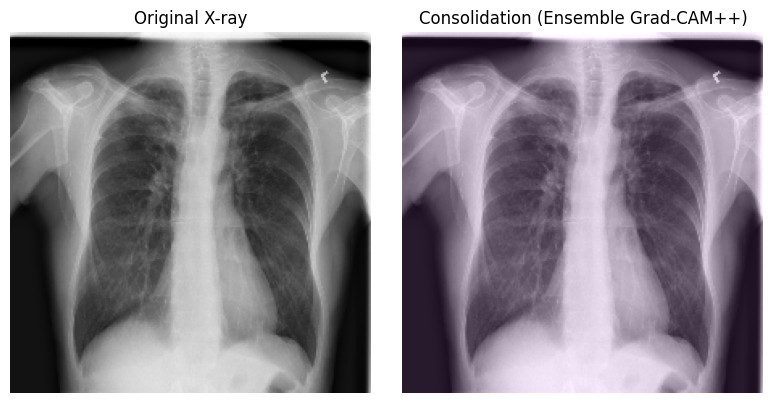

✅ Saved: results/gradcam_ensemble_paper/Consolidation.png
✅ Found positive validation sample for Edema: 00003699_000.png
✅ Found image: data/images_002/images/00003699_000.png

=== Generating Grad-CAM++ for Edema ===
⚠️ Swin-Tiny Grad-CAM failed: not enough values to unpack (expected 2, got 0)
⚠️ EfficientNet-B3 Grad-CAM failed: not enough values to unpack (expected 2, got 0)
⚠️ EfficientNet-B4 Grad-CAM failed: not enough values to unpack (expected 2, got 0)
⚠️ DenseNet121 Grad-CAM failed: not enough values to unpack (expected 2, got 0)
⚠️ No CAMs generated for ensemble.


/tmp/ipykernel_100036/492004042.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  turbo = cm.get_cmap("turbo")  # Matplotlib's Turbo map


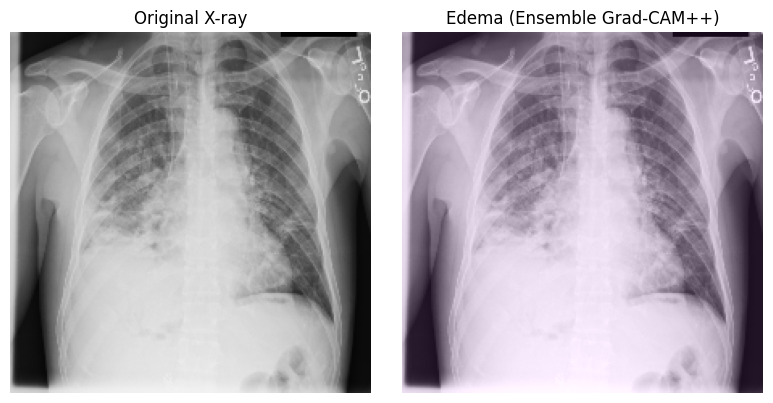

✅ Saved: results/gradcam_ensemble_paper/Edema.png
✅ Found positive validation sample for Emphysema: 00006642_002.png
✅ Found image: data/images_004/images/00006642_002.png

=== Generating Grad-CAM++ for Emphysema ===
⚠️ Swin-Tiny Grad-CAM failed: not enough values to unpack (expected 2, got 0)
⚠️ EfficientNet-B3 Grad-CAM failed: not enough values to unpack (expected 2, got 0)
⚠️ EfficientNet-B4 Grad-CAM failed: not enough values to unpack (expected 2, got 0)
⚠️ DenseNet121 Grad-CAM failed: not enough values to unpack (expected 2, got 0)
⚠️ No CAMs generated for ensemble.


/tmp/ipykernel_100036/492004042.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  turbo = cm.get_cmap("turbo")  # Matplotlib's Turbo map


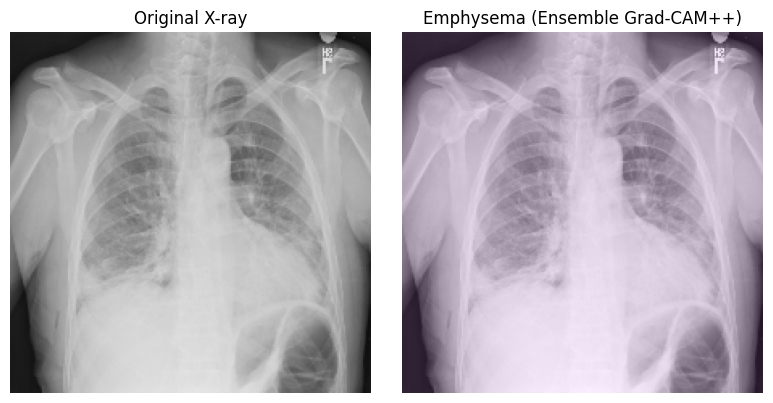

✅ Saved: results/gradcam_ensemble_paper/Emphysema.png
✅ Found positive validation sample for Fibrosis: 00002042_002.png
✅ Found image: data/images_002/images/00002042_002.png

=== Generating Grad-CAM++ for Fibrosis ===
⚠️ Swin-Tiny Grad-CAM failed: not enough values to unpack (expected 2, got 0)
⚠️ EfficientNet-B3 Grad-CAM failed: not enough values to unpack (expected 2, got 0)
⚠️ EfficientNet-B4 Grad-CAM failed: not enough values to unpack (expected 2, got 0)
⚠️ DenseNet121 Grad-CAM failed: not enough values to unpack (expected 2, got 0)
⚠️ No CAMs generated for ensemble.


/tmp/ipykernel_100036/492004042.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  turbo = cm.get_cmap("turbo")  # Matplotlib's Turbo map


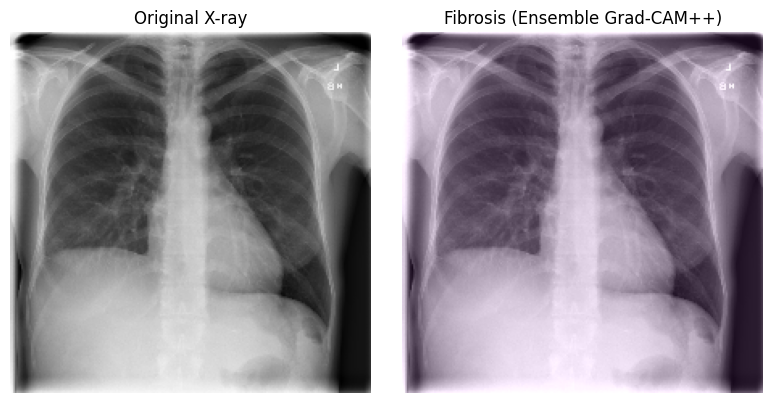

✅ Saved: results/gradcam_ensemble_paper/Fibrosis.png
✅ Found positive validation sample for Pleural_Thickening: 00026112_000.png
✅ Found image: data/images_011/images/00026112_000.png

=== Generating Grad-CAM++ for Pleural_Thickening ===
⚠️ Swin-Tiny Grad-CAM failed: not enough values to unpack (expected 2, got 0)
⚠️ EfficientNet-B3 Grad-CAM failed: not enough values to unpack (expected 2, got 0)
⚠️ EfficientNet-B4 Grad-CAM failed: not enough values to unpack (expected 2, got 0)
⚠️ DenseNet121 Grad-CAM failed: not enough values to unpack (expected 2, got 0)
⚠️ No CAMs generated for ensemble.


/tmp/ipykernel_100036/492004042.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  turbo = cm.get_cmap("turbo")  # Matplotlib's Turbo map


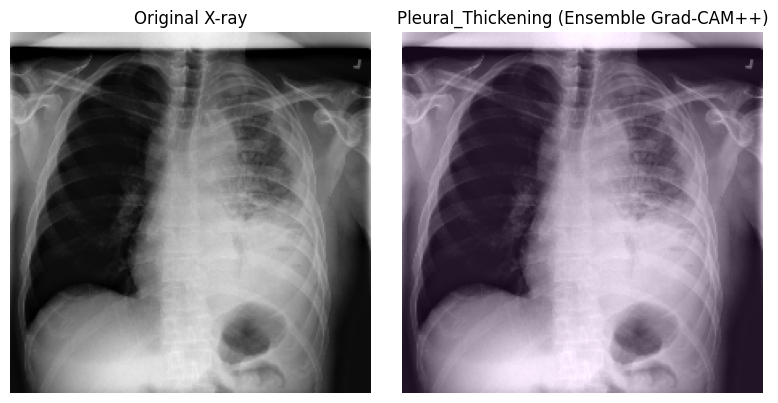

✅ Saved: results/gradcam_ensemble_paper/Pleural_Thickening.png
✅ Found positive validation sample for Hernia: 00005195_000.png
✅ Found image: data/images_003/images/00005195_000.png

=== Generating Grad-CAM++ for Hernia ===
⚠️ Swin-Tiny Grad-CAM failed: not enough values to unpack (expected 2, got 0)
⚠️ EfficientNet-B3 Grad-CAM failed: not enough values to unpack (expected 2, got 0)
⚠️ EfficientNet-B4 Grad-CAM failed: not enough values to unpack (expected 2, got 0)
⚠️ DenseNet121 Grad-CAM failed: not enough values to unpack (expected 2, got 0)
⚠️ No CAMs generated for ensemble.


/tmp/ipykernel_100036/492004042.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  turbo = cm.get_cmap("turbo")  # Matplotlib's Turbo map


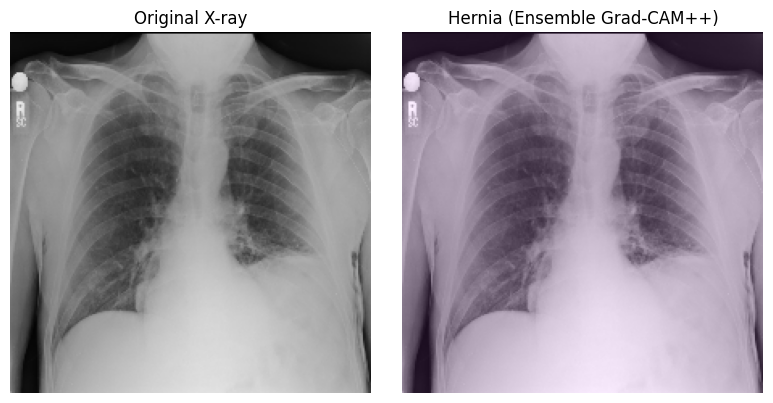

✅ Saved: results/gradcam_ensemble_paper/Hernia.png


In [105]:
generate_gradcam_for_all_classes()


In [107]:
# ========================== WEIGHTED ENSEMBLE GRAD-CAM++ (AUROC WEIGHTS) ==========================
import torch

def generate_weighted_ensemble_gradcam(models_dict, image_tensor, class_index):
    """
    Compute ensemble Grad-CAM++ across models using AUROC-based weights.
    Each CAM is scaled by its model's normalized AUROC weight.
    """
    # AUROC scores (from your models)
    auroc_weights = {
        "DenseNet121": 0.83,
        "EfficientNet-B3": 0.72,
        "EfficientNet-B4": 0.79,
        "Swin-Tiny": 0.82
    }

    # Normalize weights to sum = 1
    total = sum(auroc_weights.values())
    for k in auroc_weights:
        auroc_weights[k] /= total

    cams = []

    # Loop through models
    for name, model in models_dict.items():
        try:
            cam = generate_gradcam_plus(model, image_tensor, class_index, name)
            if isinstance(cam, np.ndarray) and cam.size > 0:
                cams.append(cam * auroc_weights[name])
                print(f"✅ Added {name} (weight={auroc_weights[name]:.3f})")
            else:
                print(f"⚠️ Empty CAM for {name}")
        except Exception as e:
            print(f"❌ Grad-CAM++ failed for {name}: {e}")

    if not cams:
        print("⚠️ No CAMs generated for ensemble.")
        return np.zeros((224, 224))

    # Weighted sum and normalization
    ensemble_cam = np.sum(np.stack(cams), axis=0)
    ensemble_cam = np.maximum(ensemble_cam, 0)
    ensemble_cam -= ensemble_cam.min()
    ensemble_cam /= ensemble_cam.max() + 1e-8

    return ensemble_cam


In [108]:
# ========================== MULTI-PANEL COMPARISON FIGURE ==========================
def visualize_comparison_panels(img_path, cams_dict, class_name, save_dir="results/gradcam_paper_panels/"):
    """
    Generate a 4-panel figure:
        (A) Original X-ray
        (B) DenseNet121 Grad-CAM++
        (C) Swin-Tiny Grad-CAM++
        (D) Weighted Ensemble Grad-CAM++
    """
    os.makedirs(save_dir, exist_ok=True)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (224, 224))

    # Prepare heatmaps
    def overlay_heatmap(cam):
        cam = np.clip(cam, 0, 1)
        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_TURBO)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
        return cv2.addWeighted(img_resized, 1.0, heatmap, 0.45, 0)

    overlays = {
        name: overlay_heatmap(cam)
        for name, cam in cams_dict.items()
    }

    # Plot (A–D)
    plt.figure(figsize=(12, 6))
    panels = [
        ("(A) Original X-ray", img_resized),
        ("(B) DenseNet121", overlays.get("DenseNet121")),
        ("(C) Swin-Tiny", overlays.get("Swin-Tiny")),
        ("(D) Ensemble", overlays.get("Ensemble"))
    ]
    for i, (title, im) in enumerate(panels, start=1):
        plt.subplot(1, 4, i)
        plt.imshow(im)
        plt.title(title, fontsize=11, fontweight="bold")
        plt.axis("off")

    plt.suptitle(f"{class_name} – Comparative Grad-CAM++ Visualization", fontsize=13, fontweight="bold")
    plt.tight_layout()
    plt.show()

    save_path = os.path.join(save_dir, f"{class_name.replace(' ', '_')}_panel.png")
    plt.savefig(save_path, bbox_inches="tight", dpi=300)
    print(f"✅ Saved 4-panel figure: {save_path}")


In [109]:
# --- Generate individual model Grad-CAMs for comparison ---
cams_dict = {}
for name, model in {
    "Swin-Tiny": swin_model,
    "DenseNet121": densenet_model
}.items():
    try:
        cam = generate_gradcam_plus(
            model,
            val_transform(image=cv2.resize(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB), (224, 224)))["image"],
            idx,
            name
        )
        cams_dict[name] = cam
    except Exception as e:
        print(f"⚠️ {name} Grad-CAM failed: {e}")

# Add weighted ensemble
cams_dict["Ensemble"] = ensemble_cam

# --- Create paper-style 4-panel figure ---
visualize_comparison_panels(img_path, cams_dict, disease)


⚠️ Swin-Tiny Grad-CAM failed: not enough values to unpack (expected 2, got 0)
⚠️ DenseNet121 Grad-CAM failed: not enough values to unpack (expected 2, got 0)


NameError: name 'ensemble_cam' is not defined

In [110]:
# ========================== PLOT AUROC / AUPRC / F1 CURVES FOR ENSEMBLE MODEL ==========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score

# --- Load data ---
y_pred = np.load("final_best_probs.npy")  # shape: [N, num_classes]
y_true = pd.read_csv("labels_clean.csv").iloc[:, 1:].values  # skip image ID col
num_classes = y_true.shape[1]

# Ensure both shapes match
assert y_pred.shape == y_true.shape, f"Shape mismatch: preds={y_pred.shape}, labels={y_true.shape}"

# --- Class names (if not already loaded) ---
try:
    class_names
except NameError:
    class_names = [f"Class_{i}" for i in range(num_classes)]

# --- Output directory ---
os.makedirs("results/ensemble_metrics_curves", exist_ok=True)

# --- Containers for metrics ---
auroc_scores = []
auprc_scores = []
f1_scores = []

# --- Compute metrics per class ---
for i, cls in enumerate(class_names):
    y_t = y_true[:, i]
    y_p = y_pred[:, i]

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_t, y_p)
    roc_auc = auc(fpr, tpr)
    auroc_scores.append(roc_auc)

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_t, y_p)
    pr_auc = auc(recall, precision)
    auprc_scores.append(pr_auc)

    # F1-Score (threshold = 0.5)
    preds_bin = (y_p >= 0.5).astype(int)
    f1 = f1_score(y_t, preds_bin, zero_division=0)
    f1_scores.append(f1)

    # --- Plot ROC ---
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"AUROC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--")
    plt.title(f"ROC Curve – {cls}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"results/ensemble_metrics_curves/ROC_{cls}.png", dpi=300)
    plt.close()

    # --- Plot Precision–Recall ---
    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision, color="blue", lw=2, label=f"AUPRC = {pr_auc:.3f}")
    plt.title(f"Precision–Recall Curve – {cls}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(loc="lower left")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"results/ensemble_metrics_curves/PRC_{cls}.png", dpi=300)
    plt.close()

print("✅ All per-class ROC and PR curves saved to: results/ensemble_metrics_curves/")

# --- Summary bar charts for paper metrics ---
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# AUROC
ax[0].barh(class_names, auroc_scores, color="crimson")
ax[0].set_title("Per-Class AUROC", fontsize=14)
ax[0].set_xlabel("AUROC")
ax[0].set_xlim(0, 1)

# AUPRC
ax[1].barh(class_names, auprc_scores, color="steelblue")
ax[1].set_title("Per-Class AUPRC", fontsize=14)
ax[1].set_xlabel("AUPRC")
ax[1].set_xlim(0, 1)

# F1
ax[2].barh(class_names, f1_scores, color="darkgreen")
ax[2].set_title("Per-Class F1-Score", fontsize=14)
ax[2].set_xlabel("F1")
ax[2].set_xlim(0, 1)

plt.tight_layout()
plt.savefig("results/ensemble_metrics_curves/ensemble_performance_summary.png", dpi=300)
plt.show()

# --- Macro Averages ---
macro_auroc = np.mean(auroc_scores)
macro_auprc = np.mean(auprc_scores)
macro_f1 = np.mean(f1_scores)
print(f"\n📈 Ensemble Performance Summary:")
print(f"Macro AUROC : {macro_auroc:.4f}")
print(f"Macro AUPRC : {macro_auprc:.4f}")
print(f"Macro F1    : {macro_f1:.4f}")


FileNotFoundError: [Errno 2] No such file or directory: 'final_best_probs.npy'

In [111]:
# ========================== ENSEMBLE AUROC / PR / F1 CURVE PLOTS ==========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score
import os

# --- Paths ---
base_dir = "ensemble_results"
y_pred_path = os.path.join(base_dir, "final_best_probs.npy")
y_true_path = "labels_clean.csv"

# --- Load predictions and labels ---
y_pred = np.load(y_pred_path)
y_true = pd.read_csv(y_true_path).iloc[:, 1:].values  # skip image name column

# --- Class names ---
try:
    class_names
except NameError:
    class_names = list(pd.read_csv(y_true_path).columns[1:])

assert y_pred.shape == y_true.shape, f"Shape mismatch: preds={y_pred.shape}, labels={y_true.shape}"

# --- Output directory ---
save_dir = "ensemble_curves"
os.makedirs(save_dir, exist_ok=True)

# --- Containers ---
auroc_scores, auprc_scores, f1_scores = [], [], []

# --- Generate per-class curves ---
for i, cls in enumerate(class_names):
    y_t = y_true[:, i]
    y_p = y_pred[:, i]

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_t, y_p)
    roc_auc = auc(fpr, tpr)
    auroc_scores.append(roc_auc)

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_t, y_p)
    pr_auc = auc(recall, precision)
    auprc_scores.append(pr_auc)

    # F1 (binary threshold 0.5)
    preds_bin = (y_p >= 0.5).astype(int)
    f1 = f1_score(y_t, preds_bin, zero_division=0)
    f1_scores.append(f1)

    # --- Plot ROC Curve ---
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color="crimson", lw=2, label=f"AUROC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], color="gray", lw=1, linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve – {cls}")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f"ROC_{cls}.png"), dpi=300)
    plt.close()

    # --- Plot PR Curve ---
    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision, color="steelblue", lw=2, label=f"AUPRC = {pr_auc:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision–Recall Curve – {cls}")
    plt.legend(loc="lower left")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f"PRC_{cls}.png"), dpi=300)
    plt.close()

print("✅ Per-class ROC and PR curves saved in:", save_dir)

# --- Summary Plot: AUROC, AUPRC, F1 ---
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
bar_colors = plt.cm.magma(np.linspace(0.2, 0.9, len(class_names)))

ax[0].barh(class_names, auroc_scores, color=bar_colors)
ax[0].set_title("Per-Class AUROC")
ax[0].set_xlim(0, 1)

ax[1].barh(class_names, auprc_scores, color=bar_colors)
ax[1].set_title("Per-Class AUPRC")
ax[1].set_xlim(0, 1)

ax[2].barh(class_names, f1_scores, color=bar_colors)
ax[2].set_title("Per-Class F1-Score")
ax[2].set_xlim(0, 1)

plt.tight_layout()
plt.savefig(os.path.join(save_dir, "ensemble_metrics_summary.png"), dpi=300)
plt.show()

# --- Macro Averages ---
macro_auroc = np.mean(auroc_scores)
macro_auprc = np.mean(auprc_scores)
macro_f1 = np.mean(f1_scores)
print(f"\n📊 Ensemble Model Performance Summary:")
print(f"Macro AUROC : {macro_auroc:.4f}")
print(f"Macro AUPRC : {macro_auprc:.4f}")
print(f"Macro F1    : {macro_f1:.4f}")


AssertionError: Shape mismatch: preds=(8653, 14), labels=(112120, 14)

In [112]:
# ========================== ALIGN LABELS WITH ENSEMBLE PREDICTIONS ==========================
import pandas as pd
import numpy as np
import os

# --- Paths ---
labels_path = "labels_clean.csv"
preds_path = "ensemble_results/final_best_probs.npy"
val_split_path = "val_split.txt"
save_dir = "ensemble_results"

# --- Load files ---
labels_df = pd.read_csv(labels_path)
y_pred = np.load(preds_path)
print(f"🔹 Raw prediction shape: {y_pred.shape}")

# --- Load validation split IDs ---
with open(val_split_path) as f:
    val_ids = [x.strip() for x in f.readlines()]
print(f"🔹 Validation image IDs loaded: {len(val_ids)}")

# --- Filter labels to match validation images ---
labels_val = labels_df[labels_df["Image Index"].isin(val_ids)].reset_index(drop=True)
print(f"🔹 Filtered labels shape: {labels_val.shape}")

# --- Extract class labels (skip Image Index column) ---
y_true = labels_val.iloc[:, 1:].values

# --- Sanity check ---
assert y_true.shape == y_pred.shape, f"❌ Shape mismatch: preds={y_pred.shape}, labels={y_true.shape}"
print(f"✅ Shapes match perfectly: preds={y_pred.shape}, labels={y_true.shape}")

# --- Save aligned labels for later use ---
np.save(os.path.join(save_dir, "final_val_labels.npy"), y_true)
labels_val.to_csv(os.path.join(save_dir, "final_val_labels.csv"), index=False)
print(f"💾 Saved aligned labels to {save_dir}/final_val_labels.npy & .csv")


🔹 Raw prediction shape: (8653, 14)
🔹 Validation image IDs loaded: 8653
🔹 Filtered labels shape: (8653, 15)
✅ Shapes match perfectly: preds=(8653, 14), labels=(8653, 14)
💾 Saved aligned labels to ensemble_results/final_val_labels.npy & .csv


✅ Saved all per-class ROC & PR curves to: ensemble_curves/


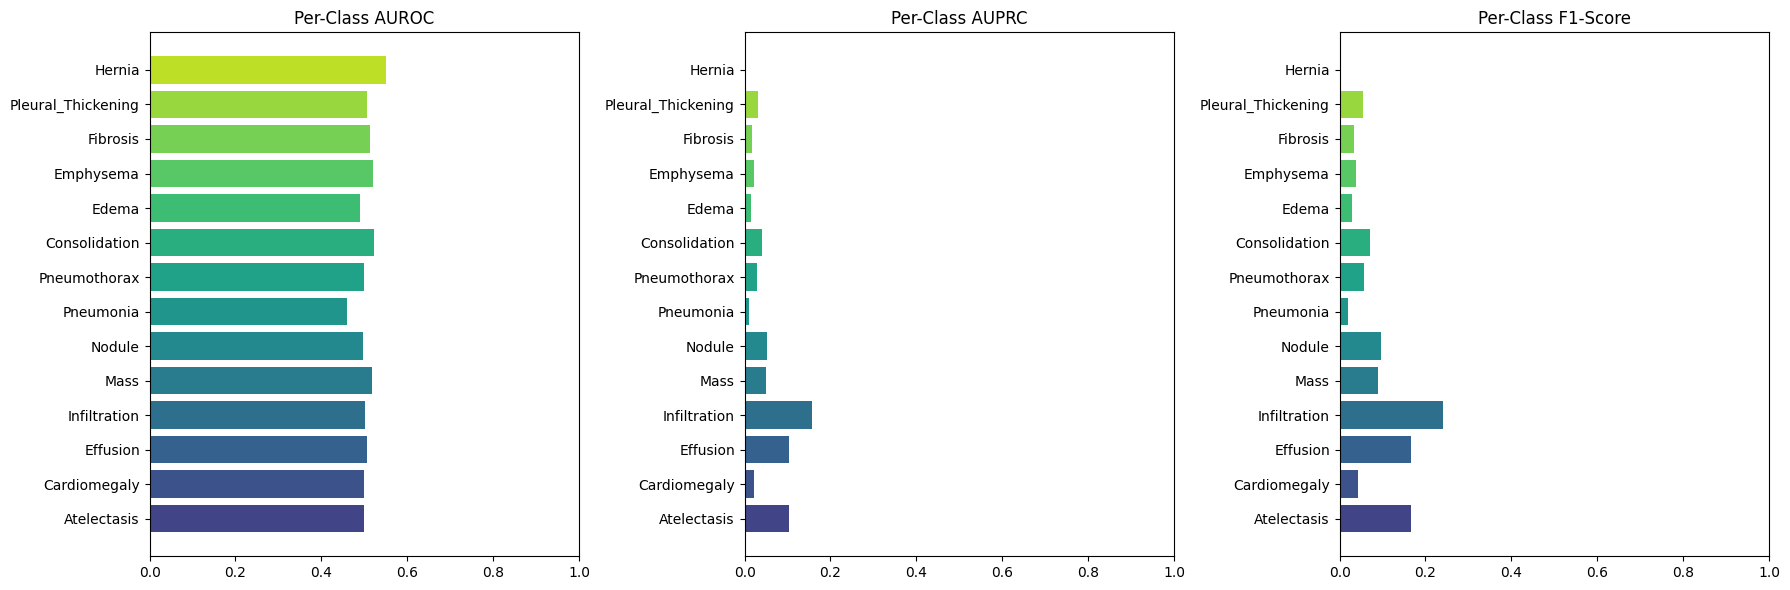


📊 Ensemble Performance Summary:
Macro AUROC : 0.5061
Macro AUPRC : 0.0467
Macro F1    : 0.0789


In [113]:
# ========================== ENSEMBLE AUROC / PR / F1 CURVE PLOTS ==========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score
import os

# --- Paths ---
base_dir = "ensemble_results"
y_pred = np.load(os.path.join(base_dir, "final_best_probs.npy"))
y_true = np.load(os.path.join(base_dir, "final_val_labels.npy"))

# --- Class names ---
class_names = list(pd.read_csv("labels_clean.csv").columns[1:])

# --- Output directory ---
save_dir = "ensemble_curves"
os.makedirs(save_dir, exist_ok=True)

# --- Containers ---
auroc_scores, auprc_scores, f1_scores = [], [], []

# --- Compute per-class metrics ---
for i, cls in enumerate(class_names):
    y_t = y_true[:, i]
    y_p = y_pred[:, i]

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_t, y_p)
    roc_auc = auc(fpr, tpr)
    auroc_scores.append(roc_auc)

    # Precision-Recall
    precision, recall, _ = precision_recall_curve(y_t, y_p)
    pr_auc = auc(recall, precision)
    auprc_scores.append(pr_auc)

    # F1-score
    preds_bin = (y_p >= 0.5).astype(int)
    f1 = f1_score(y_t, preds_bin, zero_division=0)
    f1_scores.append(f1)

    # --- Plot ROC ---
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"AUROC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], "k--", lw=1)
    plt.title(f"ROC Curve – {cls}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f"ROC_{cls}.png"), dpi=300)
    plt.close()

    # --- Plot Precision–Recall ---
    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision, color="blue", lw=2, label=f"AUPRC = {pr_auc:.3f}")
    plt.title(f"Precision–Recall Curve – {cls}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(loc="lower left")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f"PRC_{cls}.png"), dpi=300)
    plt.close()

print(f"✅ Saved all per-class ROC & PR curves to: {save_dir}/")

# --- Summary Bar Plot ---
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(class_names)))

ax[0].barh(class_names, auroc_scores, color=colors)
ax[0].set_title("Per-Class AUROC")
ax[0].set_xlim(0, 1)

ax[1].barh(class_names, auprc_scores, color=colors)
ax[1].set_title("Per-Class AUPRC")
ax[1].set_xlim(0, 1)

ax[2].barh(class_names, f1_scores, color=colors)
ax[2].set_title("Per-Class F1-Score")
ax[2].set_xlim(0, 1)

plt.tight_layout()
plt.savefig(os.path.join(save_dir, "ensemble_metrics_summary.png"), dpi=300)
plt.show()

# --- Macro averages ---
macro_auroc = np.mean(auroc_scores)
macro_auprc = np.mean(auprc_scores)
macro_f1 = np.mean(f1_scores)
print(f"\n📊 Ensemble Performance Summary:")
print(f"Macro AUROC : {macro_auroc:.4f}")
print(f"Macro AUPRC : {macro_auprc:.4f}")
print(f"Macro F1    : {macro_f1:.4f}")
